# 2e Itération

Nous allons réaliser une deuxième itération en modifiant certains paramètres de départ : 
- Suppression des outliers (Chine, Etats Unis, Inde, Brésil) pour améliorer le clustering et l'ACP
- Suppression de la variable "coût de production" car trop de valeurs manquantes (plus de valeurs imputées que de valeurs réelles)
- Conservation des variables essentielles pour l'ACP et supression des autres
- Ajustement du nombre de clusters pour affiner les regroupement de pays

Dans ce fichier :
- Suppression des outliers
- Suppression de la variable "coût de production"

In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

In [269]:
from scipy.spatial.distance import mahalanobis

In [270]:
folder = 'D:/Data_Analyst_Projet/Projet 9/Donnees/donnees en plus/'
folder2 = 'D:/Data_Analyst_Projet/Projet 9/Donnees/'
folder_export = 'D:/Data_Analyst_Projet/Projet 9/Donnees/fichier analyse/'

In [271]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_row', 150)

## Fichier Disponibilité alimentaire

On va chercher les données qui nous intéresse dans le fichier disponibilité alimentaire.

L'objectif est d'avoir une vision mondiale de la viande de Volaille et d'extraire les indicateurs importants dans ce domaine.

Je vais agréger les données par pays, pour avoir des informations pour chaque pays sur :
- l'importation de volaille, 
- la part de l'importation par rapport à ce qui est consommé,
- la part de la production par rapport à ce qui est consommé, 
- la proportion de la volaille dans la nourriture, 
- la proportion d'animaux dans la nourriture.

Les données sont en milliers de tonnes.

In [272]:
df = pd.read_csv(folder2+'DisponibiliteAlimentaire_2017.csv')
df.head()

Code Domaine                      Domaine  Code zone         Zone  \
0          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
1          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
2          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
3          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   
4          FBS  Nouveaux Bilans Alimentaire          2  Afghanistan   

   Code Élément                   Élément  Code Produit          Produit  \
0          5511                Production          2511  Blé et produits   
1          5611   Importations - Quantité          2511  Blé et produits   
2          5072        Variation de stock          2511  Blé et produits   
3          5911   Exportations - Quantité          2511  Blé et produits   
4          5301  Disponibilité intérieure          2511  Blé et produits   

   Code année  Année               Unité   Valeur Symbole  \
0        2017   2017  Milliers de tonnes 4,281.00       S   
1        2017   2017  Milliers de tonnes 2,302.00       S   
2        2017   2017  Milliers de tonnes  -119.00       S   
3        2017   2017  Milliers de tonnes     0.00       S   
4        2017   2017  Milliers de tonnes 6,701.00       S   

  Description du Symbole  
0  Données standardisées  
1  Données standardisées  
2  Données standardisées  
3  Données standardisées  
4  Données standardisées

In [273]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176600 entries, 0 to 176599
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Code Domaine            176600 non-null  object 
 1   Domaine                 176600 non-null  object 
 2   Code zone               176600 non-null  int64  
 3   Zone                    176600 non-null  object 
 4   Code Élément            176600 non-null  int64  
 5   Élément                 176600 non-null  object 
 6   Code Produit            176600 non-null  int64  
 7   Produit                 176600 non-null  object 
 8   Code année              176600 non-null  int64  
 9   Année                   176600 non-null  int64  
 10  Unité                   176600 non-null  object 
 11  Valeur                  176600 non-null  float64
 12  Symbole                 176600 non-null  object 
 13  Description du Symbole  176600 non-null  object 
dtypes: float64(1), int64

In [274]:
dispo_alim = df.copy()

In [275]:
# on garde que la viande de volaille et les colonnes pertinentes
dispo_poulet = dispo_alim[dispo_alim['Produit']=='Viande de Volailles'][['Zone', 'Élément', 'Valeur']].reset_index(drop=True)
dispo_poulet = pd.pivot_table(dispo_poulet, columns='Élément', index='Zone', values='Valeur').reset_index()

In [276]:
# renommage colonne
dispo_poulet.rename(columns={'Zone' : 'pays'}, inplace=True)

In [277]:
dispo_poulet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 18 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   pays                                                           172 non-null    object 
 1   Alimentation pour touristes                                    78 non-null     float64
 2   Aliments pour animaux                                          1 non-null      float64
 3   Autres utilisations (non alimentaire)                          34 non-null     float64
 4   Disponibilité alimentaire (Kcal/personne/jour)                 172 non-null    float64
 5   Disponibilité alimentaire en quantité (kg/personne/an)         172 non-null    float64
 6   Disponibilité de matière grasse en quantité (g/personne/jour)  172 non-null    float64
 7   Disponibilité de protéines en quantité (g/personne/jour)      

In [278]:
# création de la variable taux de dépendance, part importation par rapport à ce qui est consommé
dispo_poulet['taux_dependance'] = dispo_poulet['Importations - Quantité']/dispo_poulet['Disponibilité intérieure']
# création de la variable taux d'autosuffisance', part production par rapport à ce qui est consommé moins les exportations
dispo_poulet['taux_autosuffisance'] = (dispo_poulet['Production']-dispo_poulet['Exportations - Quantité'])/dispo_poulet['Disponibilité intérieure']

In [279]:
# nourriture totale par pays
nourriture = dispo_alim[dispo_alim['Élément']=='Nourriture'].groupby('Zone')[['Valeur']].sum().reset_index()

nourriture.rename(columns={'Zone':'pays', 'Valeur':'nourriture_totale'}, inplace=True)

dispo_poulet = dispo_poulet.merge(nourriture, how='left', on='pays')

In [280]:
# création de la variable part de la volaille dans la nourriture du pays
dispo_poulet['proportion_volaille_nourriture'] = dispo_poulet['Nourriture']/dispo_poulet['nourriture_totale']

In [281]:
# part produit animaux

# liste des produits animaux, viandes, poissons ou fruits de mer
produits_animaux = ['Viande de Bovins',
       "Viande d'Ovins/Caprins", 'Viande de Suides',
       'Viande de Volailles', 'Viande, Autre', 'Abats Comestible',
       'Poissons Eau Douce','Poissons Pelagiques', 'Poissons Marins, Autres', 'Crustacés',
       'Cephalopodes', 'Mollusques, Autres', 'Animaux Aquatiques Autre',
       'Viande de Anim Aquatiq']

# Consommation de la nourriture animale : animaux, viandes, poissons ou fruits de mer 
A = dispo_alim[dispo_alim.Produit.isin(produits_animaux)]
consommation_produits_animaux = A[A['Élément']=='Nourriture'].groupby('Zone')[['Valeur']].sum().reset_index()

# renommage
consommation_produits_animaux.rename(columns={'Zone':'pays', 'Valeur':'nourriture_produits_animaux'}, inplace=True)

# jointure
dispo_poulet = dispo_poulet.merge(consommation_produits_animaux, how='left', on='pays')

# création du champs part animaux dans la nourriture du pays
dispo_poulet['proportion_animaux_nourriture'] = dispo_poulet['nourriture_produits_animaux']/dispo_poulet['nourriture_totale']

In [282]:
dispo_poulet[dispo_poulet.isna().any(axis=1)]

pays  Alimentation pour touristes  \
0              Afghanistan                          NaN   
1           Afrique du Sud                         0.00   
2                  Albanie                          NaN   
3                  Algérie                         0.00   
4                Allemagne                          NaN   
..                     ...                          ...   
167    Émirats arabes unis                          NaN   
168               Équateur                         0.00   
169  États-Unis d'Amérique                          NaN   
170               Éthiopie                         0.00   
171           Îles Salomon                         0.00   

     Aliments pour animaux  Autres utilisations (non alimentaire)  \
0                      NaN                                    NaN   
1                      NaN                                    NaN   
2                      NaN                                    NaN   
3                      NaN                                    NaN   
4                      NaN                                    NaN   
..                     ...                                    ...   
167                    NaN                                    NaN   
168                    NaN                                    NaN   
169                    NaN                                  89.00   
170                    NaN                                    NaN   
171                    NaN                                    NaN   

     Disponibilité alimentaire (Kcal/personne/jour)  \
0                                              5.00   
1                                            143.00   
2                                             85.00   
3                                             22.00   
4                                             71.00   
..                                              ...   
167                                          147.00   
168                                           83.00   
169                                          219.00   
170                                            0.00   
171                                           18.00   

     Disponibilité alimentaire en quantité (kg/personne/an)  \
0                                                 1.53        
1                                                35.69        
2                                                16.36        
3                                                 6.38        
4                                                19.47        
..                                                 ...        
167                                              43.47        
168                                              19.31        
169                                              55.68        
170                                               0.13        
171                                               4.45        

     Disponibilité de matière grasse en quantité (g/personne/jour)  \
0                                                 0.33               
1                                                 9.25               
2                                                 6.45               
3                                                 1.50               
4                                                 4.16               
..                                                 ...               
167                                               9.25               
168                                               6.35               
169                                              14.83               
170                                               0.03               
171                                               1.31               

     Disponibilité de protéines en quantité (g/personne/jour)  \
0                                                 0.54          
1                                                14.11          
2                             

In [283]:
# on garde uniquement les variables qui nous intéresse
data = dispo_poulet[['pays', 'Exportations - Quantité', 'Importations - Quantité', 'Production', 'Nourriture', 'taux_dependance',
             'taux_autosuffisance','proportion_volaille_nourriture','proportion_animaux_nourriture']]

In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pays                            172 non-null    object 
 1   Exportations - Quantité         135 non-null    float64
 2   Importations - Quantité         170 non-null    float64
 3   Production                      168 non-null    float64
 4   Nourriture                      170 non-null    float64
 5   taux_dependance                 170 non-null    float64
 6   taux_autosuffisance             135 non-null    float64
 7   proportion_volaille_nourriture  170 non-null    float64
 8   proportion_animaux_nourriture   172 non-null    float64
dtypes: float64(8), object(1)
memory usage: 13.4+ KB


In [285]:
# on a trop peu d'informations pour ces pays, on ne les prends par en compte dans l'analyse
data[data.isna().any(axis=1)]

pays  Exportations - Quantité  \
0                              Afghanistan                      NaN   
13                                 Bahamas                      NaN   
14                              Bangladesh                      NaN   
23                            Burkina Faso                      NaN   
26                              Cabo Verde                      NaN   
27                                Cambodge                      NaN   
40                                    Cuba                      NaN   
43                                Djibouti                      NaN   
54                                  Gambie                      NaN   
56                                 Grenade                      NaN   
59                                  Guinée                      NaN   
60                           Guinée-Bissau                      NaN   
63                                   Haïti                      NaN   
80                                Kiribati                      NaN   
89                              Madagascar                      NaN   
91                                  Malawi                      NaN   
92                                Maldives                      NaN   
93                                    Mali                      NaN   
97                              Mauritanie                      NaN   
99                                Mongolie                      NaN   
101                             Mozambique                      NaN   
108                     Nouvelle-Calédonie                      NaN   
110                                  Népal                      NaN   
113                            Ouzbékistan                      NaN   
126              République centrafricaine                      NaN   
130  République démocratique populaire lao                      NaN   
132            République-Unie de Tanzanie                      NaN   
134        Saint-Vincent-et-les Grenadines                      NaN   
135                           Sainte-Lucie                      NaN   
137                   Sao Tomé-et-Principe                      NaN   
142                                 Soudan                      NaN   
148                            Tadjikistan                      NaN   
152                            Timor-Leste                      NaN   
156                           Turkménistan                      NaN   
160                                Vanuatu                      NaN   
165                               Zimbabwe                      NaN   
170                               Éthiopie                      NaN   

     Importations - Quantité  Production  Nourriture  taux_dependance  \
0                      29.00       28.00       55.00             0.51   
13                     24.00        6.00       16.00             0.92   
14                      0.00      249.00      240.00             0.00   
23                      0.00       46.00       44.00             0.00   
26                     12.00        1.00        9.00             1.20   
27                     10.00       28.00       37.00             0.26   
40                    312.00       29.00      269.00             0.91   
43                      3.00         NaN        3.00             1.00   
54                     16.00        2.00        8.00             2.00   
56                      7.00        1.00        5.00             0.88   
59                     37.00       13.00       49.00             0.74   
60                      4.00        3.00        4.00             1.00   
63                     89.00        9.00       98.00             0.91   
80                      1.00        1.00        2.00             0.50   
89                      0.00       81.00       73.00             0.00   
91                      0.00      130.00       91.00             0.00   
92                     12.00         NaN        7.00             1.00   
93                      1

In [286]:
# on supprime les lignes ci-dessus
data = data.drop(data[data.isna().any(axis=1)].index).reset_index(drop=True)

<Figure size 1500x900 with 0 Axes>

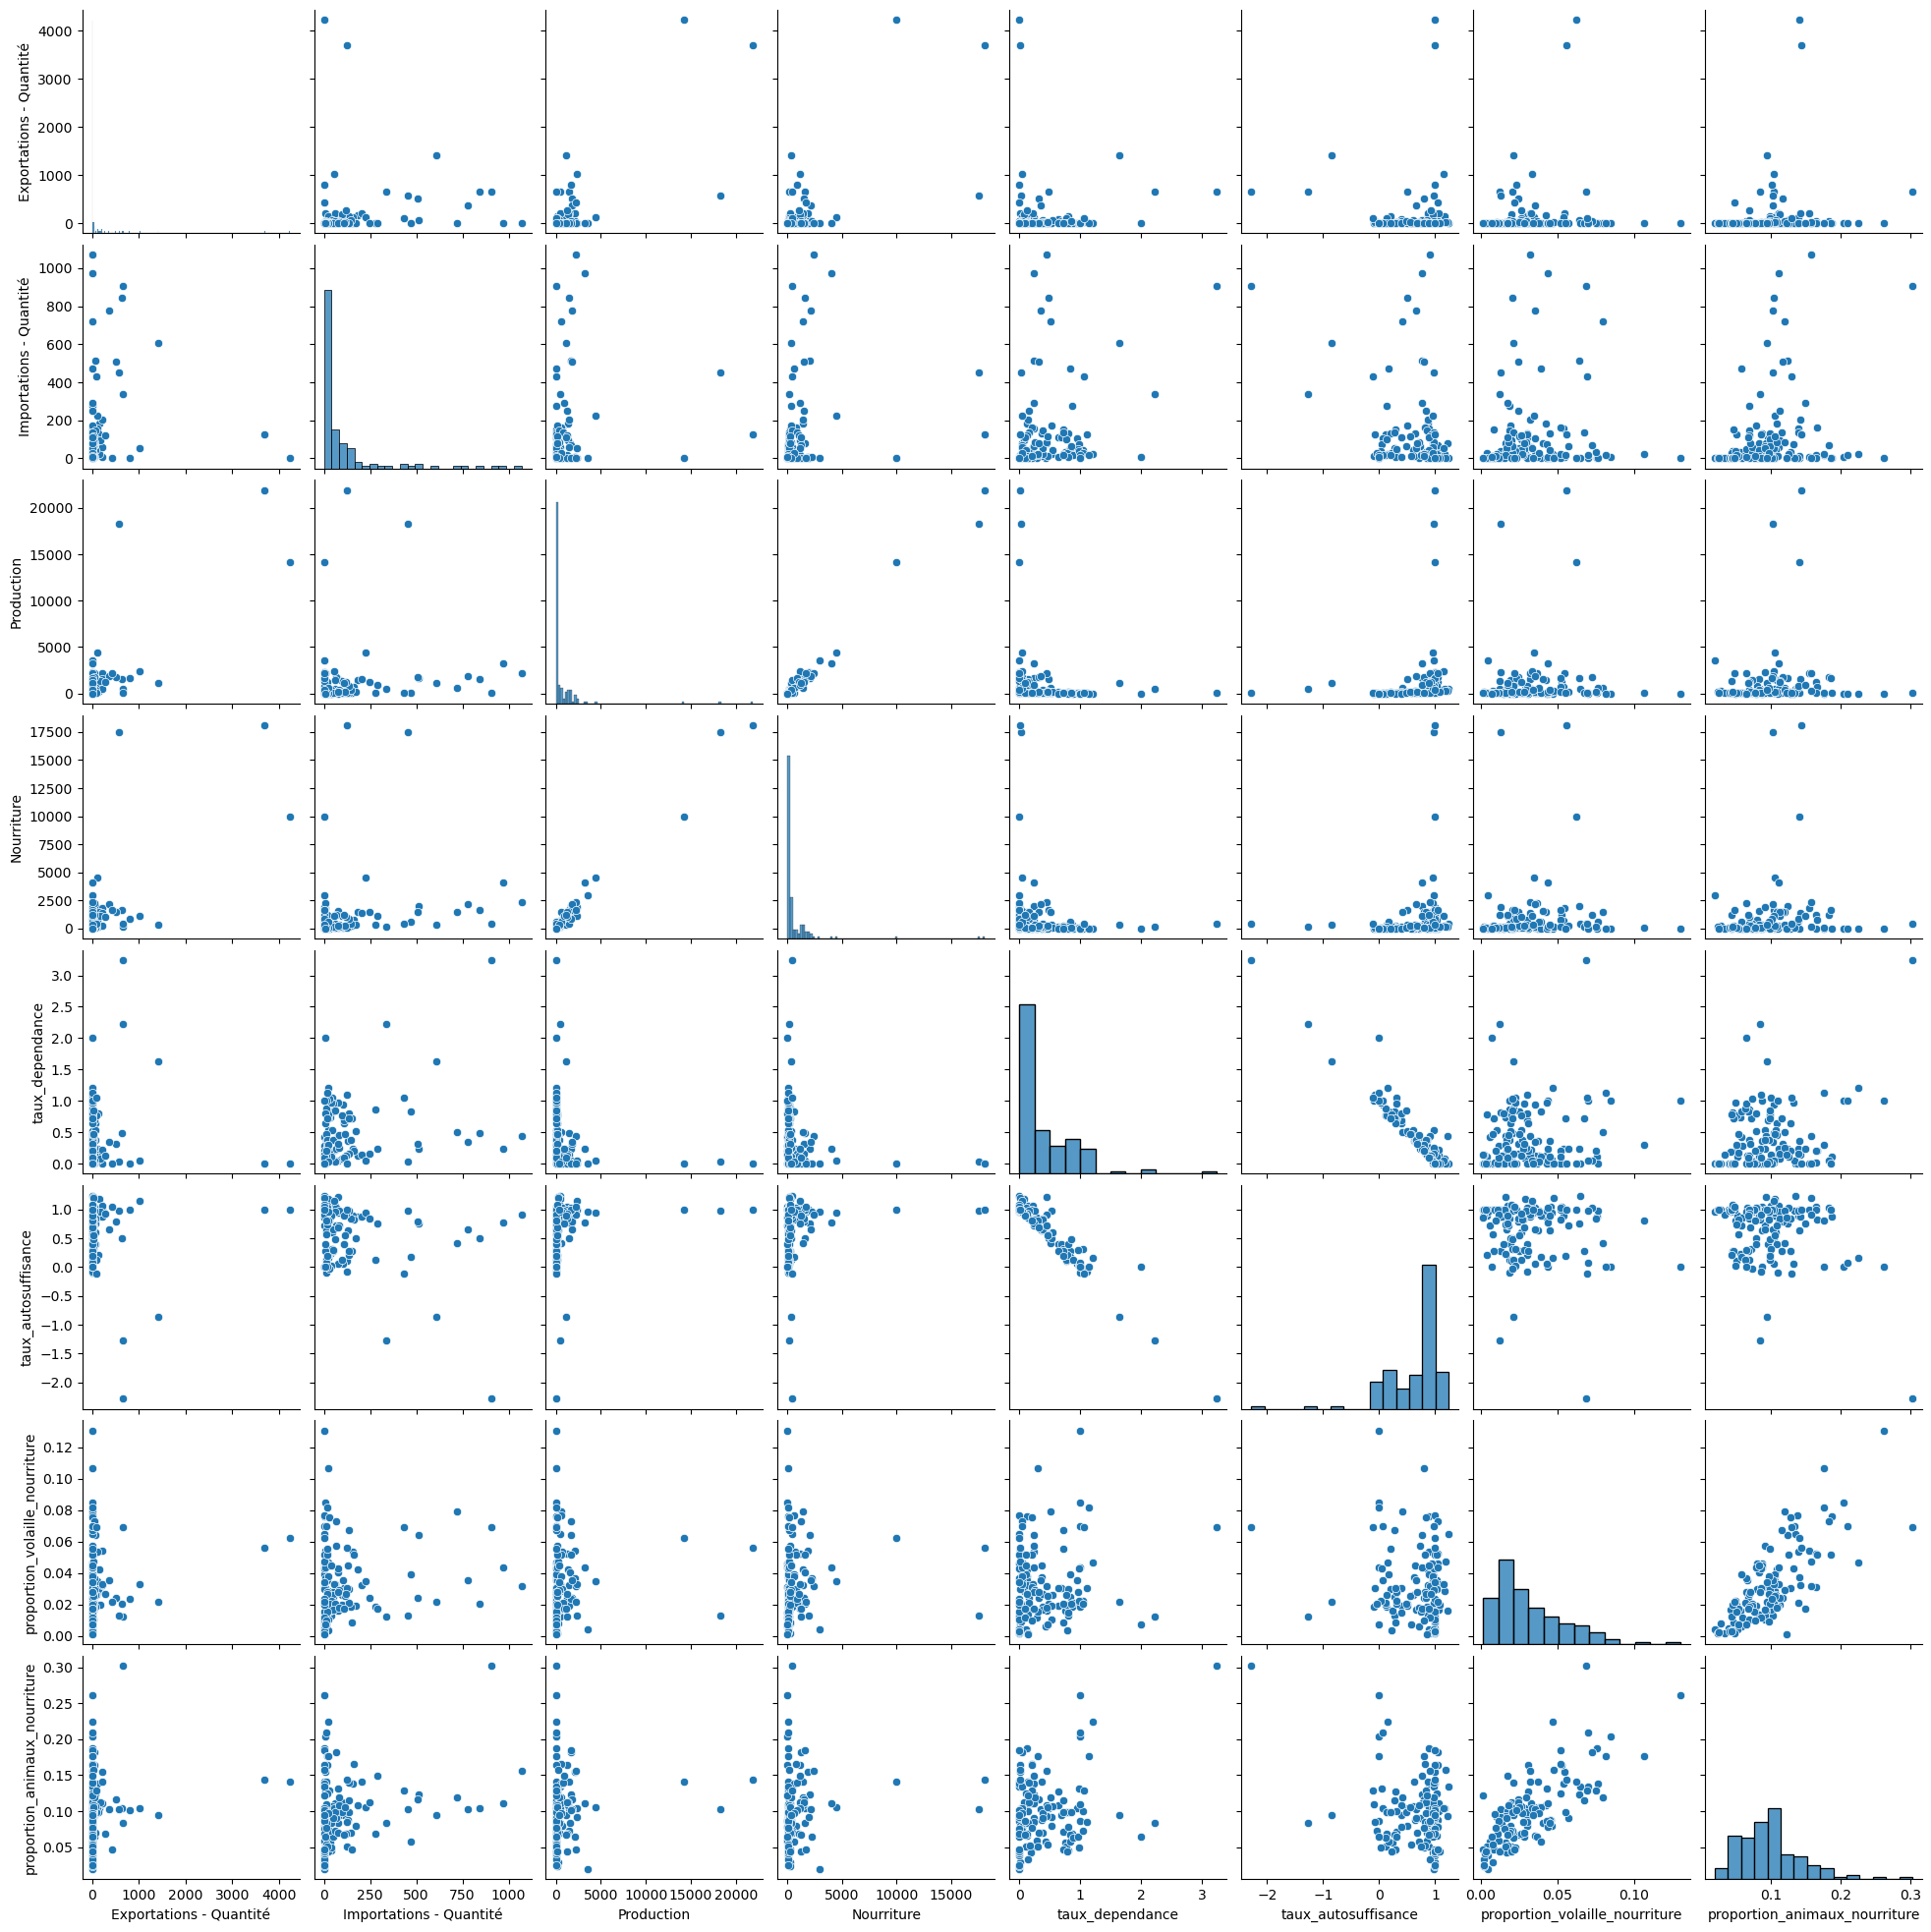

In [287]:
plt.figure(figsize=(15,9))

sns.pairplot(data)

plt.show()

On peut déjà voir 2 groupes de variables : 
- Les taux : leur distribution suit une loi normale ou en est proche.
- Les variables absolues : leur distribution est extrêmement étalée vers la droite, avec la majorité des valeurs proches de 0. Ce qui révèle la présence d'outliers pour ces variables.

Il semblerait qu'on visualise déjà des outliers. On verra plus tard comment on les traite en fonction des autres variables.

In [288]:
data.describe()

Exportations - Quantité  Importations - Quantité  Production  \
count                   135.00                   135.00      135.00   
mean                    132.19                   107.39      894.17   
std                     513.78                   204.11    2,766.07   
min                       0.00                     0.00        0.00   
25%                       0.00                     3.00       23.50   
50%                       3.00                    23.00      118.00   
75%                      32.00                   110.00      682.00   
max                   4,223.00                 1,069.00   21,914.00   

       Nourriture  taux_dependance  taux_autosuffisance  \
count      135.00           135.00               135.00   
mean       815.43             0.40                 0.66   
std      2,373.49             0.49                 0.49   
min          3.00             0.00                -2.28   
25%         46.00             0.04                 0.36   
50%        157.00             0.22                 0.86   
75%        634.00             0.72                 0.99   
max     18,100.00             3.24                 1.24   

       proportion_volaille_nourriture  proportion_animaux_nourriture  
count                          135.00                         135.00  
mean                             0.03                           0.10  
std                              0.02                           0.05  
min                              0.00                           0.02  
25%                              0.02                           0.07  
50%                              0.03                           0.10  
75%                              0.04                           0.12  
max                              0.13                           0.30

Les analyses sont confirmées par ces indicateurs. On voit des grands écarts types et une différence significative entre la médiane et la moyenne pour les variables absolues.
Cela confirme la présence d'outliers et la variabilité des valeurs de ces variables.

## Fichier Population

On va extraire du fichier la population de 2017 (l'année représentée dans disponibilité alimentaire) de chaque pays et le taux d'accroissement de la population.

Un pays qui a un taux d'accroissement de la population fort est un pays avec de futurs potentiels clients, on observera donc cette variable dans l'analyse.

In [289]:
df2 = pd.read_csv(folder2+'Population_2000_2018.csv')
df2.head()

Code Domaine                       Domaine  Code zone         Zone  \
0           OA  Séries temporelles annuelles          2  Afghanistan   
1           OA  Séries temporelles annuelles          2  Afghanistan   
2           OA  Séries temporelles annuelles          2  Afghanistan   
3           OA  Séries temporelles annuelles          2  Afghanistan   
4           OA  Séries temporelles annuelles          2  Afghanistan   

   Code Élément            Élément  Code Produit                 Produit  \
0           511  Population totale          3010  Population-Estimations   
1           511  Population totale          3010  Population-Estimations   
2           511  Population totale          3010  Population-Estimations   
3           511  Population totale          3010  Population-Estimations   
4           511  Population totale          3010  Population-Estimations   

   Code année  Année           Unité    Valeur Symbole  \
0        2000   2000  1000 personnes 20,779.95       X   
1        2001   2001  1000 personnes 21,606.99       X   
2        2002   2002  1000 personnes 22,600.77       X   
3        2003   2003  1000 personnes 23,680.87       X   
4        2004   2004  1000 personnes 24,726.68       X   

          Description du Symbole Note  
0  Sources internationales sûres  NaN  
1  Sources internationales sûres  NaN  
2  Sources internationales sûres  NaN  
3  Sources internationales sûres  NaN  
4  Sources internationales sûres  NaN

In [290]:
population = df2.copy()

In [291]:
population = population.pivot_table(index='Zone', columns='Année', values='Valeur').reset_index()

In [292]:
population.head()

Année            Zone      2000      2001      2002      2003      2004  \
0         Afghanistan 20,779.95 21,606.99 22,600.77 23,680.87 24,726.68   
1      Afrique du Sud 44,967.71 45,571.27 46,150.91 46,719.20 47,291.61   
2             Albanie  3,129.24  3,129.70  3,126.19  3,118.02  3,104.89   
3             Algérie 31,042.24 31,451.51 31,855.11 32,264.16 32,692.16   
4           Allemagne 81,400.88 81,453.88 81,535.12 81,614.38 81,646.47   

Année      2005      2006      2007      2008      2009      2010      2011  \
0     25,654.28 26,433.05 27,100.54 27,722.28 28,394.81 29,185.51 30,117.41   
1     47,880.60 48,489.46 49,119.76 49,779.47 50,477.01 51,216.96 52,003.75   
2      3,086.81  3,063.02  3,034.00  3,002.68  2,973.05  2,948.02  2,928.59   
3     33,149.72 33,641.00 34,166.97 34,730.61 35,333.88 35,977.46 36,661.44   
4     81,602.74 81,472.23 81,277.83 81,065.75 80,899.96 80,827.00 80,855.63   

Année      2012      2013      2014      2015      2016      2017      2018  
0     31,161.38 32,269.59 33,370.79 34,413.60 35,383.03 36,296.11 37,171.92  
1     52,832.66 53,687.12 54,544.19 55,386.37 56,207.65 57,009.76 57,792.52  
2      2,914.10  2,903.79  2,896.30  2,890.51  2,886.44  2,884.17  2,882.74  
3     37,383.89 38,140.13 38,923.69 39,728.03 40,551.39 41,389.19 42,228.41  
4     80,972.63 81,174.37 81,450.38 81,787.41 82,193.77 82,658.41 83,124.42

In [293]:
# des valeurs nulles à traiter pour créer de nouvelles variables
population[population.isna().any(axis=1)]

Année                                 Zone      2000      2001      2002  \
26         Bonaire, Saint-Eustache et Saba       NaN       NaN       NaN   
52                                 Curaçao       NaN       NaN       NaN   
125                             Monténégro       NaN       NaN       NaN   
169                       Saint-Barthélemy       NaN       NaN       NaN   
172        Saint-Martin (partie française)       NaN       NaN       NaN   
181                                 Serbie       NaN       NaN       NaN   
182                   Serbie-et-Monténégro 10,101.17 10,023.94  9,959.84   
186    Sint Maarten  (partie néerlandaise)       NaN       NaN       NaN   
190                                 Soudan       NaN       NaN       NaN   
191                            Soudan (ex) 33,474.41 34,418.88 35,393.00   
192                          Soudan du Sud       NaN       NaN       NaN   

Année      2003      2004      2005      2006      2007      2008      2009  \
26          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
52          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
125         NaN       NaN       NaN    617.86    619.55    621.32    622.94   
169         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
172         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
181         NaN       NaN       NaN  9,145.91  9,101.18  9,060.10  9,023.36   
182    9,906.31  9,857.77  9,810.22       NaN       NaN       NaN       NaN   
186         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
190         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
191   36,396.19 37,427.54 38,485.45 39,569.23 40,675.76 41,797.78 42,926.05   
192         NaN       NaN       NaN       NaN       NaN       NaN       NaN   

Année      2010      2011      2012      2013      2014      2015      2016  \
26          NaN     21.99     22.84     23.50     24.07     24.57     25.02   
52          NaN    152.31    154.82    156.79    158.42    159.85    161.05   
125      624.27    625.27    625.92    626.35    626.64    626.96    627.26   
169         NaN      9.34      9.44      9.54      9.62      9.69      9.75   
172         NaN     37.45     37.01     36.45     36.02     35.86     36.06   
181    8,991.25  8,963.77  8,940.11  8,918.90  8,898.29  8,876.78  8,853.96   
182         NaN       NaN       NaN       NaN       NaN       NaN       NaN   
186         NaN     35.06     36.24     37.58     38.88     39.97     40.81   
190         NaN       NaN 36,193.78 37,072.55 37,977.65 38,902.95 39,847.44   
191   44,053.38 45,180.38       NaN       NaN       NaN       NaN       NaN   
192         NaN       NaN 10,113.65 10,355.03 10,554.88 10,715.66 10,832.52   

Année      2017      2018  
26        25.40     25.71  
52       162.00    162.75  
125      627.56    627.81  
169        9.78      9.82  
172       36.56     37.26  
181    8,829.63  8,802.75  
182         NaN       NaN  
186       41.44     41.94  
190   40,813.40 41,801.53  
191         NaN       NaN  
192   10,910.76 10,975.93

In [294]:
colonne_date = [2000,   2001,   2002,   2003,   2004,   2005,   2006,   2007,
         2008,   2009,   2010,   2011,   2012,   2013,   2014,   2015,   2016,
         2017,   2018]

# on remplace les valeurs nulles par l'interpolation de la ligne, en l'occurence, on étant la dernière valeur
population.loc[population.isna().any(axis=1),colonne_date] = population[population.isna().any(axis=1)].drop(columns='Zone').interpolate(method='linear', axis=1, limit_direction='both')

In [295]:
# création de la variables accroissement par année
population['accroissement_moyen_par_annee'] = (population[2018]-population[2000])/19

In [296]:
# calcul des taux d'accroissement 
population['ta_1']=population['accroissement_moyen_par_annee']/population[2016]
population['ta_2']=population['accroissement_moyen_par_annee']/population[2017]
population['ta_3']=population['accroissement_moyen_par_annee']/population[2018]

population['taux_accroissement_moyen'] = (population['ta_1']+population['ta_2']+population['ta_3'])/3

In [297]:
population.head()

Année            Zone      2000      2001      2002      2003      2004  \
0         Afghanistan 20,779.95 21,606.99 22,600.77 23,680.87 24,726.68   
1      Afrique du Sud 44,967.71 45,571.27 46,150.91 46,719.20 47,291.61   
2             Albanie  3,129.24  3,129.70  3,126.19  3,118.02  3,104.89   
3             Algérie 31,042.24 31,451.51 31,855.11 32,264.16 32,692.16   
4           Allemagne 81,400.88 81,453.88 81,535.12 81,614.38 81,646.47   

Année      2005      2006      2007      2008  ...      2014      2015  \
0     25,654.28 26,433.05 27,100.54 27,722.28  ... 33,370.79 34,413.60   
1     47,880.60 48,489.46 49,119.76 49,779.47  ... 54,544.19 55,386.37   
2      3,086.81  3,063.02  3,034.00  3,002.68  ...  2,896.30  2,890.51   
3     33,149.72 33,641.00 34,166.97 34,730.61  ... 38,923.69 39,728.03   
4     81,602.74 81,472.23 81,277.83 81,065.75  ... 81,450.38 81,787.41   

Année      2016      2017      2018  accroissement_moyen_par_annee  ta_1  \
0     35,383.03 36,296.11 37,171.92                         862.74  0.02   
1     56,207.65 57,009.76 57,792.52                         674.99  0.01   
2      2,886.44  2,884.17  2,882.74                         -12.97 -0.00   
3     40,551.39 41,389.19 42,228.41                         588.75  0.01   
4     82,193.77 82,658.41 83,124.42                          90.71  0.00   

Année  ta_2  ta_3  taux_accroissement_moyen  
0      0.02  0.02                      0.02  
1      0.01  0.01                      0.01  
2     -0.00 -0.00                     -0.00  
3      0.01  0.01                      0.01  
4      0.00  0.00                      0.00  

[5 rows x 25 columns]

In [298]:
population.rename(columns={'Zone' : 'pays'}, inplace=True)

In [299]:
population2 = population[['pays', 2017, 'accroissement_moyen_par_annee', 'taux_accroissement_moyen']]

In [300]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   pays                           238 non-null    object 
 1   2000                           238 non-null    float64
 2   2001                           238 non-null    float64
 3   2002                           238 non-null    float64
 4   2003                           238 non-null    float64
 5   2004                           238 non-null    float64
 6   2005                           238 non-null    float64
 7   2006                           238 non-null    float64
 8   2007                           238 non-null    float64
 9   2008                           238 non-null    float64
 10  2009                           238 non-null    float64
 11  2010                           238 non-null    float64
 12  2011                           238 non-null    flo

In [301]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 9 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   pays                            135 non-null    object 
 1   Exportations - Quantité         135 non-null    float64
 2   Importations - Quantité         135 non-null    float64
 3   Production                      135 non-null    float64
 4   Nourriture                      135 non-null    float64
 5   taux_dependance                 135 non-null    float64
 6   taux_autosuffisance             135 non-null    float64
 7   proportion_volaille_nourriture  135 non-null    float64
 8   proportion_animaux_nourriture   135 non-null    float64
dtypes: float64(8), object(1)
memory usage: 9.6+ KB


In [302]:
A = population['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

0


In [303]:
A = population['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in A :
    if pays not in B : print(pays), liste.append(pays)

print(len(liste))

Afghanistan
Andorre
Anguilla
Antilles néerlandaises (ex)
Aruba
Bahamas
Bahreïn
Bangladesh
Bermudes
Bhoutan
Bonaire, Saint-Eustache et Saba
Brunéi Darussalam
Burkina Faso
Burundi
Cabo Verde
Cambodge
Comores
Cuba
Curaçao
Djibouti
Gambie
Gibraltar
Grenade
Groenland
Guadeloupe
Guam
Guinée
Guinée équatoriale
Guinée-Bissau
Guyane française
Haïti
Kiribati
Libye
Liechtenstein
Madagascar
Malawi
Maldives
Mali
Martinique
Mauritanie
Mayotte
Micronésie (États fédérés de)
Monaco
Mongolie
Montserrat
Mozambique
Nauru
Nioué
Nouvelle-Calédonie
Népal
Ouzbékistan
Palaos
Palestine
Papouasie-Nouvelle-Guinée
Porto Rico
Qatar
République arabe syrienne
République centrafricaine
République démocratique du Congo
République démocratique populaire lao
République-Unie de Tanzanie
Réunion
Sahara occidental
Saint-Barthélemy
Saint-Marin
Saint-Martin (partie française)
Saint-Pierre-et-Miquelon
Saint-Siège
Saint-Vincent-et-les Grenadines
Sainte-Hélène, Ascension et Tristan da Cunha
Sainte-Lucie
Samoa américaines
Sao Tom

On a 70 pays du fichier population qui ne sont pas représentés dans data, les données provenant de disponibilité alimentaire où il y les informations sur la consommation de volaille de chaque pays. On garde donc uniquement les 168 pays où nous avons des informations sur les consommations de volaille dans la suite de l'analyse.

In [304]:
data = data.merge(population2, how='left', on='pays')

In [305]:
data

pays  \
0                                       Afrique du Sud   
1                                              Albanie   
2                                              Algérie   
3                                            Allemagne   
4                                               Angola   
5                                   Antigua-et-Barbuda   
6                                      Arabie saoudite   
7                                            Argentine   
8                                              Arménie   
9                                            Australie   
10                                            Autriche   
11                                         Azerbaïdjan   
12                                             Barbade   
13                                            Belgique   
14                                              Belize   
15                     Bolivie (État plurinational de)   
16                                  Bosnie-Herzégovine   
17                                            Botswana   
18                                              Brésil   
19                                            Bulgarie   
20                                             Bélarus   
21                                               Bénin   
22                                            Cameroun   
23                                              Canada   
24                                               Chili   
25                            Chine - RAS de Hong-Kong   
26                                Chine - RAS de Macao   
27                           Chine, Taiwan Province de   
28                                 Chine, continentale   
29                                              Chypre   
30                                            Colombie   
31                                               Congo   
32                                          Costa Rica   
33                                             Croatie   
34                                       Côte d'Ivoire   
35                                            Danemark   
36                                           Dominique   
37                                         El Salvador   
38                                             Espagne   
39                                             Estonie   
40                                            Eswatini   
41                                               Fidji   
42                                            Finlande   
43                                              France   
44                                Fédération de Russie   
45                                               Gabon   
46                                               Ghana   
47                                               Grèce   
48                                           Guatemala   
49                                              Guyana   
50                                             Géorgie   
51                                            Honduras   
52                                             Hongrie   
53                                                Inde   
54                                           Indonésie   
55                      Iran (République islamique d')   
56                                                Iraq   
57                                             Irlande   
58                                             Islande   
59                                              Israël   
60                                              Italie   
61                                            Jamaïque   
62                                               Japon   
63                                            Jordanie   
64                                          Kazakhstan   
65                                               Kenya   
66                                        Kirghizistan   
67                                              Koweït   
68                                             L

In [306]:
data.columns = ['pays', 'exportation_volaille', 'importation_volaille', 'production', 'nourriture', 'taux_dependance','taux_autosuffisance',
 'proportion_volaille_nourriture', 'proportion_animaux_nourriture',
  'population', 'accroissement_population_moyen_par_annee', 'taux_accroissement_population_moyen']

In [307]:
data

pays  exportation_volaille  \
0                                       Afrique du Sud                 63.00   
1                                              Albanie                  0.00   
2                                              Algérie                  0.00   
3                                            Allemagne                646.00   
4                                               Angola                  0.00   
5                                   Antigua-et-Barbuda                  0.00   
6                                      Arabie saoudite                 10.00   
7                                            Argentine                207.00   
8                                              Arménie                  0.00   
9                                            Australie                 42.00   
10                                            Autriche                 78.00   
11                                         Azerbaïdjan                  0.00   
12                                             Barbade                  0.00   
13                                            Belgique                656.00   
14                                              Belize                  0.00   
15                     Bolivie (État plurinational de)                  1.00   
16                                  Bosnie-Herzégovine                  8.00   
17                                            Botswana                  0.00   
18                                              Brésil              4,223.00   
19                                            Bulgarie                 45.00   
20                                             Bélarus                152.00   
21                                               Bénin                  0.00   
22                                            Cameroun                  0.00   
23                                              Canada                163.00   
24                                               Chili                115.00   
25                            Chine - RAS de Hong-Kong                663.00   
26                                Chine - RAS de Macao                  0.00   
27                           Chine, Taiwan Province de                  8.00   
28                                 Chine, continentale                576.00   
29                                              Chypre                  1.00   
30                                            Colombie                  2.00   
31                                               Congo                  0.00   
32                                          Costa Rica                  3.00   
33                                             Croatie                 17.00   
34                                       Côte d'Ivoire                  0.00   
35                                            Danemark                139.00   
36                                           Dominique                  0.00   
37                                         El Salvador                  2.00   
38                                             Espagne                212.00   
39                                             Estonie                 11.00   
40                                            Eswatini                  0.00   
41                                               Fidji                  0.00   
42                                            Finlande                 12.00   
43                                              France                501.00   
44                                Fédération de Russie                115.00   
45                                               Gabon                  0.00   
46                                               Ghana                  0.00   
47                                               Grèce                 29.00   
48                                           Guatemala                  7.00   
49                                              Gu

## Ajoût d'autres fichiers

Pour améliorer dans étude de marché, on intègre d'autres données à notre dataset.

On intègre des données politiques, économiques, sociales, technologiques et réglementaires en suivant les principes de l'analyse Pestel.

Les nouveaux indicateurs sont : 
- Le LPI (indicateur de performance logistique)
- Le PIB
- Le taux de droit de douane
- Le taux de population urbaine
- Le nombre de conteneurs à l'année
- L'indicateur de stabilité politique
- Le coût de production du poulet

### LPI

In [308]:
lpi = pd.read_excel(folder+'lpi.xls')
lpi.head()

pays  lpi
0        Aruba 2.50
1  Afghanistan 2.10
2       Angola 2.24
3      Albanie 2.56
4      Andorre  NaN

In [309]:
lpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pays    264 non-null    object 
 1   lpi     214 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [310]:
lpi[lpi.isna().any(axis=1)]

pays  lpi
4                                       Andorre  NaN
9                             Samoa américaines  NaN
24                                       Belize  NaN
25                                     Bermudes  NaN
28                                      Barbade  NaN
36                         Îles Anglo-Normandes  NaN
45                                   Cabo Verde  NaN
49                                      Curacao  NaN
50                                 Îles Caïmans  NaN
55                                    Dominique  NaN
76                                   Îles Féroé  NaN
77                 Micronésie, États fédérés de  NaN
82                                    Gibraltar  NaN
89                                    Groenland  NaN
91                                         Guam  NaN
106                                  Île de Man  NaN
108                               Non classifié  NaN
122                                    Kiribati  NaN
123                        Saint-Kitts-et-Nevis  NaN
131                                Sainte-Lucie  NaN
135                               Liechtenstein  NaN
144                        Chine - RAS de Macao  NaN
145                           Saint-Martin (fr)  NaN
147                                      Monaco  NaN
153                               Îles Marshall  NaN
162                                   Mariannes  NaN
170                          Nouvelle-Calédonie  NaN
177                                       Nauru  NaN
186                                      Palaos  NaN
190                                  Porto Rico  NaN
191  République populaire démocratique de Corée  NaN
194                         Cisjordanie et Gaza  NaN
197                         Polynésie française  NaN
210                                 Saint-Marin  NaN
214                               Soudan du Sud  NaN
218                                    Suriname  NaN
219                                   Slovaquie  NaN
222                                    Eswatini  NaN
223                   Sint Maarten (Dutch part)  NaN
224                                  Seychelles  NaN
226                     Îles Turques-et-Caïques  NaN
235                                 Timor-Leste  NaN
237                                       Tonga  NaN
243                                      Tuvalu  NaN
251             Saint-Vincent-et-les Grenadines  NaN
253                   Îles Vierges britanniques  NaN
254                           Îles Vierges (EU)  NaN
256                                     Vanuatu  NaN
258                                       Samoa  NaN
259                                      Kosovo  NaN

In [311]:
# supression des valeurs nulles
#lpi.drop(lpi[lpi.isna().any(axis=1)].index, inplace=True)

In [312]:
A = lpi['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

Chine, Taiwan Province de
Kirghizistan
2


In [313]:
data = data.merge(lpi, how='left', on='pays')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi  
0                                 0.01 3.57  
1                                -0.00 2.56  
2                                 0.01 2.52  
3                                 0.00 4.13  
4                                 0.03 2.24

### PIB

In [314]:
pib = pd.read_excel(folder+'PIB.xls')
pib.head()

pays               pib
0        Aruba  3,092,178,770.95
1  Afghanistan 18,896,352,021.94
2       Angola 68,972,769,395.63
3      Albanie 13,019,689,336.69
4      Andorre  3,000,180,750.11

In [315]:
pib.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pays    264 non-null    object 
 1   pib     255 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [316]:
pib[pib.isna().any(axis=1)]

pays  pib
36                         Îles Anglo-Normandes  NaN
67                                     Érythrée  NaN
82                                    Gibraltar  NaN
108                               Non classifié  NaN
145                           Saint-Martin (fr)  NaN
191  République populaire démocratique de Corée  NaN
214                               Soudan du Sud  NaN
252      Venezuela (République bolivarienne du)  NaN
253                   Îles Vierges britanniques  NaN

In [317]:
A = pib['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

Chine, Taiwan Province de
Kirghizistan
2


In [318]:
data = data.merge(pib, how='left', on='pays')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  
0                                 0.01 3.57   381,448,814,653.46  
1                                -0.00 2.56    13,019,689,336.69  
2                                 0.01 2.52   170,097,014,589.13  
3                                 0.00 4.13 3,690,849,152,517.65  
4                                 0.03 2.24    68,972,769,395.63

### Taux droit de douane

In [319]:
taux_droit_douane = pd.read_excel(folder+'taux_droit_douane.xls')
taux_droit_douane.head()

pays  taux_droit_douane
0        Aruba              10.24
1  Afghanistan               5.52
2       Angola               8.52
3      Albanie               1.43
4      Andorre                NaN

In [320]:
taux_droit_douane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pays               264 non-null    object 
 1   taux_droit_douane  203 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [321]:
A = taux_droit_douane['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

Chine, Taiwan Province de
Kirghizistan
2


In [322]:
data = data.merge(taux_droit_douane, how='left', on='pays')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  
0               4.44  
1               1.43  
2               9.28  
3               1.81  
4               8.52

In [323]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      135 non-null    object 
 1   exportation_volaille                      135 non-null    float64
 2   importation_volaille                      135 non-null    float64
 3   production                                135 non-null    float64
 4   nourriture                                135 non-null    float64
 5   taux_dependance                           135 non-null    float64
 6   taux_autosuffisance                       135 non-null    float64
 7   proportion_volaille_nourriture            135 non-null    float64
 8   proportion_animaux_nourriture             135 non-null    float64
 9   population                                135 non-null    float64
 10  accroissement_population_moyen_par_ann

### Traffic conteneurs

In [324]:
trafic_conteneurs = pd.read_excel(folder+'trafic_conteneurs.xls')
trafic_conteneurs.head()

pays  quantite_conteneurs
0        Aruba            31,689.00
1  Afghanistan         7,324,816.16
2       Angola           570,200.00
3      Albanie           118,270.00
4      Andorre                  NaN

In [325]:
A = trafic_conteneurs['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

Chine, Taiwan Province de
Kirghizistan
2


In [326]:
data = data.merge(trafic_conteneurs, how='left', on='pays')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  quantite_conteneurs  
0               4.44         4,563,618.00  
1               1.43           118,270.00  
2               9.28         1,725,238.00  
3               1.81        15,169,595.00  
4               8.52           570,200.00

In [327]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      135 non-null    object 
 1   exportation_volaille                      135 non-null    float64
 2   importation_volaille                      135 non-null    float64
 3   production                                135 non-null    float64
 4   nourriture                                135 non-null    float64
 5   taux_dependance                           135 non-null    float64
 6   taux_autosuffisance                       135 non-null    float64
 7   proportion_volaille_nourriture            135 non-null    float64
 8   proportion_animaux_nourriture             135 non-null    float64
 9   population                                135 non-null    float64
 10  accroissement_population_moyen_par_ann

### Coût production poulet

In [328]:
cout_production_poulet_2017 = pd.read_csv(folder+'prix_production_poulet_2017_fao.csv', sep=';')
cout_production_poulet_2017.head()

pays  cout (dollars)/tonne
0  Afrique du Sud              2,016.60
1         Algérie              2,180.70
2       Allemagne              1,459.50
3       Argentine              1,324.10
4         Arménie              3,741.20

In [329]:
A = cout_production_poulet_2017['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in A :
    if pays not in B : print(pays), liste.append(pays)

print(len(liste))

Brunéi Darussalam
Cabo Verde
Grenade
Népal
Palestine
Qatar
Sainte-Lucie
7


In [330]:
A = cout_production_poulet_2017['pays'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

Albanie
Angola
Antigua-et-Barbuda
Arabie saoudite
Australie
Barbade
Belgique
Belize
Bolivie (État plurinational de)
Botswana
Brésil
Bulgarie
Bélarus
Bénin
Cameroun
Canada
Chili
Chine - RAS de Hong-Kong
Chine - RAS de Macao
Chine, Taiwan Province de
Colombie
Congo
Costa Rica
Croatie
Côte d'Ivoire
Dominique
Estonie
Eswatini
Gabon
Ghana
Guatemala
Guyana
Honduras
Hongrie
Inde
Indonésie
Iran (République islamique d')
Iraq
Irlande
Israël
Italie
Jamaïque
Japon
Jordanie
Kenya
Kirghizistan
Koweït
Lesotho
Libéria
Lituanie
Macédoine du Nord
Maroc
Monténégro
Myanmar
Namibie
Nicaragua
Niger
Nigéria
Nouvelle-Zélande
Oman
Ouganda
Pakistan
Panama
Paraguay
Pays-Bas
Philippines
Pologne
Polynésie française
Portugal
Pérou
Royaume-Uni de Grande-Bretagne et d'Irlande du Nord
Rwanda
République de Corée
République de Moldova
République dominicaine
République populaire démocratique de Corée
Saint-Kitts-et-Nevis
Samoa
Serbie
Sierra Leone
Slovaquie
Slovénie
Suisse
Suède
Sénégal
Tchad
Tchéquie
Thaïlande
Trinité-e

In [331]:
data = data.merge(cout_production_poulet_2017, how='left', on='pays')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  quantite_conteneurs  cout (dollars)/tonne  
0               4.44         4,563,618.00              2,016.60  
1               1.43           118,270.00                   NaN  
2               9.28         1,725,238.00              2,180.70  
3               1.81        15,169,595.00              1,459.50  
4               8.52           570,200.00                   NaN

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135 entries, 0 to 134
Data columns (total 17 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      135 non-null    object 
 1   exportation_volaille                      135 non-null    float64
 2   importation_volaille                      135 non-null    float64
 3   production                                135 non-null    float64
 4   nourriture                                135 non-null    float64
 5   taux_dependance                           135 non-null    float64
 6   taux_autosuffisance                       135 non-null    float64
 7   proportion_volaille_nourriture            135 non-null    float64
 8   proportion_animaux_nourriture             135 non-null    float64
 9   population                                135 non-null    float64
 10  accroissement_population_moyen_par_ann

### Fichier traduction

In [333]:
trad = pd.read_excel(folder+'traduction_pays_fr_anglais.xlsx')
trad.head()

pays_fr         pays_an
0        Afghanistan     Afghanistan
1            Albanie         Albania
2        Antarctique      Antarctica
3            Algérie         Algeria
4  Samoa Américaines  American Samoa

In [334]:
trad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pays_fr  242 non-null    object
 1   pays_an  242 non-null    object
dtypes: object(2)
memory usage: 3.9+ KB


In [335]:
A = trad['pays_fr'].unique()
B = data['pays'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

0


In [336]:
data = data.merge(trad, how='left', left_on='pays', right_on='pays_fr')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  quantite_conteneurs  cout (dollars)/tonne  \
0               4.44         4,563,618.00              2,016.60   
1               1.43           118,270.00                   NaN   
2               9.28         1,725,238.00              2,180.70   
3               1.81        15,169,595.00              1,459.50   
4               8.52           570,200.00                   NaN   

          pays_fr       pays_an  
0  Afrique du Sud  South Africa  
1         Albanie       Albania  
2         Algérie       Algeria  
3       Allemagne       Germany  
4          Angola        Angola

In [337]:
data.drop(columns='pays_fr', inplace=True)

In [338]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      136 non-null    object 
 1   exportation_volaille                      136 non-null    float64
 2   importation_volaille                      136 non-null    float64
 3   production                                136 non-null    float64
 4   nourriture                                136 non-null    float64
 5   taux_dependance                           136 non-null    float64
 6   taux_autosuffisance                       136 non-null    float64
 7   proportion_volaille_nourriture            136 non-null    float64
 8   proportion_animaux_nourriture             136 non-null    float64
 9   population                                136 non-null    float64
 10  accroissement_population_moyen_par_ann

### Taux de population urbaine

In [339]:
taux_urban_rate = pd.read_excel(folder+'taux_urban_rate.xlsx')
taux_urban_rate.head()

pays  taux_population_urbaine
0     Afghanistan                     0.25
1         Albania                     0.60
2         Algeria                     0.72
3  American Samoa                     0.87
4         Andorra                     0.88

In [340]:
taux_urban_rate.rename(columns={'pays':'pays_an'}, inplace=True)

In [341]:
taux_urban_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pays_an                  238 non-null    object 
 1   taux_population_urbaine  234 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.8+ KB


In [342]:
A = taux_urban_rate['pays_an'].unique()
B = data['pays_an'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

0


In [343]:
data = data.merge(taux_urban_rate, how='left', on='pays_an')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  quantite_conteneurs  cout (dollars)/tonne       pays_an  \
0               4.44         4,563,618.00              2,016.60  South Africa   
1               1.43           118,270.00                   NaN       Albania   
2               9.28         1,725,238.00              2,180.70       Algeria   
3               1.81        15,169,595.00              1,459.50       Germany   
4               8.52           570,200.00                   NaN        Angola   

   taux_population_urbaine  
0                     0.66  
1                     0.60  
2                     0.72  
3                     0.77  
4                     0.65

In [344]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      136 non-null    object 
 1   exportation_volaille                      136 non-null    float64
 2   importation_volaille                      136 non-null    float64
 3   production                                136 non-null    float64
 4   nourriture                                136 non-null    float64
 5   taux_dependance                           136 non-null    float64
 6   taux_autosuffisance                       136 non-null    float64
 7   proportion_volaille_nourriture            136 non-null    float64
 8   proportion_animaux_nourriture             136 non-null    float64
 9   population                                136 non-null    float64
 10  accroissement_population_moyen_par_ann

### Stabilité politique

In [345]:
political_stability = pd.read_excel(folder+'PoliticalStability.xlsx')
political_stability.head()

pays  stabilite_politique
0       Taiwan                 0.86
1        China                -0.23
2        Macao                 1.43
3    Hong Kong                 0.83
4  Afghanistan                -2.80

In [346]:
political_stability.rename(columns={'pays':'pays_an'}, inplace=True)

In [347]:
A = political_stability['pays_an'].unique()
B = data['pays_an'].unique()
liste = []
for pays in B :
    if pays not in A : print(pays), liste.append(pays)

print(len(liste))

French Polynesia
1


In [348]:
data = data.merge(political_stability, how='left', on='pays_an')
data.head()

pays  exportation_volaille  importation_volaille  production  \
0  Afrique du Sud                 63.00                514.00    1,667.00   
1         Albanie                  0.00                 38.00       13.00   
2         Algérie                  0.00                  2.00      275.00   
3       Allemagne                646.00                842.00    1,514.00   
4          Angola                  0.00                277.00       42.00   

   nourriture  taux_dependance  taux_autosuffisance  \
0    2,035.00             0.24                 0.76   
1       47.00             0.81                 0.28   
2      264.00             0.01                 0.99   
3    1,609.00             0.48                 0.50   
4      315.00             0.87                 0.13   

   proportion_volaille_nourriture  proportion_animaux_nourriture  population  \
0                            0.06                           0.12   57,009.76   
1                            0.01                           0.05    2,884.17   
2                            0.01                           0.03   41,389.19   
3                            0.02                           0.10   82,658.41   
4                            0.02                           0.07   29,816.77   

   accroissement_population_moyen_par_annee  \
0                                    674.99   
1                                    -12.97   
2                                    588.75   
3                                     90.71   
4                                    758.65   

   taux_accroissement_population_moyen  lpi                  pib  \
0                                 0.01 3.57   381,448,814,653.46   
1                                -0.00 2.56    13,019,689,336.69   
2                                 0.01 2.52   170,097,014,589.13   
3                                 0.00 4.13 3,690,849,152,517.65   
4                                 0.03 2.24    68,972,769,395.63   

   taux_droit_douane  quantite_conteneurs  cout (dollars)/tonne       pays_an  \
0               4.44         4,563,618.00              2,016.60  South Africa   
1               1.43           118,270.00                   NaN       Albania   
2               9.28         1,725,238.00              2,180.70       Algeria   
3               1.81        15,169,595.00              1,459.50       Germany   
4               8.52           570,200.00                   NaN        Angola   

   taux_population_urbaine  stabilite_politique  
0                     0.66                -0.28  
1                     0.60                 0.38  
2                     0.72                -0.92  
3                     0.77                 0.59  
4                     0.65                -0.33

In [349]:
# export excel
data.to_excel(folder2+'global.xlsx')

In [350]:
data.drop(columns='pays_an', inplace=True)

In [351]:
# Changement d'unité, passage à la tonne
data['exportation_volaille'] = data['exportation_volaille']*1000
data['importation_volaille'] = data['importation_volaille']*1000
data['production'] = data['production']*1000
data['nourriture'] = data['nourriture']*1000

# # Changement d'unité
data['population'] = data['population']*1000
data['accroissement_population_moyen_par_annee'] = data['accroissement_population_moyen_par_annee']*1000

In [352]:
# calcul PIB/habitant
data['pib_par_habitant'] = data['pib']/data['population']

In [353]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 0 to 135
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      136 non-null    object 
 1   exportation_volaille                      136 non-null    float64
 2   importation_volaille                      136 non-null    float64
 3   production                                136 non-null    float64
 4   nourriture                                136 non-null    float64
 5   taux_dependance                           136 non-null    float64
 6   taux_autosuffisance                       136 non-null    float64
 7   proportion_volaille_nourriture            136 non-null    float64
 8   proportion_animaux_nourriture             136 non-null    float64
 9   population                                136 non-null    float64
 10  accroissement_population_moyen_par_ann

In [354]:
# Renommage des colonnes
data.columns = ['pays', 'exportation_volaille', 'importation_volaille', 'production', 'volaille_consommée', 'taux_dependance',
       'taux_autosuffisance', 'proportion_volaille_nourriture',
       'proportion_animaux_nourriture', 'population',
       'accroissement_population_moyen_par_annee',
       'taux_accroissement_population_moyen', 'lpi', 'pib',
       'taux_droit_douane', 'quantite_conteneurs_par_annee', 'cout_production_volaille',
       'taux_population_urbaine', 'stabilite_politique', 'pib_par_habitant']

In [355]:
# classement des pays en consommation
data['classement_consommation'] = data['volaille_consommée'].rank(ascending=False)

In [356]:
data.sort_values('classement_consommation')

pays  exportation_volaille  \
134                              États-Unis d'Amérique          3,692,000.00   
28                                 Chine, continentale            576,000.00   
18                                              Brésil          4,223,000.00   
45                                Fédération de Russie            115,000.00   
80                                             Mexique              9,000.00   
54                                                Inde              4,000.00   
63                                               Japon             10,000.00   
56                      Iran (République islamique d')             45,000.00   
101  Royaume-Uni de Grande-Bretagne et d'Irlande du...            359,000.00   
0                                       Afrique du Sud             63,000.00   
55                                           Indonésie                  0.00   
7                                            Argentine            207,000.00   
124                                            Turquie            429,000.00   
82                                             Myanmar                  0.00   
3                                            Allemagne            646,000.00   
30                                            Colombie              2,000.00   
44                                              France            501,000.00   
95                                         Philippines              2,000.00   
6                                      Arabie saoudite             10,000.00   
23                                              Canada            163,000.00   
39                                             Espagne            212,000.00   
131                                             Égypte              1,000.00   
76                                            Malaisie             44,000.00   
91                                            Pakistan              4,000.00   
9                                            Australie             42,000.00   
128                                           Viet Nam              1,000.00   
96                                             Pologne          1,025,000.00   
61                                              Italie            183,000.00   
125                                            Ukraine            273,000.00   
120                                          Thaïlande            796,000.00   
103                                République de Corée              6,000.00   
27                           Chine, Taiwan Province de              8,000.00   
78                                               Maroc              1,000.00   
24                                               Chili            115,000.00   
127             Venezuela (République bolivarienne du)                  0.00   
57                                                Iraq                  0.00   
60                                              Israël              3,000.00   
99                                               Pérou              1,000.00   
132                                Émirats arabes unis             94,000.00   
15                     Bolivie (État plurinational de)              1,000.00   
25                            Chine - RAS de Hong-Kong            663,000.00   
100                                           Roumanie             69,000.00   
105                             République dominicaine              6,000.00   
49                                           Guatemala              7,000.00   
94                                            Pays-Bas          1,418,000.00   
65                                          Kazakhstan              6,000.00   
133                                           Équateur                  0.00   
4                                               Angola                  0.00   
98                                            Portugal             44,000.00   
64                                            Jord

### Traitement des valeurs manquantes

In [357]:
(100*data.isna().sum()/data.shape[0]).sort_values(ascending=False)

cout_production_volaille                   72.79
quantite_conteneurs_par_annee              19.12
lpi                                         9.56
pib_par_habitant                            2.94
taux_droit_douane                           2.94
pib                                         2.94
stabilite_politique                         0.74
pays                                        0.00
taux_accroissement_population_moyen         0.00
taux_population_urbaine                     0.00
accroissement_population_moyen_par_annee    0.00
exportation_volaille                        0.00
population                                  0.00
proportion_animaux_nourriture               0.00
proportion_volaille_nourriture              0.00
taux_autosuffisance                         0.00
taux_dependance                             0.00
volaille_consommée                          0.00
production                                  0.00
importation_volaille                        0.00
classement_consommat

Les colonnes contenant des valeurs manquantes sont : 
- cout_production_volaille                   72.79%
- quantite_conteneurs_par_annee              19.12%
- lpi                                         9.56%
- pib_par_habitant                            2.94%
- taux_droit_douane                           2.94%
- pib                                         2.94%
- stabilite_politique                         0.74%

Plusieurs possibilités pour les traiter en fonction de la proportion de valeurs manquantes :
- Supprimer la colonne
- Supprimer la ligne
- Remplacer par la moyenne/médiane
- Remplacer par le k-Nearest Neighbors, c'est à dire remplacer par la moyenne des valeurs des  k individus qui ont des caractéristiques similaires sur les autres variables

Plusieurs possibilités :
- Possibilité de supprimer les lignes pour les colonnes qui ont une faible de proportion de valeurs (stabilité, pibs, lpi)
- Supprimer cout_production et faire KNN sur le reste
- Faire un KNN sur toutes les valeurs manquantes restantes

#### Valeurs manquantes stabilité politique

In [358]:
# on impute par la stabilité politique de la France car la polynésie est rattachée à la France
data.loc[data['pays']=='Polynésie française', 'stabilite_politique'] = data.loc[data['pays']=='France', 'stabilite_politique'].values

#### Valeurs manquantes pib

In [359]:
data[data['pib'].isna()]

pays  exportation_volaille  \
27                    Chine, Taiwan Province de              8,000.00   
67                                 Kirghizistan                  0.00   
106  République populaire démocratique de Corée                  0.00   
127      Venezuela (République bolivarienne du)                  0.00   

     importation_volaille  production  volaille_consommée  taux_dependance  \
27             161,000.00  652,000.00          785,000.00             0.21   
67              25,000.00    7,000.00           19,000.00             0.78   
106                  0.00   43,000.00           41,000.00             0.00   
127             25,000.00  600,000.00          596,000.00             0.04   

     taux_autosuffisance  proportion_volaille_nourriture  \
27                  0.82                            0.05   
67                  0.22                            0.00   
106                 1.00                            0.00   
127                 0.96                            0.04   

     proportion_animaux_nourriture    population  ...  \
27                            0.17 23,674,546.00  ...   
67                            0.04  6,189,733.00  ...   
106                           0.04 25,429,825.00  ...   
127                           0.10 29,402,484.00  ...   

     taux_accroissement_population_moyen  lpi  pib  taux_droit_douane  \
27                                  0.00  NaN  NaN                NaN   
67                                  0.01  NaN  NaN                NaN   
106                                 0.01  NaN  NaN                NaN   
127                                 0.01 2.48  NaN              10.00   

     quantite_conteneurs_par_annee  cout_production_volaille  \
27                             NaN                       NaN   
67                             NaN                       NaN   
106                            NaN                       NaN   
127                     354,540.00                       NaN   

     taux_population_urbaine  stabilite_politique  pib_par_habitant  \
27                      0.78                 0.86               NaN   
67                      0.35                -0.43               NaN   
106                     0.62                -0.50               NaN   
127                     0.96                -1.25               NaN   

     classement_consommation  
27                     32.00  
67                    118.00  
106                   105.50  
127                    35.00  

[4 rows x 21 columns]

Ces pays ont beaucoup de valeurs manquantes, je décide de les supprimer.

In [360]:
# suppression
data.drop(data[data['pib'].isna()].index, inplace=True)

In [361]:
# copie pour les modifications des valeurs manquantes avec le knn
df = data.copy()

In [362]:
(100*data.isna().sum()/data.shape[0]).sort_values(ascending=False)

cout_production_volaille                   71.97
quantite_conteneurs_par_annee              17.42
lpi                                         7.58
taux_droit_douane                           0.76
pays                                        0.00
taux_accroissement_population_moyen         0.00
pib_par_habitant                            0.00
stabilite_politique                         0.00
taux_population_urbaine                     0.00
pib                                         0.00
accroissement_population_moyen_par_annee    0.00
exportation_volaille                        0.00
population                                  0.00
proportion_animaux_nourriture               0.00
proportion_volaille_nourriture              0.00
taux_autosuffisance                         0.00
taux_dependance                             0.00
volaille_consommée                          0.00
production                                  0.00
importation_volaille                        0.00
classement_consommat

### Détermination des outliers

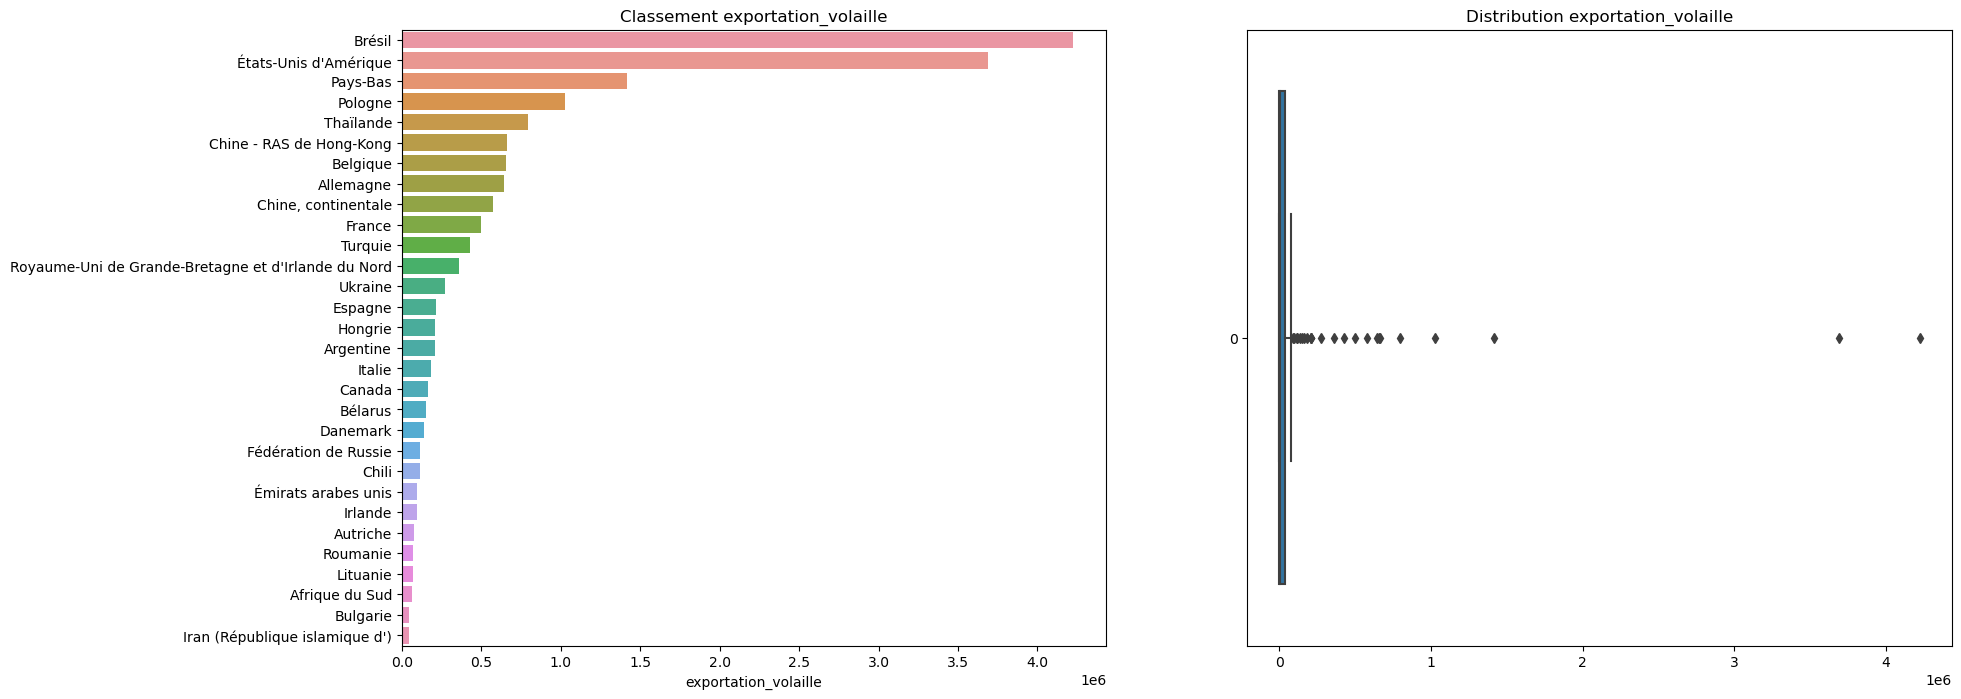

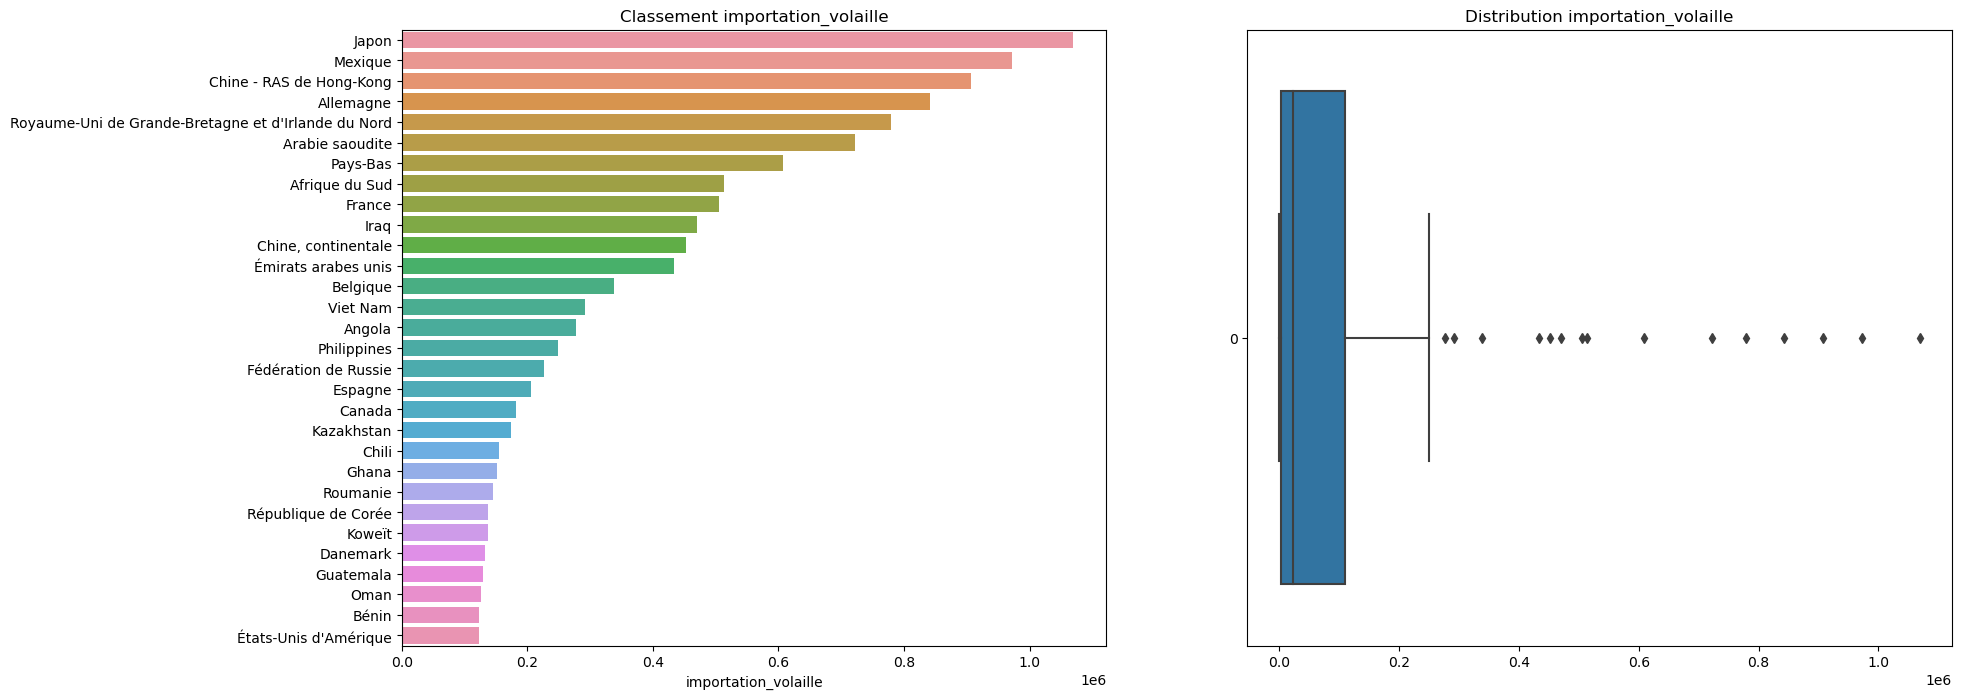

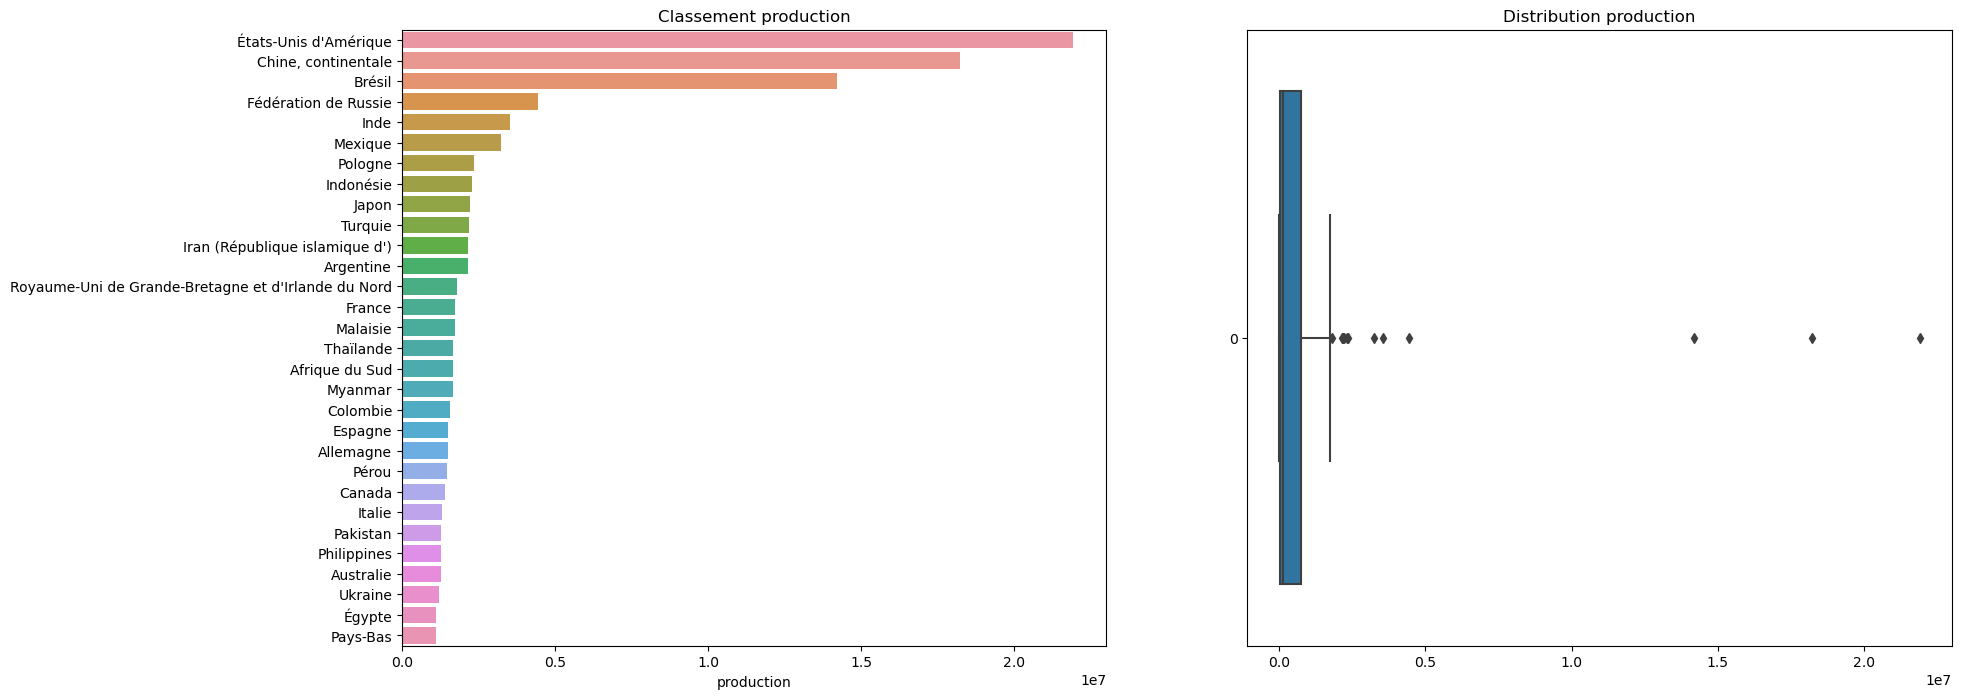

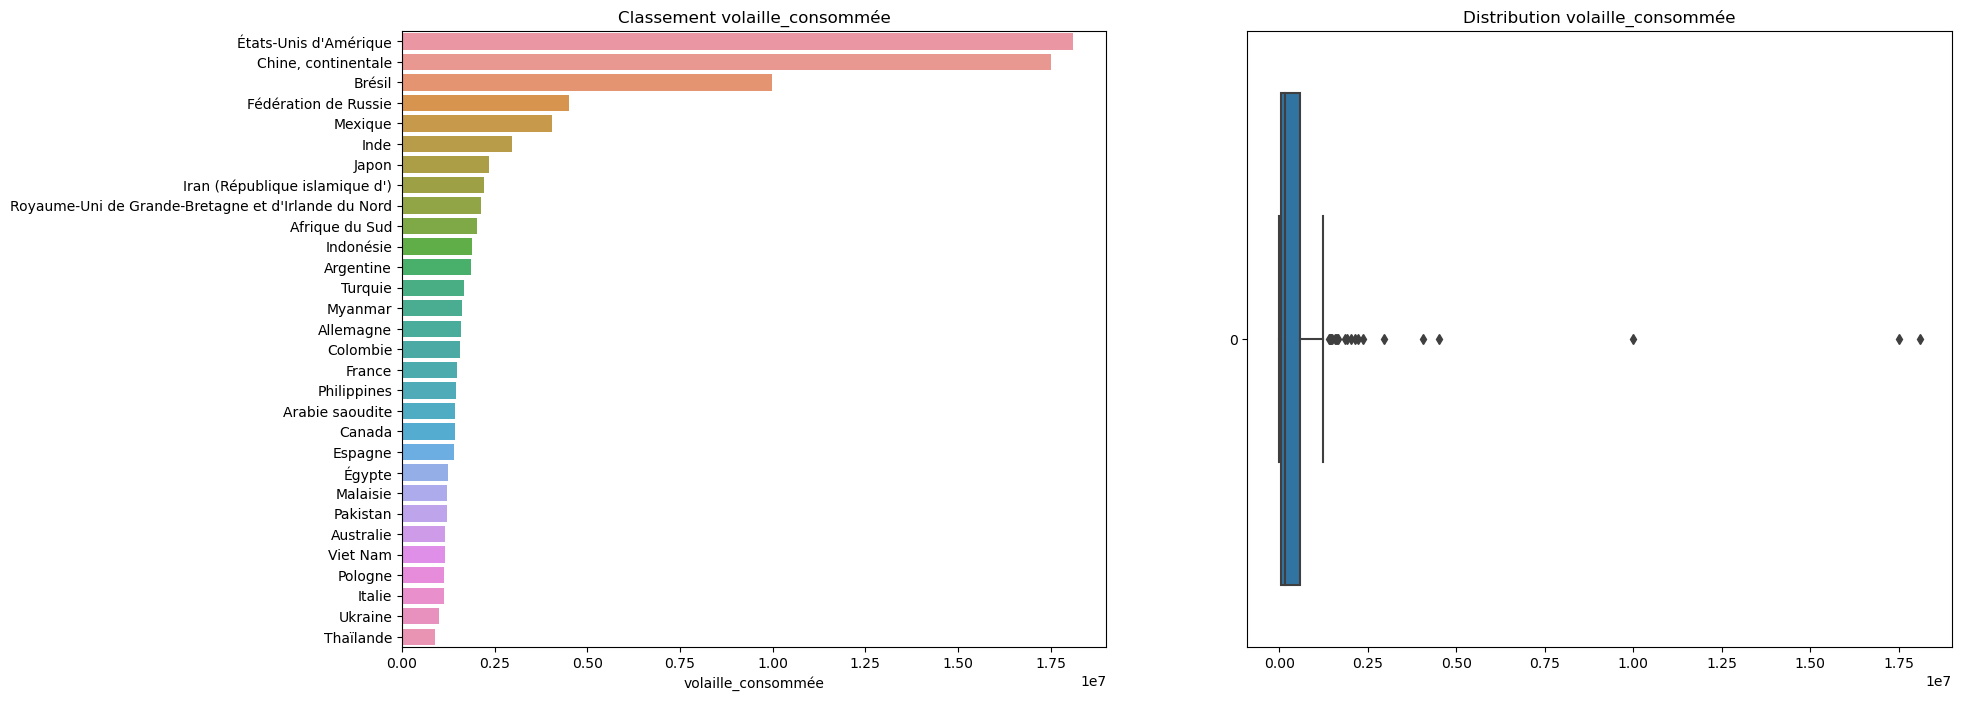

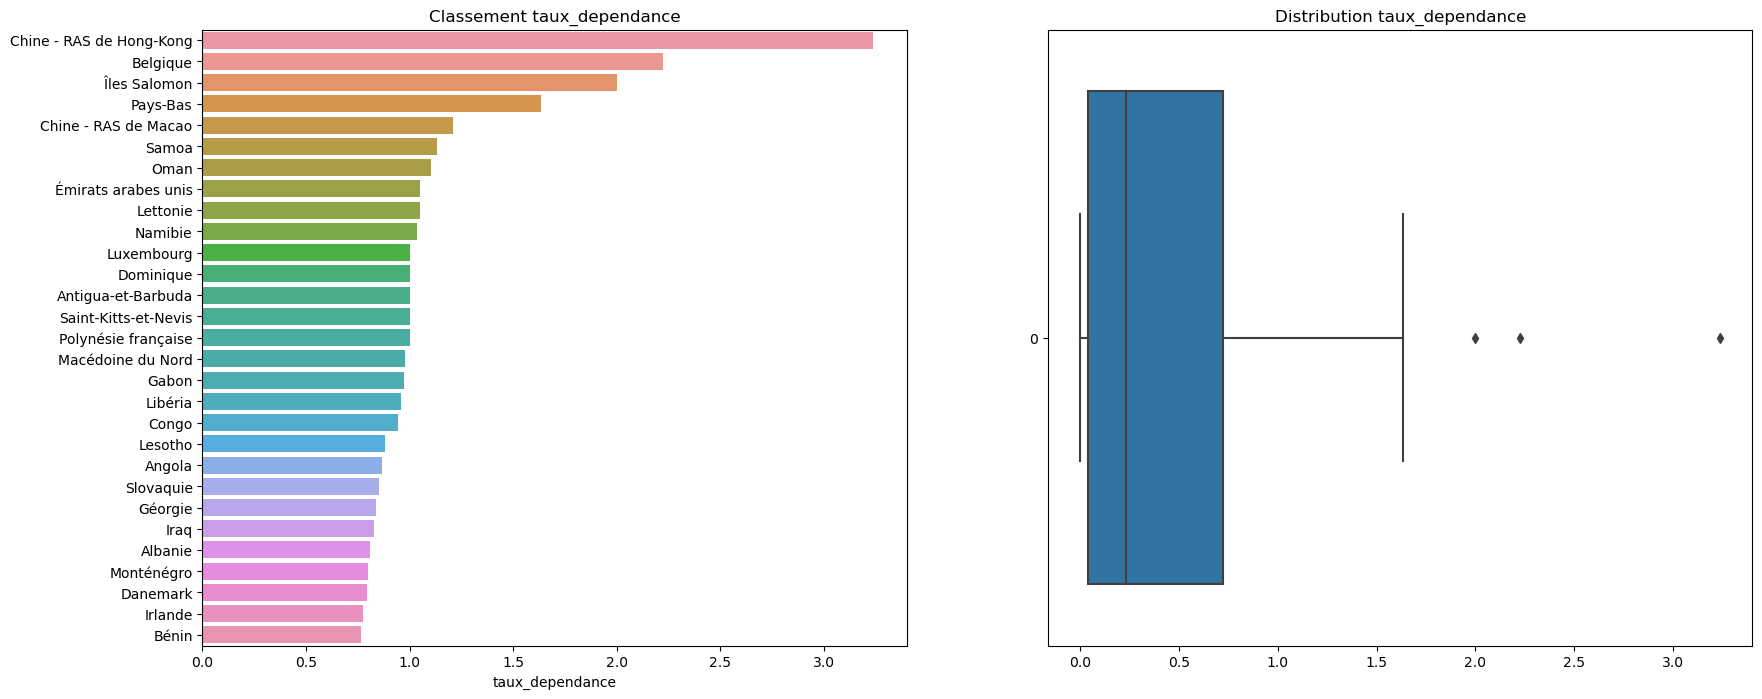

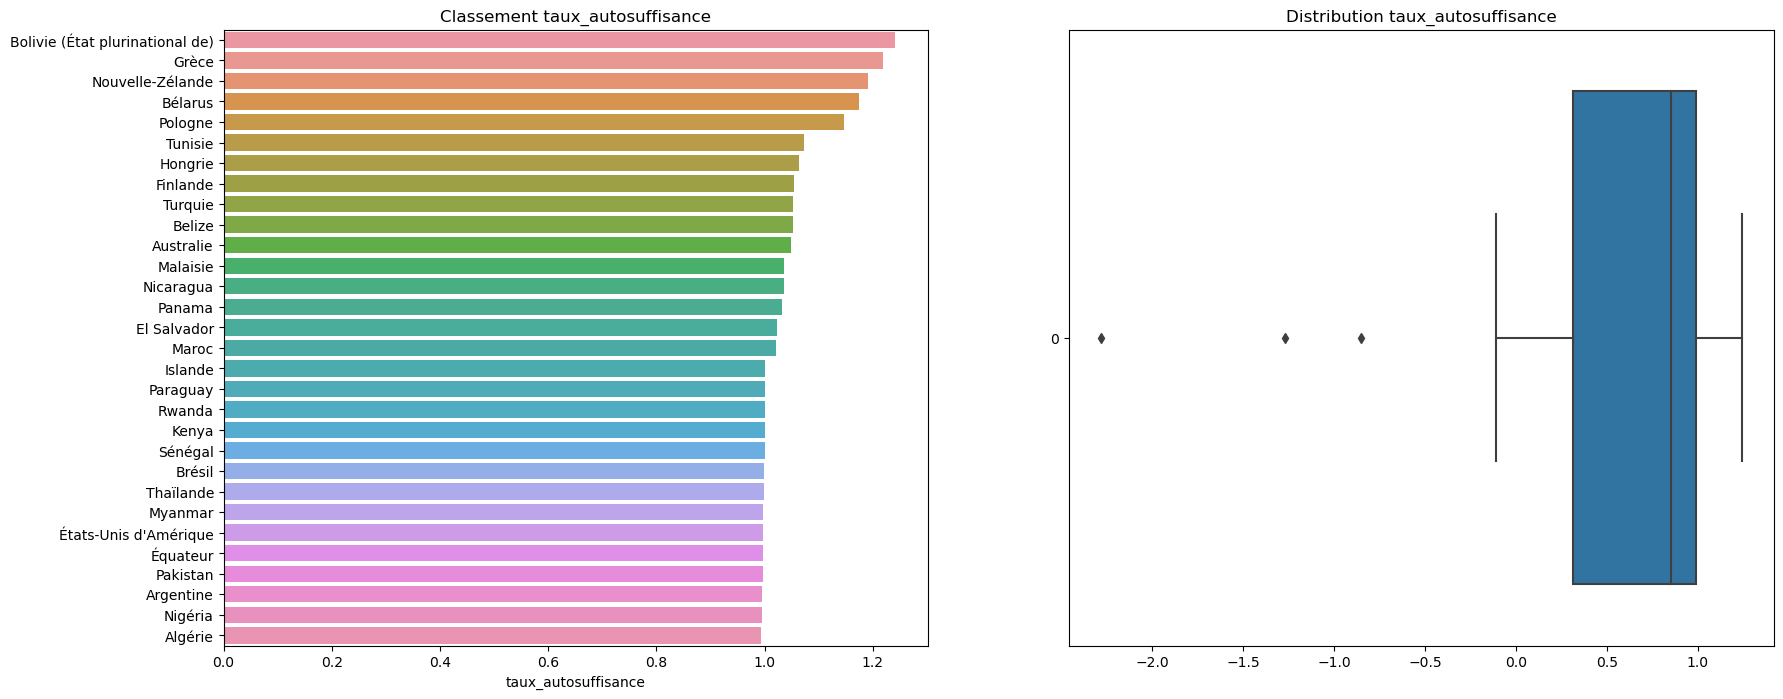

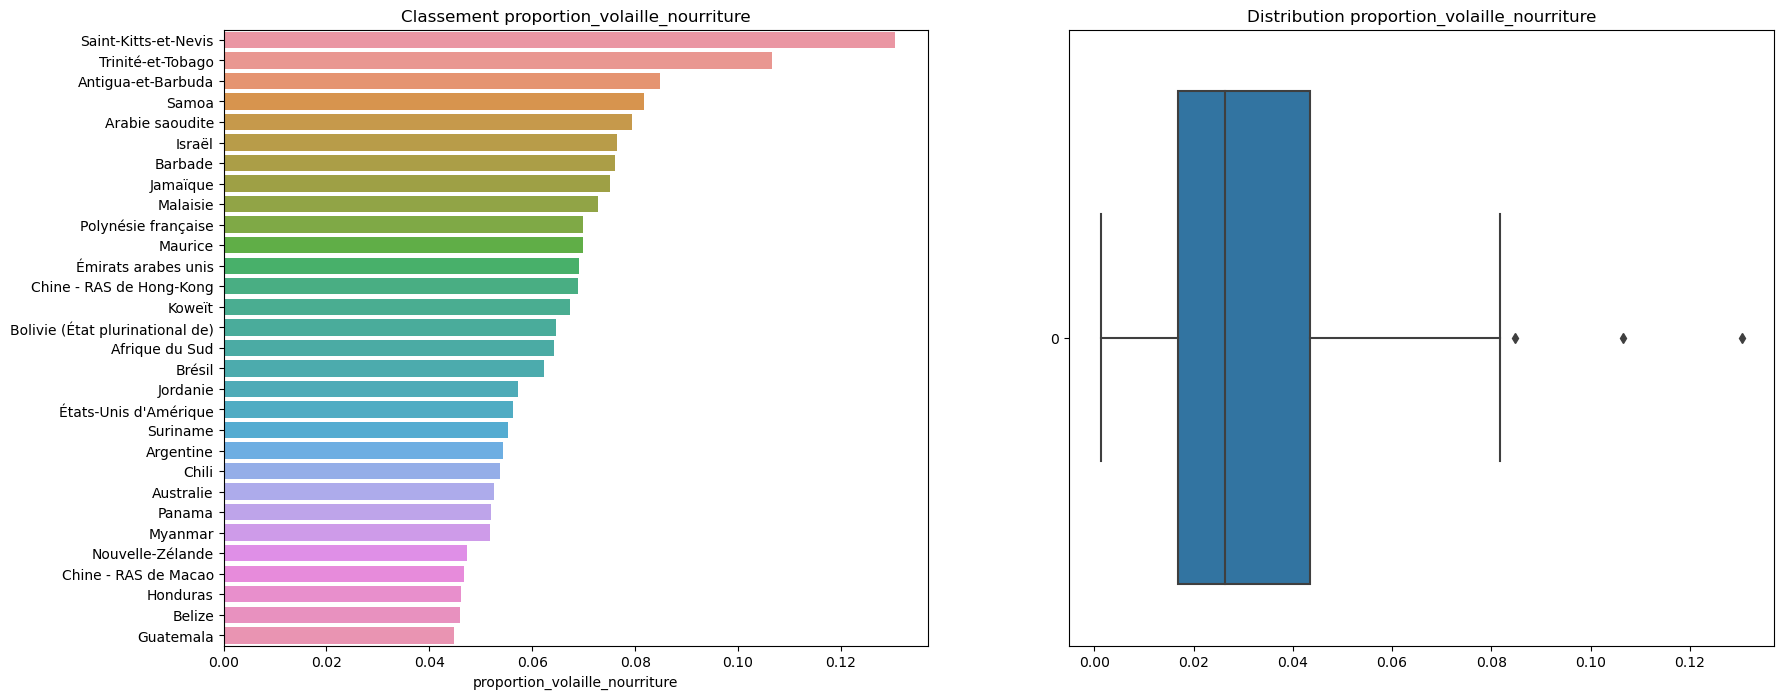

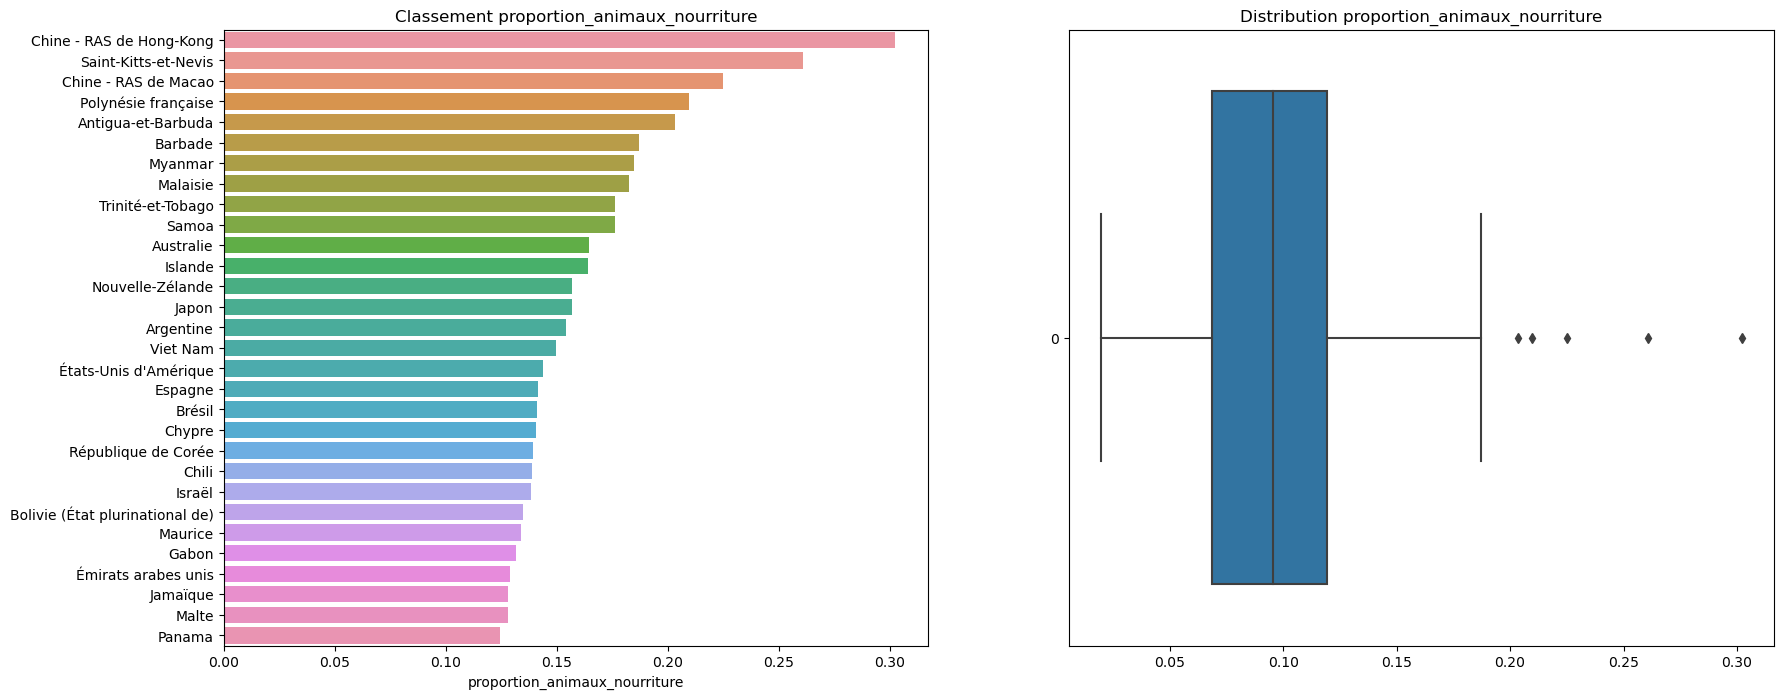

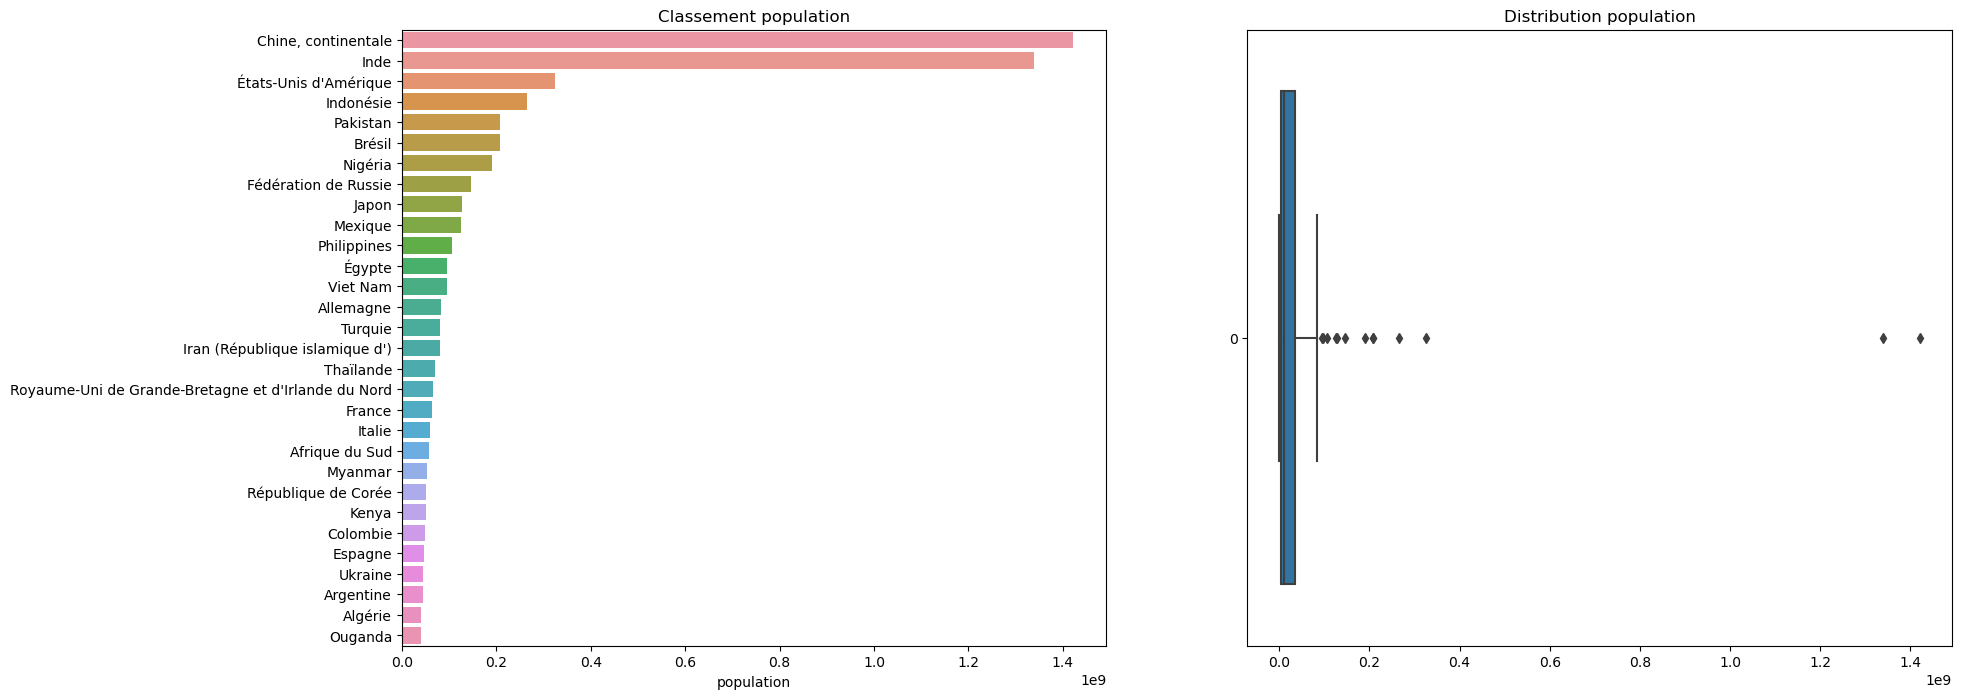

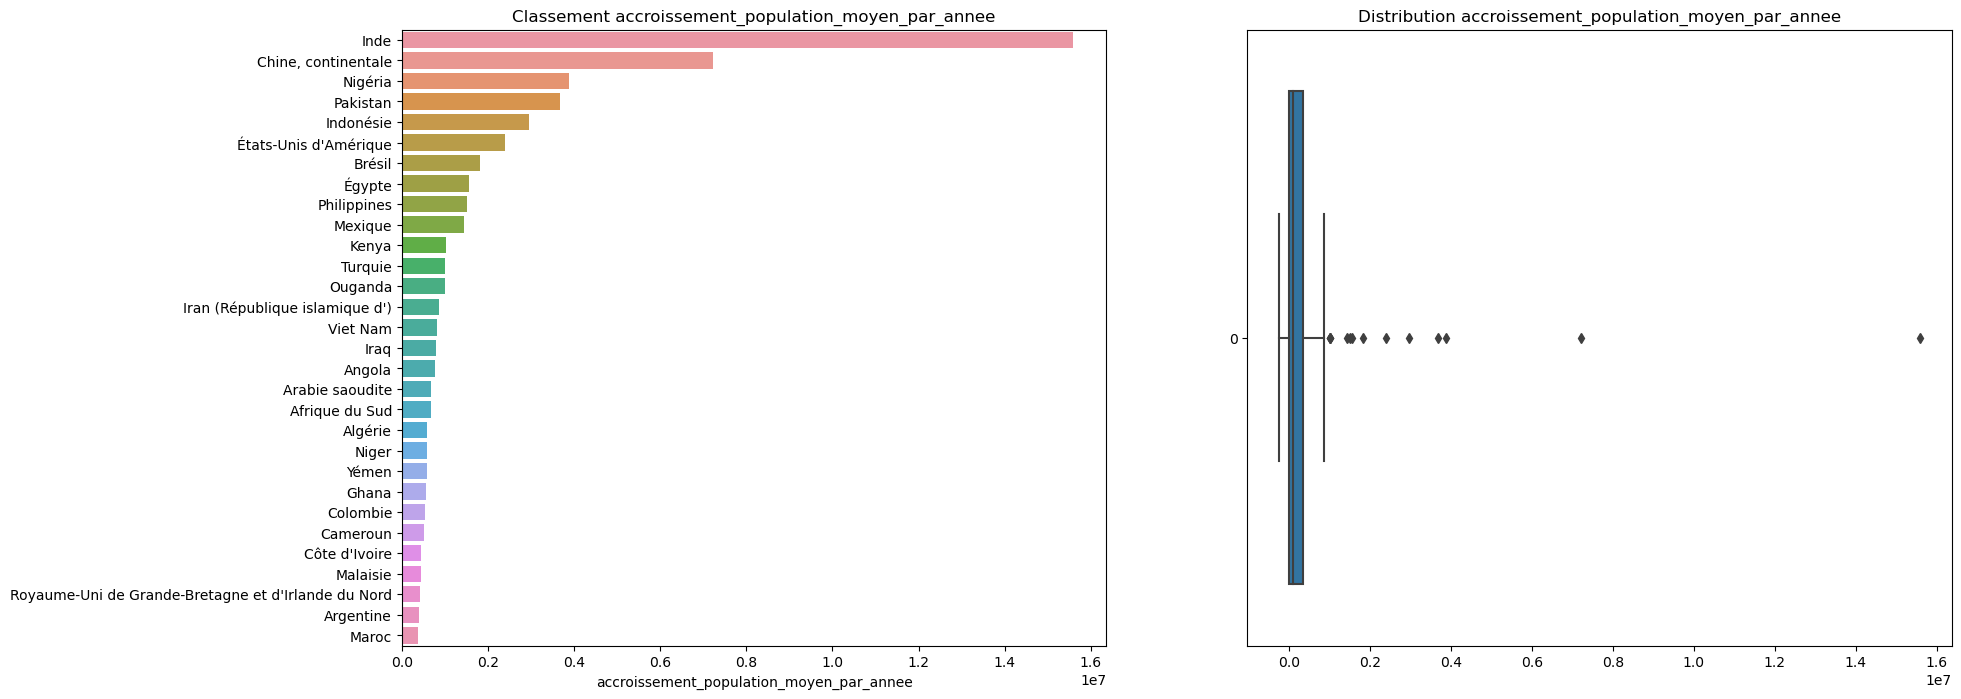

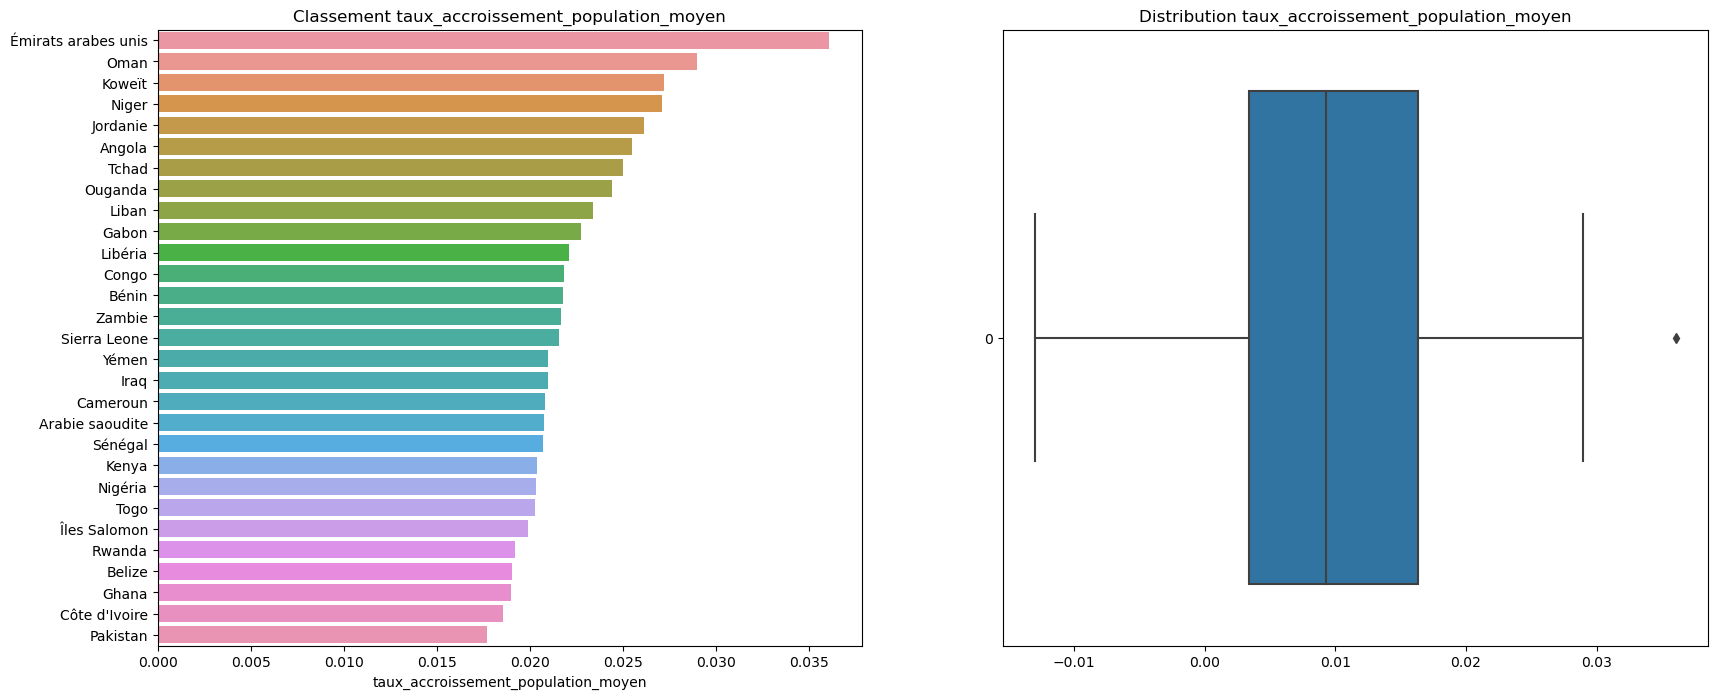

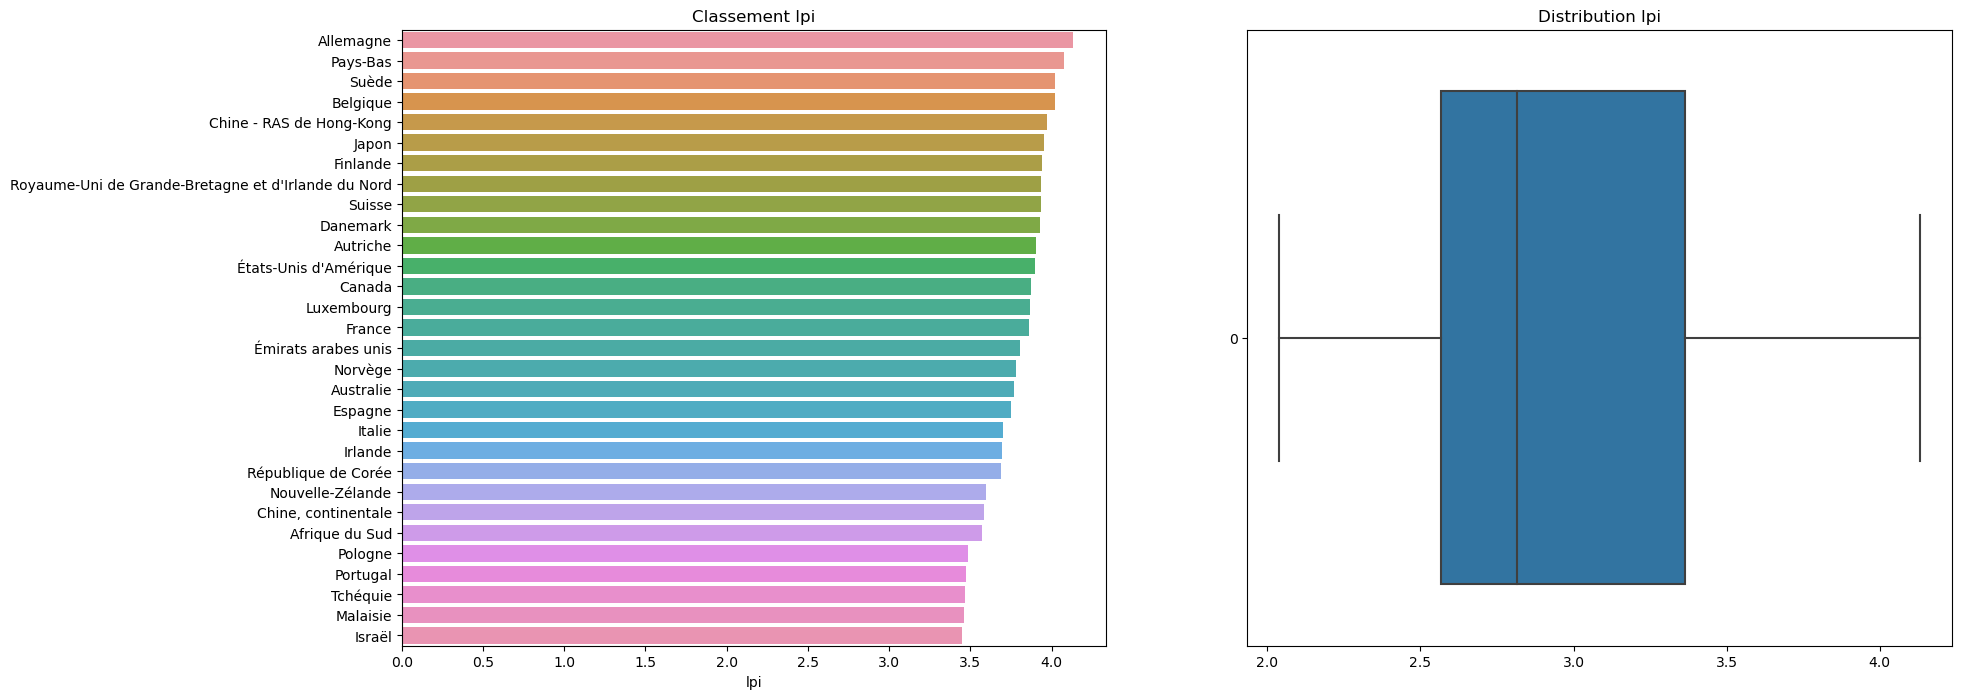

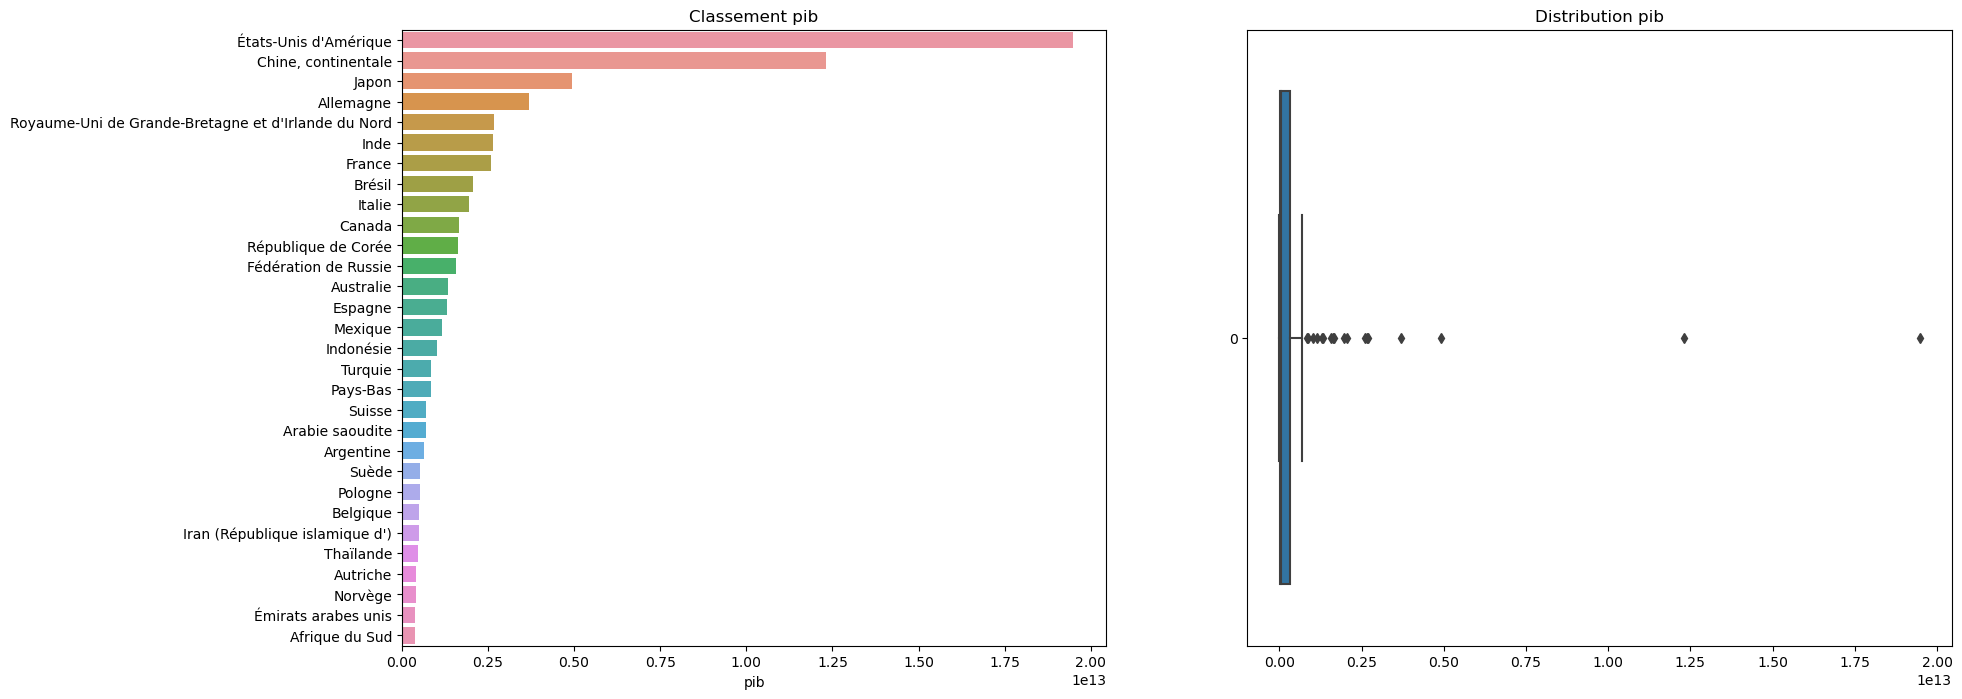

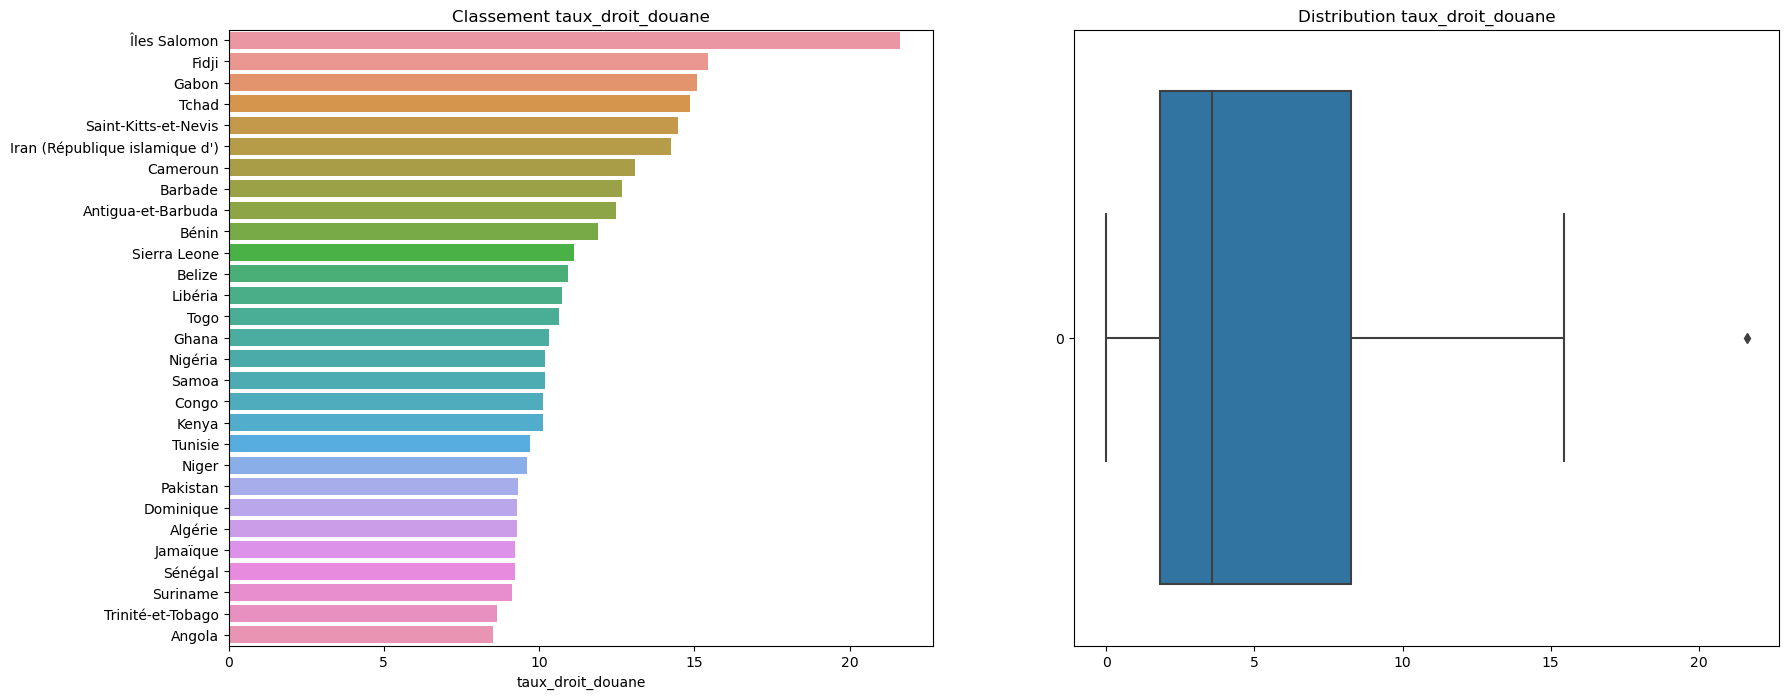

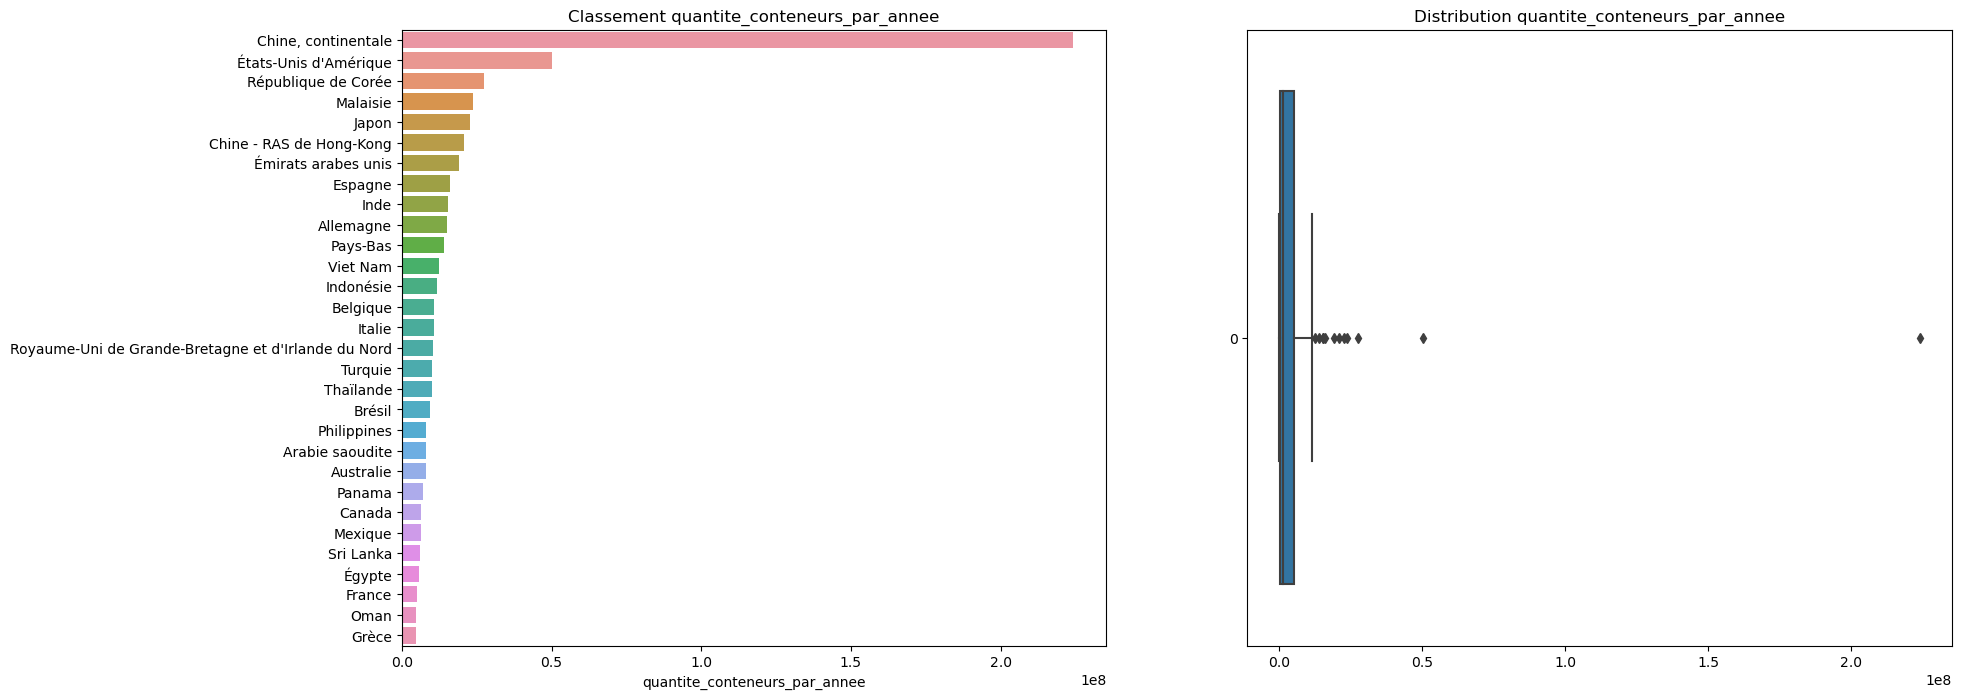

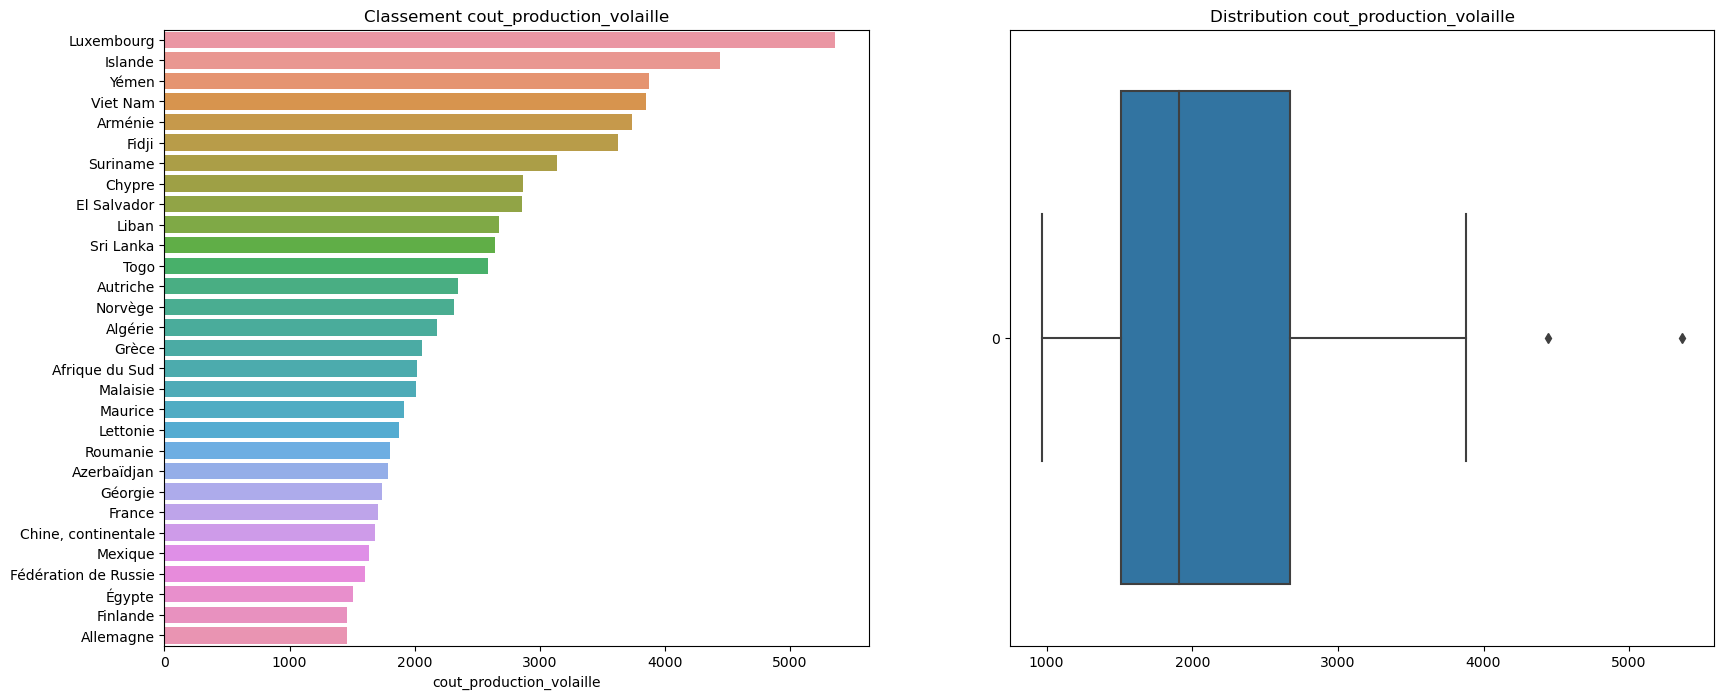

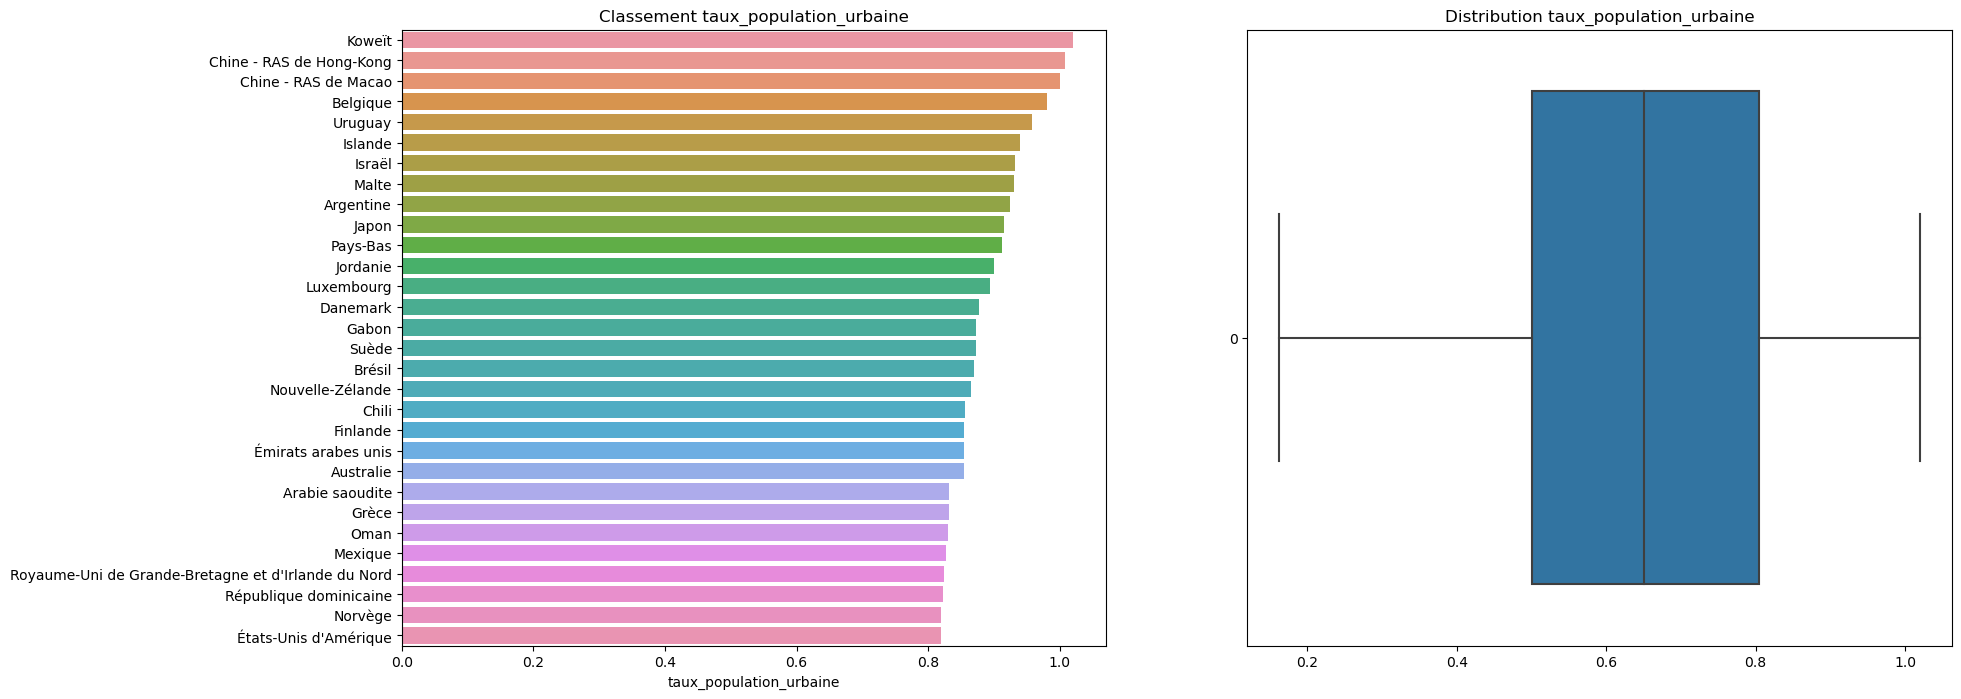

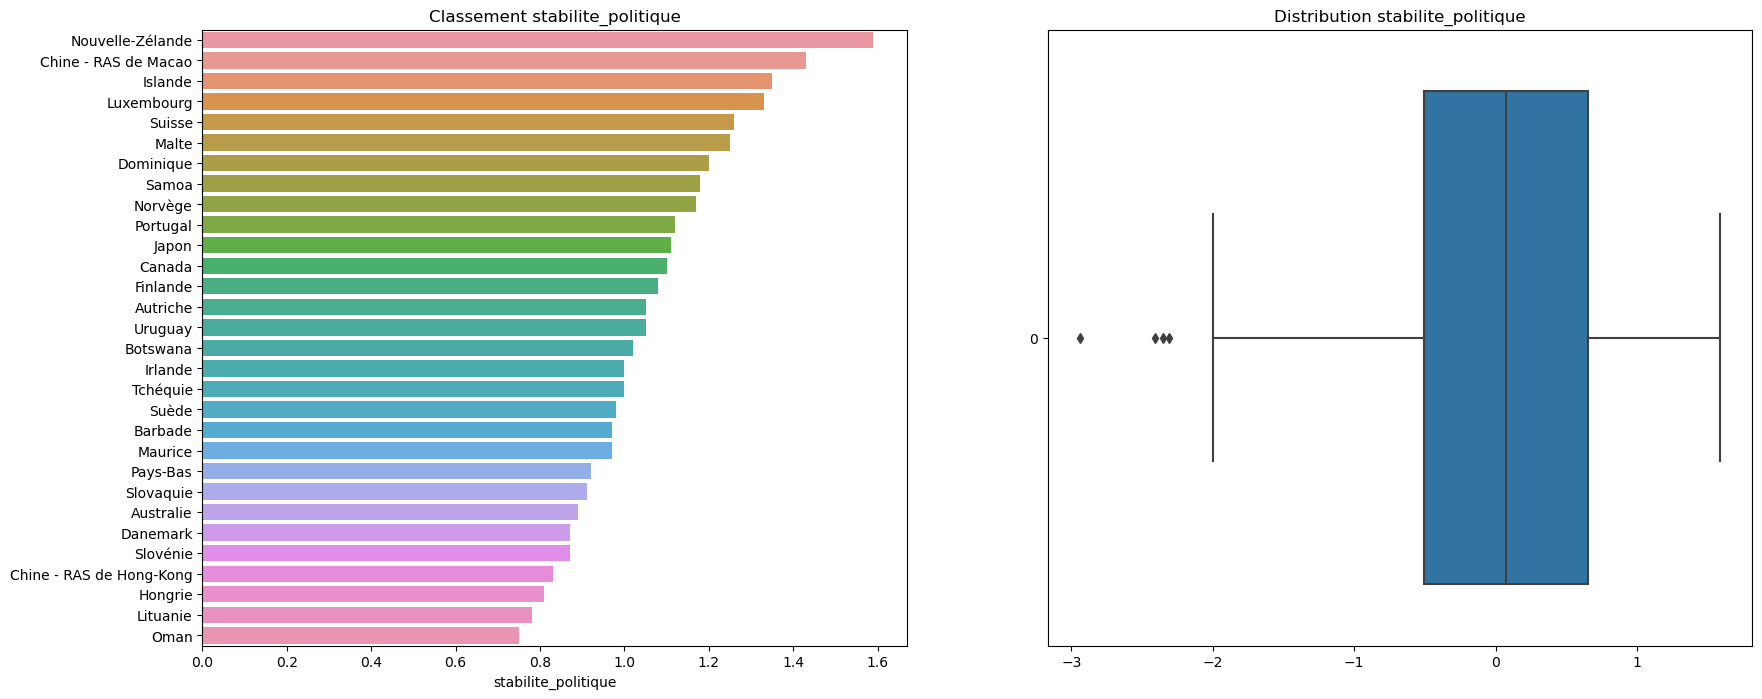

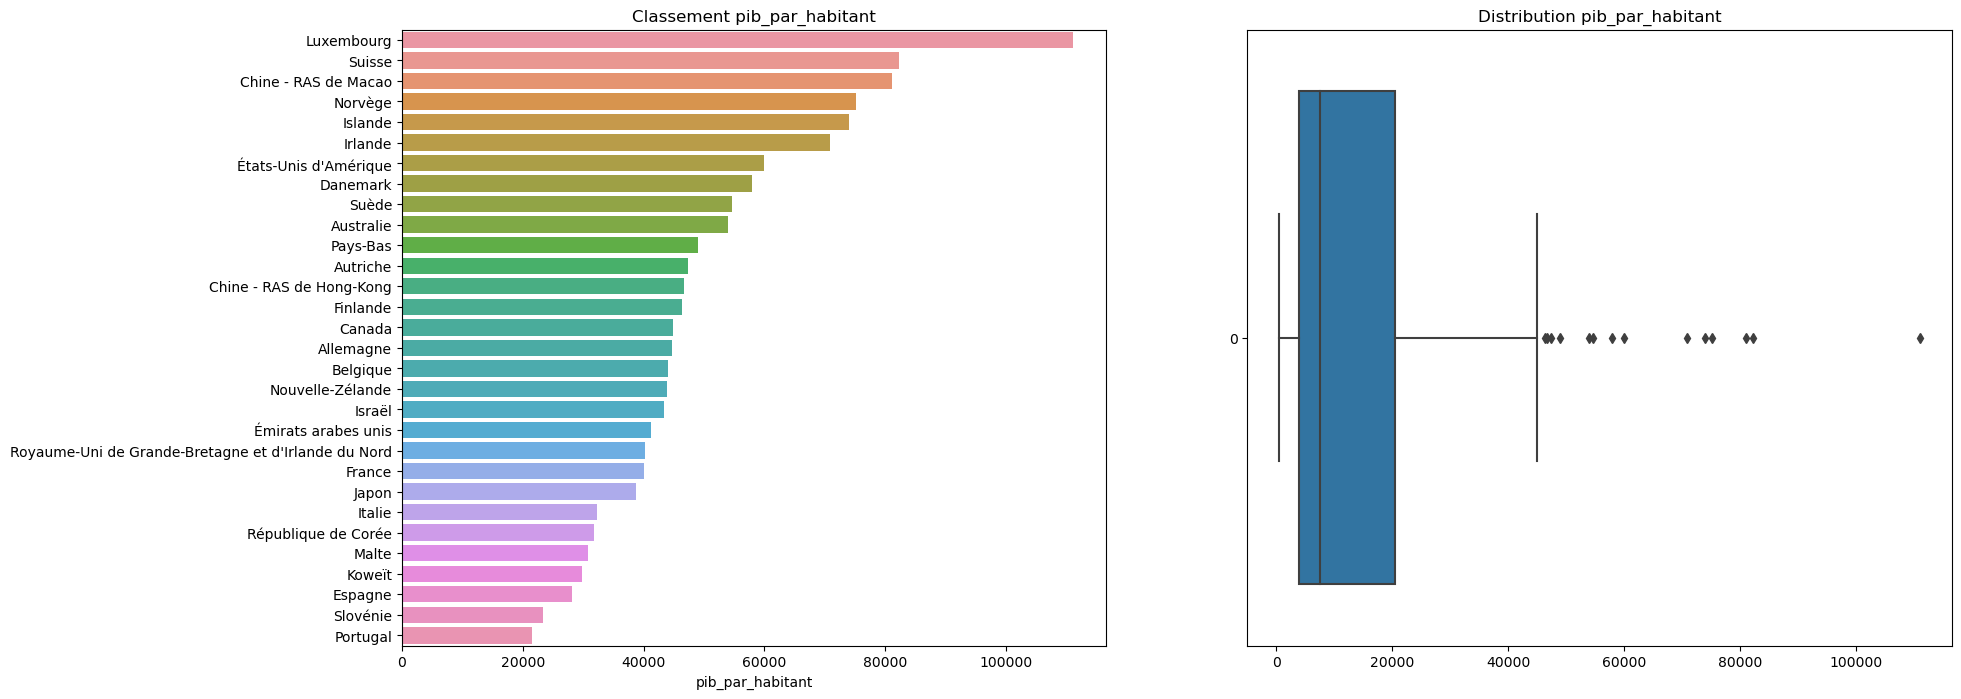

In [363]:
for var in df.drop(columns=['pays', 'classement_consommation']).columns:
    G = df.sort_values(var, ascending = False).head(30).reset_index(drop=True)
    
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.title(f"Classement {var}")
    sns.barplot(data=G, y=G['pays'], x=G[var], orient='h')
    plt.ylabel(None)
    
    plt.subplot(1,2,2)
    plt.title(f"Distribution {var}")
    sns.boxplot(data=df[var], orient='h')
    plt.show()

Des valeurs aberrantes peuvent déséquilibrer la distribution surtout pour les variables exportation_volaille, production, volaille consommée, population, accroissement_population_par_annee, pib et quantité_conteneurs par année.

Il semblerait que les pays responsables de ce déséquilibre soit surtout Les Etats Unis, La Chine, Le Brésil et L'Inde.

### 2e Itération, Suppression des outliers et la variable cout de production volaille

L'ACP étant étant sensible aux outliers, on les supprime.

De plus, ces pays ne sont pas candidats pour l'implantation du nouveau marché. Ils sont autosuffisant à près de 100%, sont éloignés géographiquement et ne réunissent les conditions d'implantation d'un nouveau marché.

On supprime aussi la variable 'cout_production_volaille' car elle était composée à 70% de valeurs imputées potentiellement éloignées de la réalité.

In [364]:
# on enlève les outliers
outliers = df[df['pays'].isin(['Chine, continentale', 'Brésil', 'Inde', "États-Unis d'Amérique"])]
df = df.drop(outliers.index).reset_index(drop=True)

# suppression cout de production volaille
df = df.drop(columns='cout_production_volaille')

### K-Nearest Neighbors

Le K-Nearest Neighbors est un algorithme d'apprentissage supervisé utilisé pour la Régression ou la Classification. 
Ici, nous allons l'utiliser pour la Régression.  
Il permet de prédire une valeur à une variable en fonction de la valeurs de ces voisins les plus proches, c'est à dire les individus qui ont des valeurs similaires pour les autres variables.

Dans notre cas, il utilise la distance euclidienne entre les points (individus) pour mesurer la similarité entre les individus. 
On doit définir le nombre de voisins qu'on prendra en compte pour prédire la valeurs de la variable cible.

Ici, je vais l'utiliser pour imputer les valeurs manquantes grâce à l'objet KNNImputer de sklearn.

In [365]:
df2 = df.copy()

knn_imputer = KNNImputer(n_neighbors=5)

X = df2.drop(columns= ['pays', 'classement_consommation'])

In [366]:
# on standardise avant imputation KNN

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [367]:
# imputation par le KNN sur les données standardisées
df_knn = knn_imputer.fit_transform(X_scaled)

colonne_transform = ['exportation_volaille', 'importation_volaille', 'production',
       'volaille_consommée', 'taux_dependance', 'taux_autosuffisance',
       'proportion_volaille_nourriture', 'proportion_animaux_nourriture',
       'population', 'accroissement_population_moyen_par_annee',
       'taux_accroissement_population_moyen', 'lpi', 'pib',
       'taux_droit_douane', 'quantite_conteneurs_par_annee',
       'taux_population_urbaine',
       'stabilite_politique', 'pib_par_habitant']

In [368]:
# Inversion de la standardisation et création du df avec valeurs manquantes imputées par le knn
df2[colonne_transform]=scaler.inverse_transform(df_knn)
df2

pays  exportation_volaille  \
0                                       Afrique du Sud             63,000.00   
1                                              Albanie                  0.00   
2                                              Algérie                  0.00   
3                                            Allemagne            646,000.00   
4                                               Angola                  0.00   
5                                   Antigua-et-Barbuda                  0.00   
6                                      Arabie saoudite             10,000.00   
7                                            Argentine            207,000.00   
8                                              Arménie                  0.00   
9                                            Australie             42,000.00   
10                                            Autriche             78,000.00   
11                                         Azerbaïdjan                  0.00   
12                                             Barbade                  0.00   
13                                            Belgique            656,000.00   
14                                              Belize                  0.00   
15                     Bolivie (État plurinational de)              1,000.00   
16                                  Bosnie-Herzégovine              8,000.00   
17                                            Botswana                  0.00   
18                                            Bulgarie             45,000.00   
19                                             Bélarus            152,000.00   
20                                               Bénin                  0.00   
21                                            Cameroun                  0.00   
22                                              Canada            163,000.00   
23                                               Chili            115,000.00   
24                            Chine - RAS de Hong-Kong            663,000.00   
25                                Chine - RAS de Macao                  0.00   
26                                              Chypre              1,000.00   
27                                            Colombie              2,000.00   
28                                               Congo                  0.00   
29                                               Congo                  0.00   
30                                          Costa Rica              3,000.00   
31                                             Croatie             17,000.00   
32                                       Côte d'Ivoire                  0.00   
33                                            Danemark            139,000.00   
34                                           Dominique                  0.00   
35                                         El Salvador              2,000.00   
36                                             Espagne            212,000.00   
37                                             Estonie             11,000.00   
38                                            Eswatini                  0.00   
39                                               Fidji                  0.00   
40                                            Finlande             12,000.00   
41                                              France            501,000.00   
42                                Fédération de Russie            115,000.00   
43                                               Gabon                  0.00   
44                                               Ghana                  0.00   
45                                               Grèce             29,000.00   
46                                           Guatemala              7,000.00   
47                                              Guyana                  0.00   
48                                             Géorgie              5,000.00   
49                                            Hond

#### Vérification de la cohérence de l'imputation : quantite_conteneurs_par_annee 
Comparaison quantite_conteneurs_par_annee de base (gauche) avec quantite_conteneurs_par_annee imputée avec le KNN (droite).

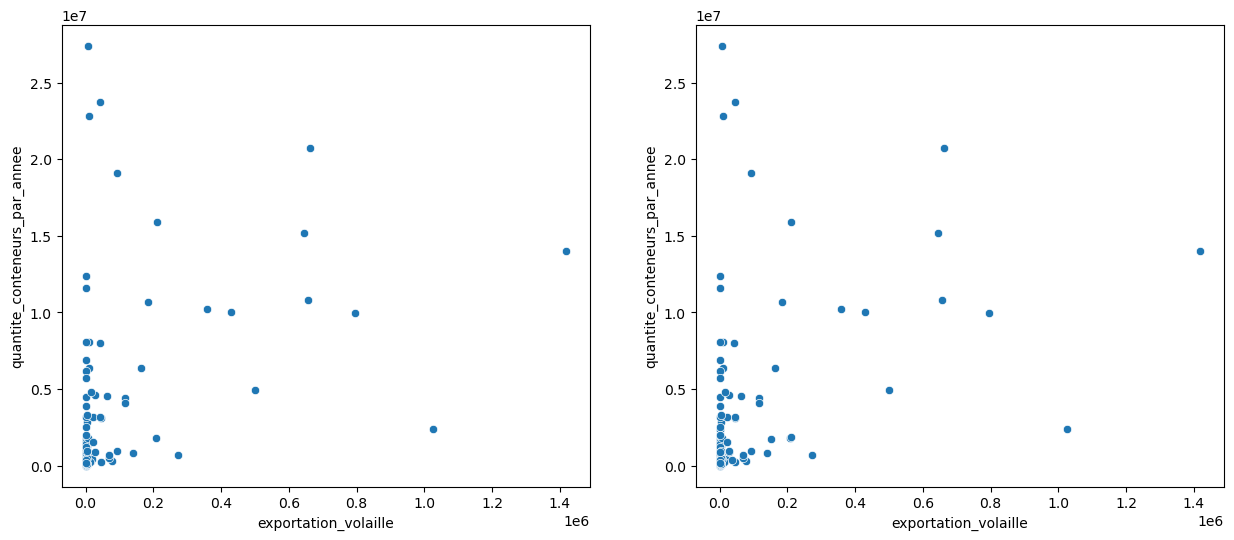

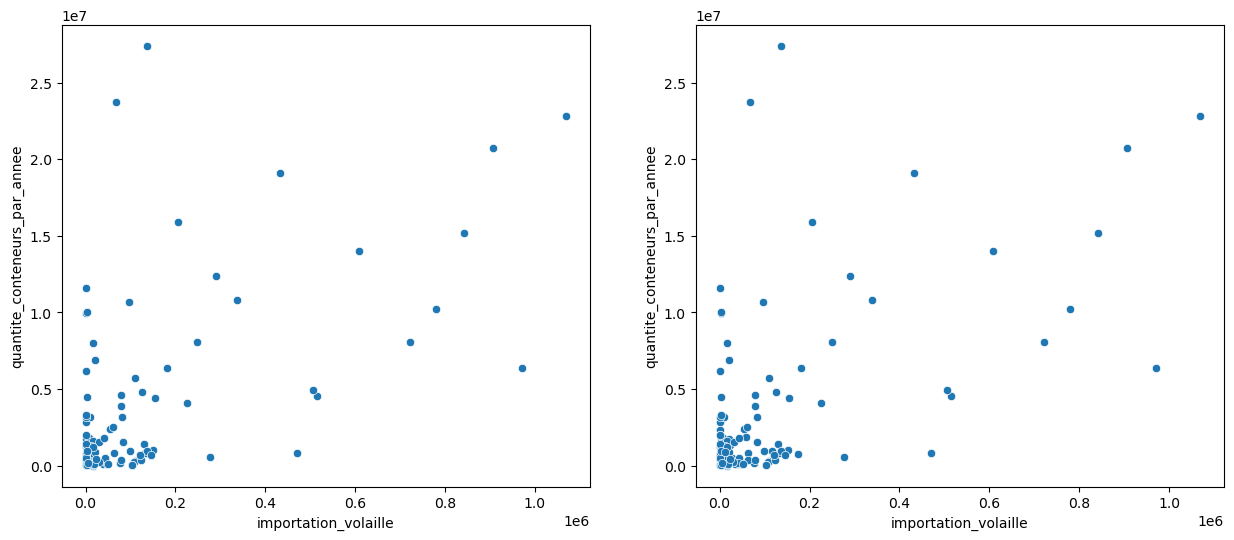

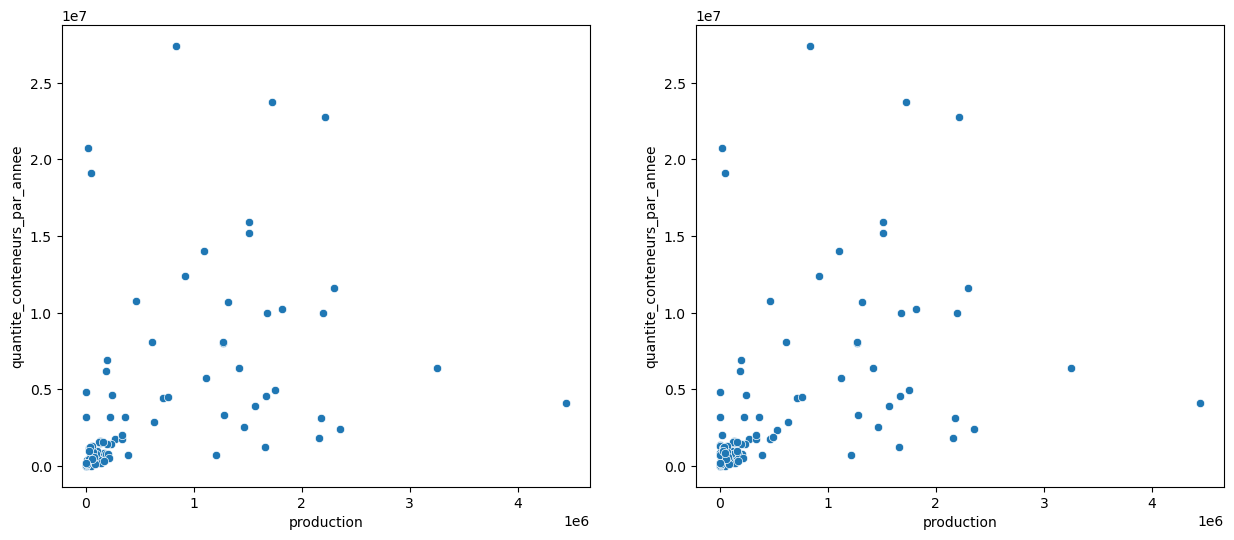

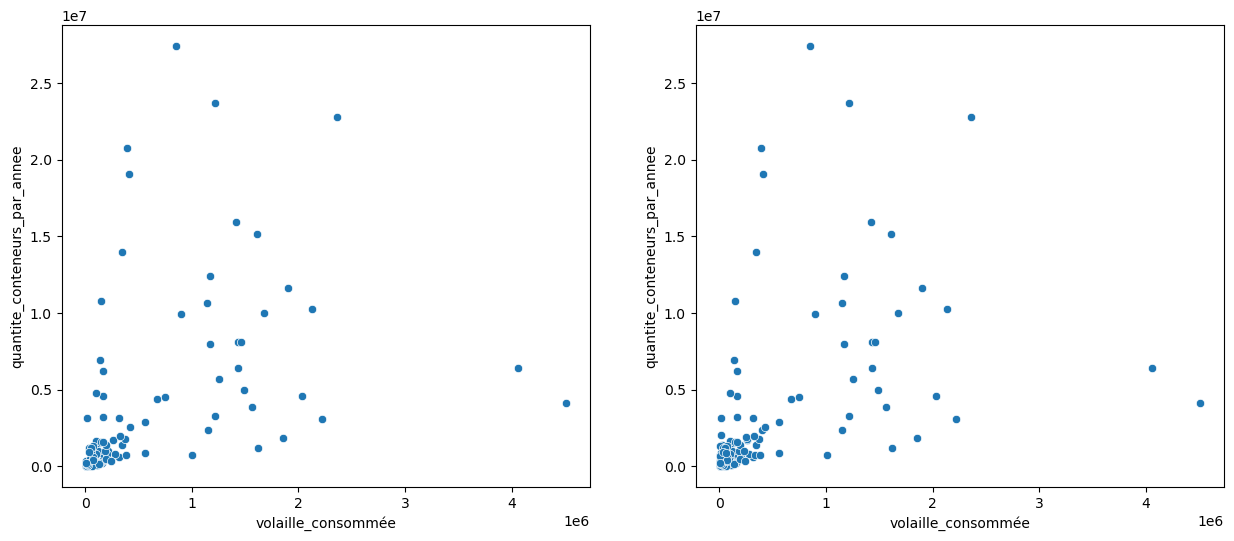

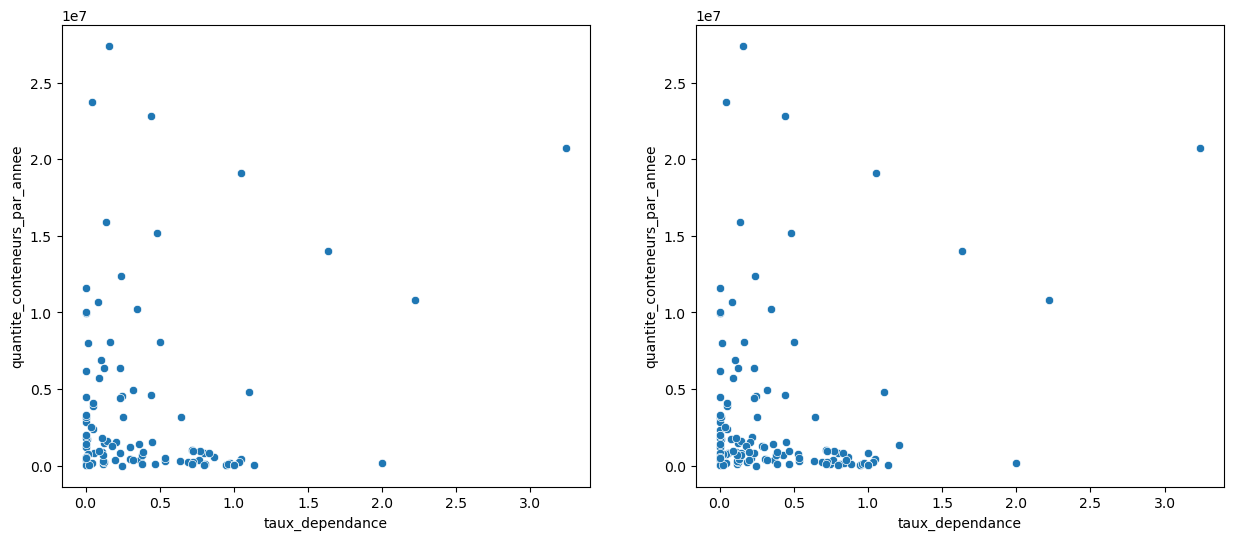

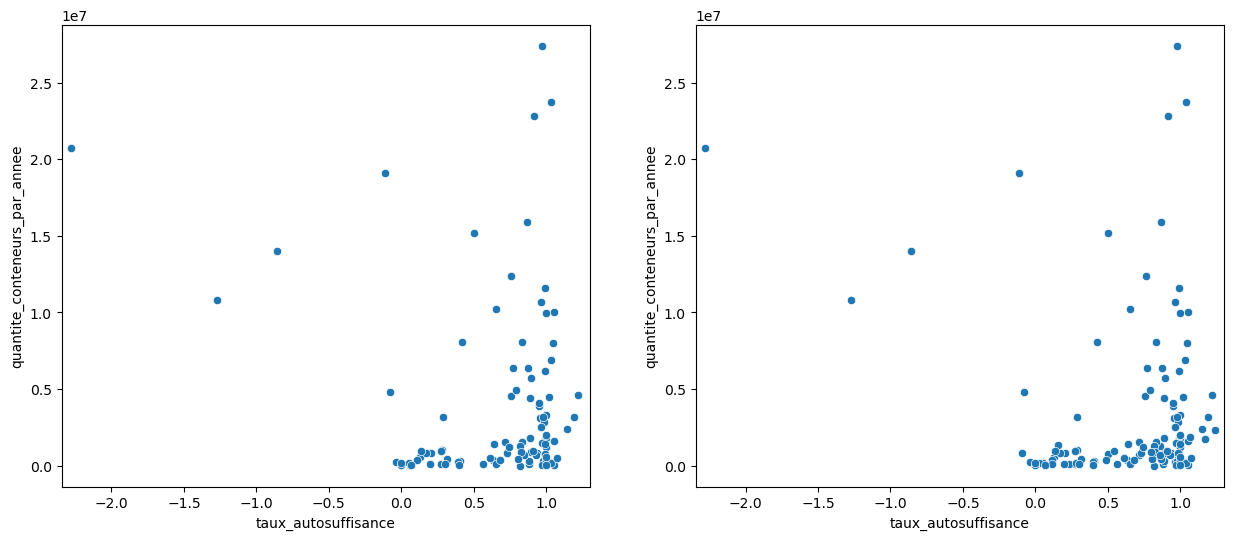

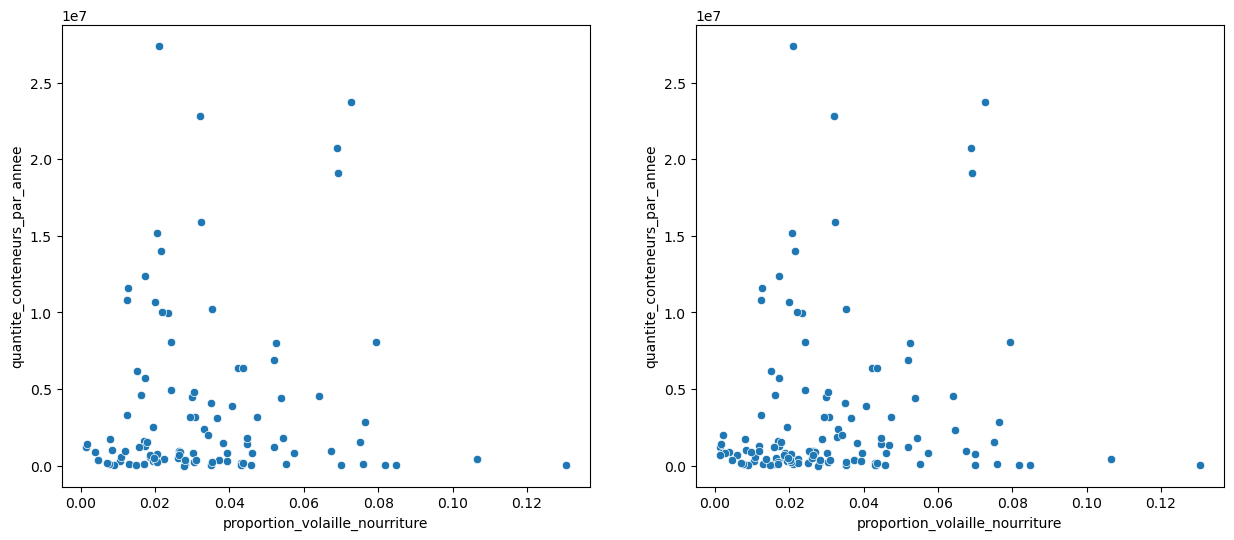

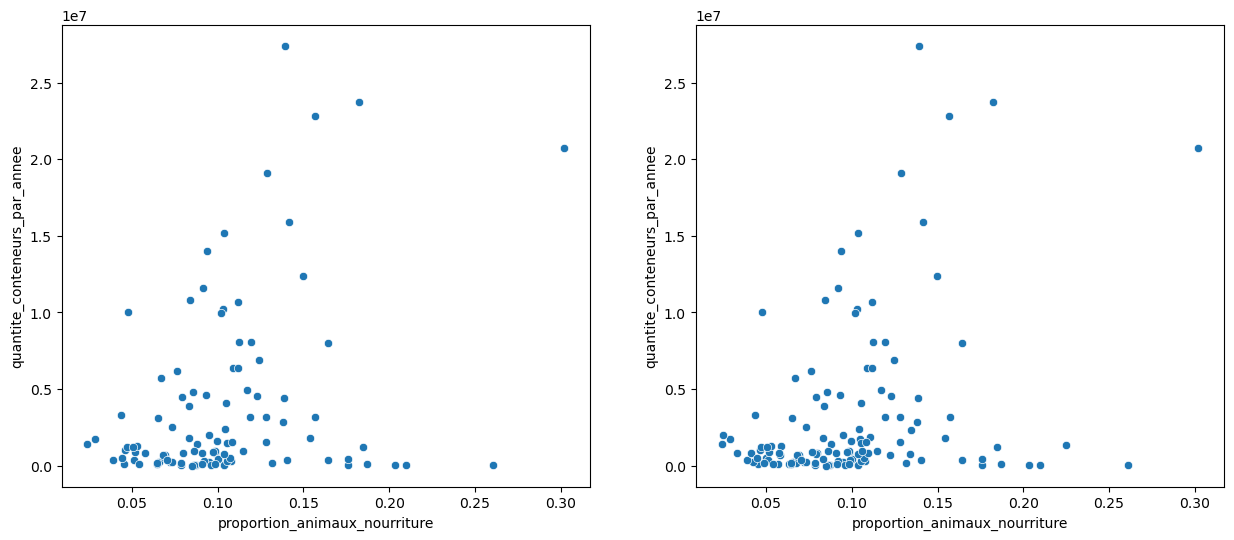

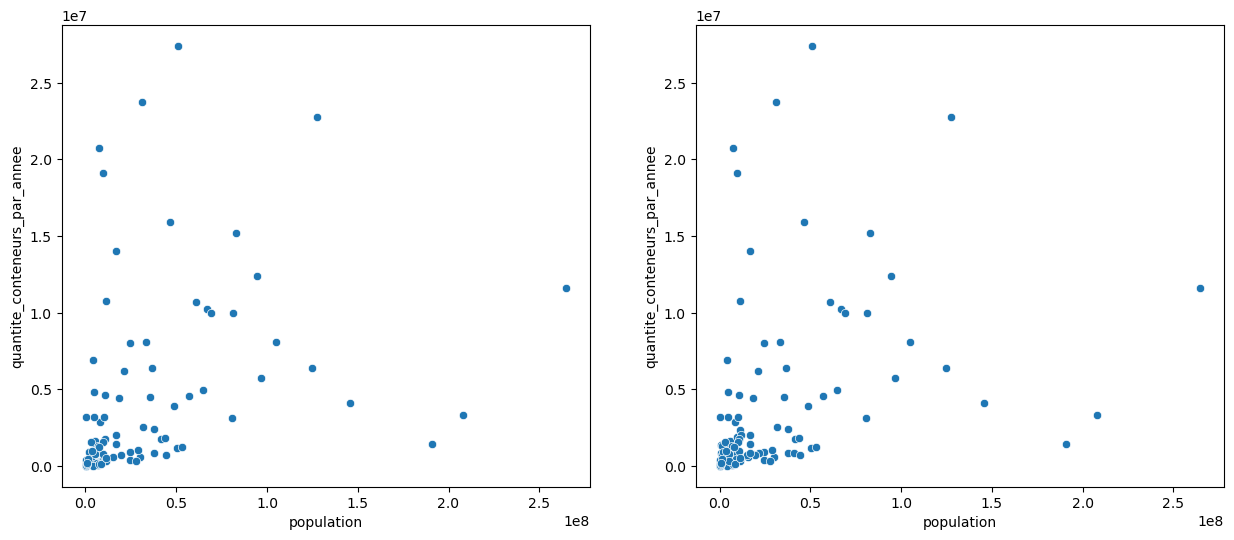

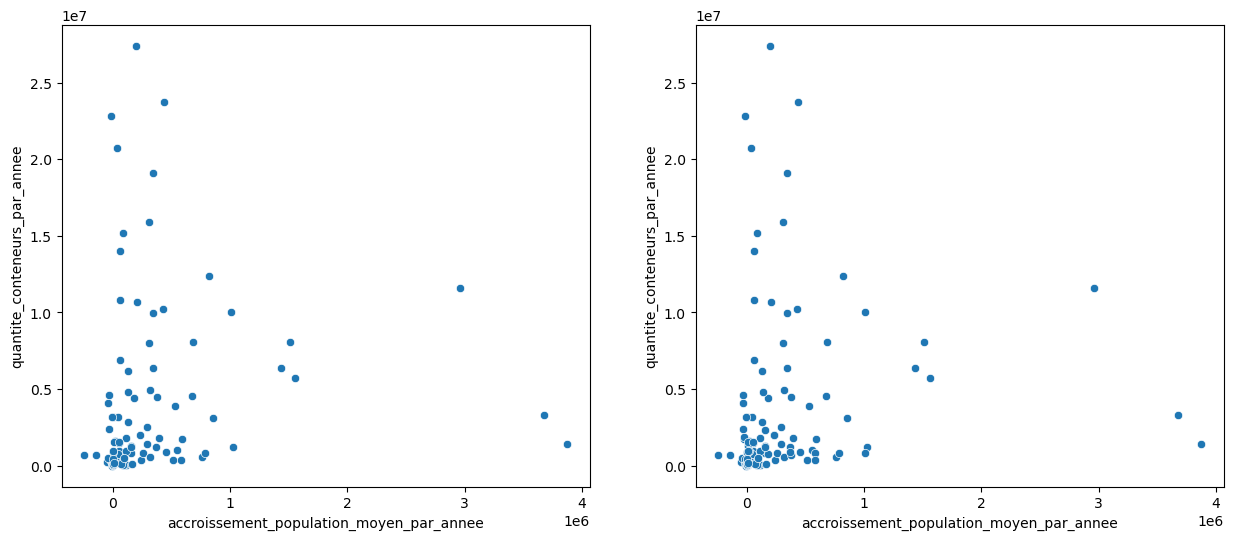

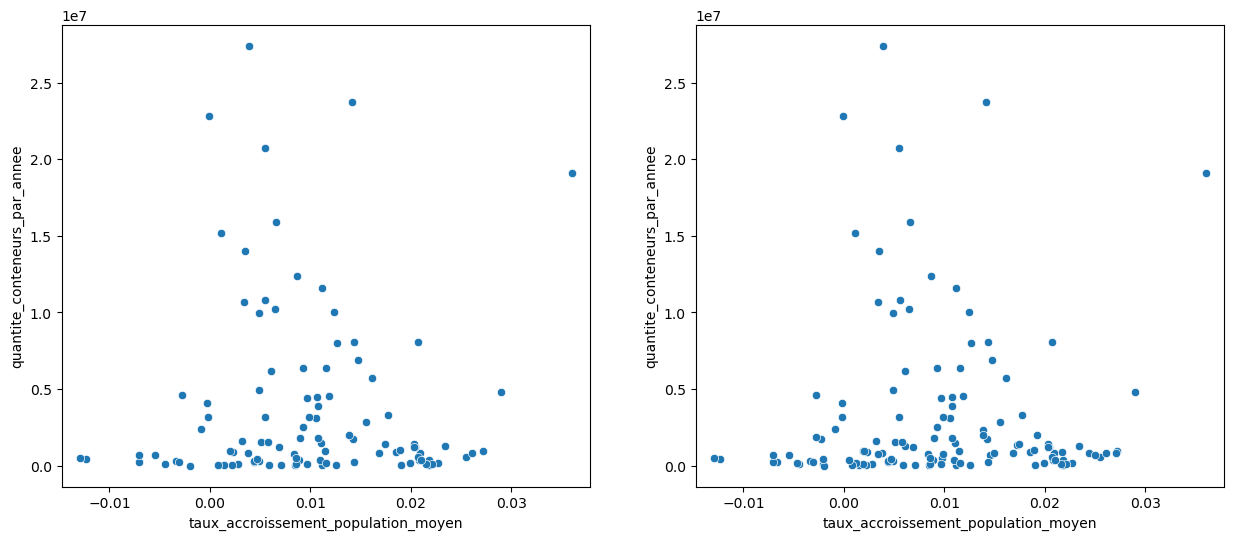

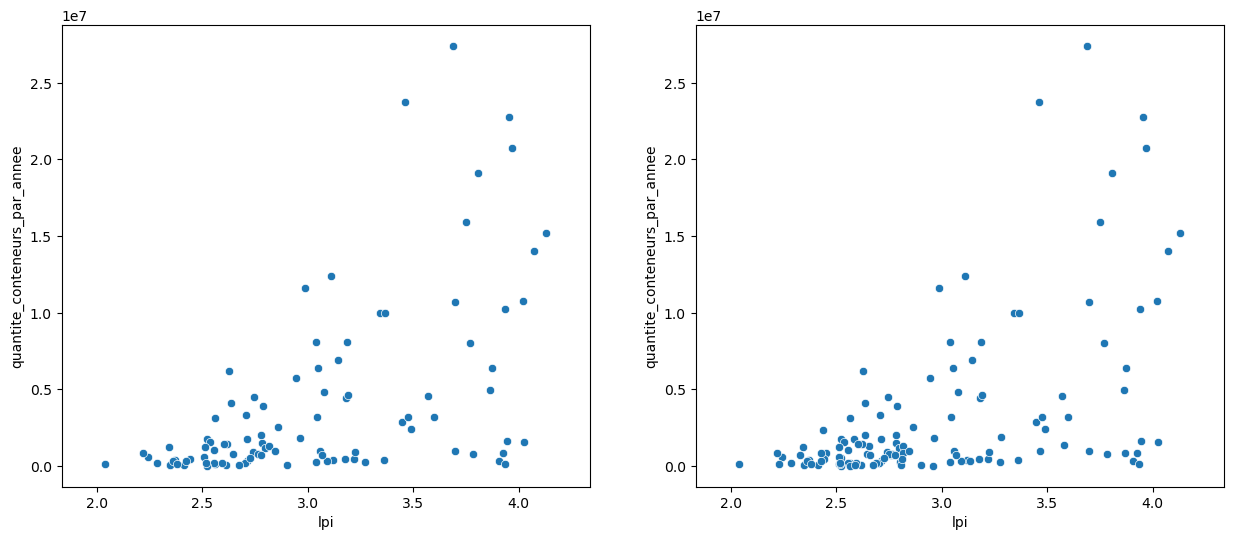

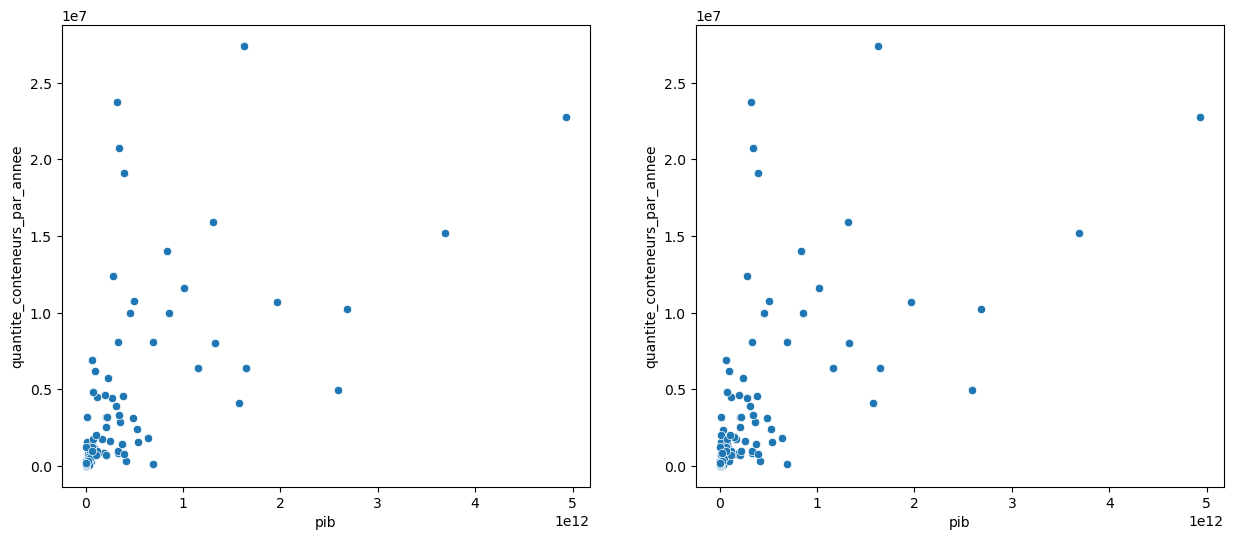

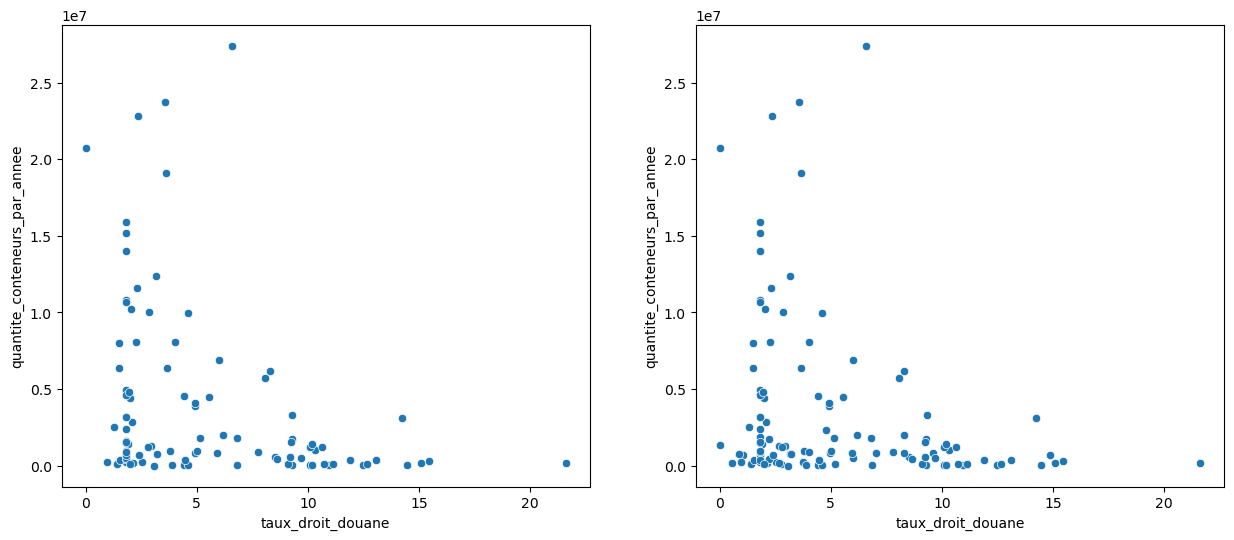

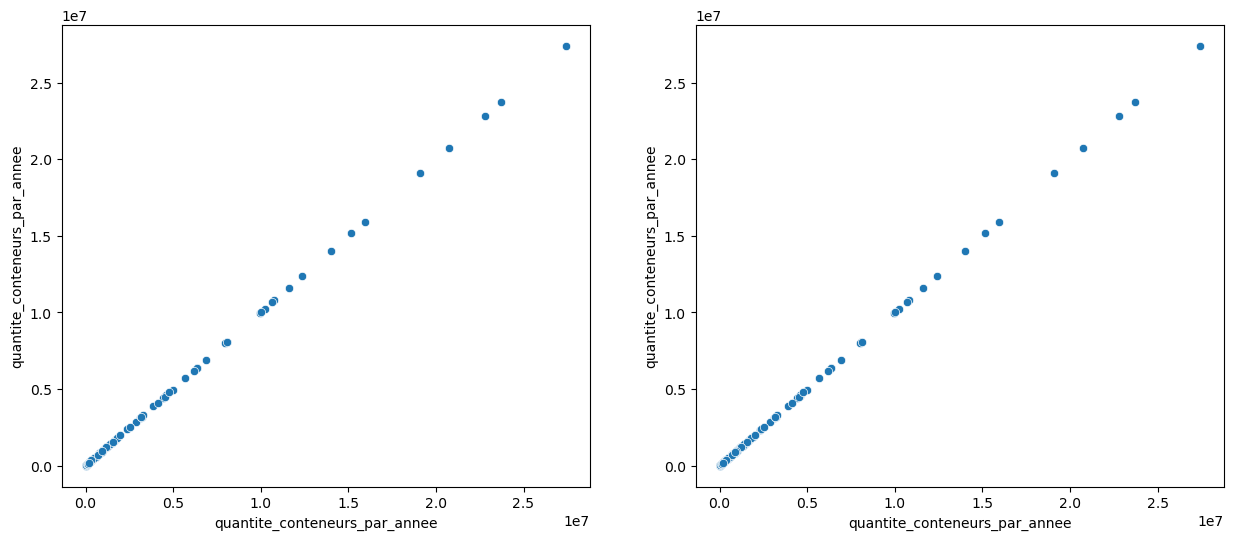

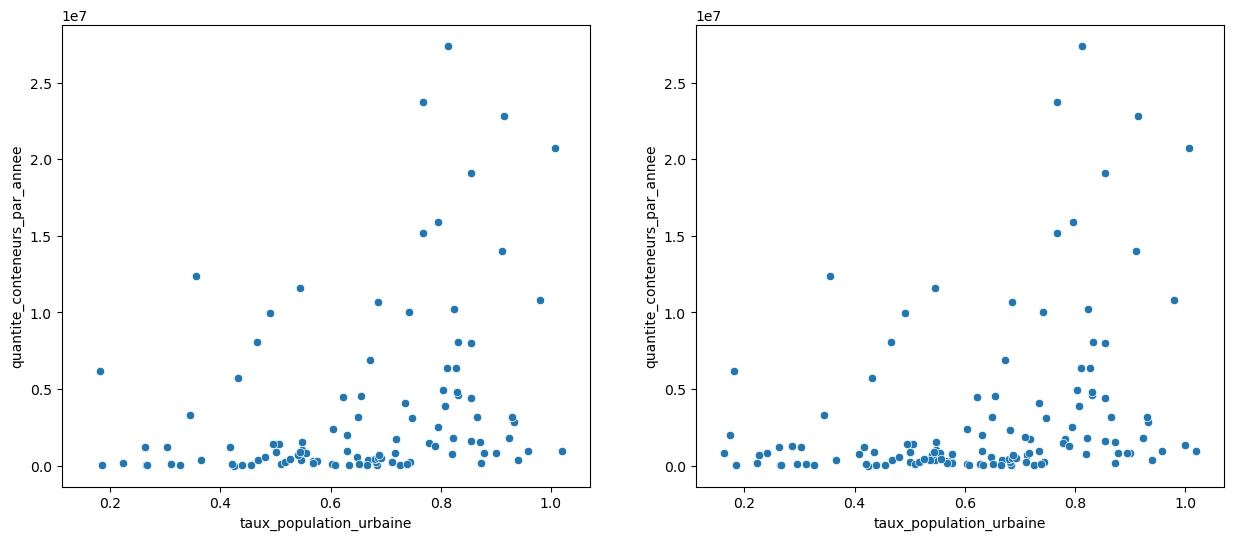

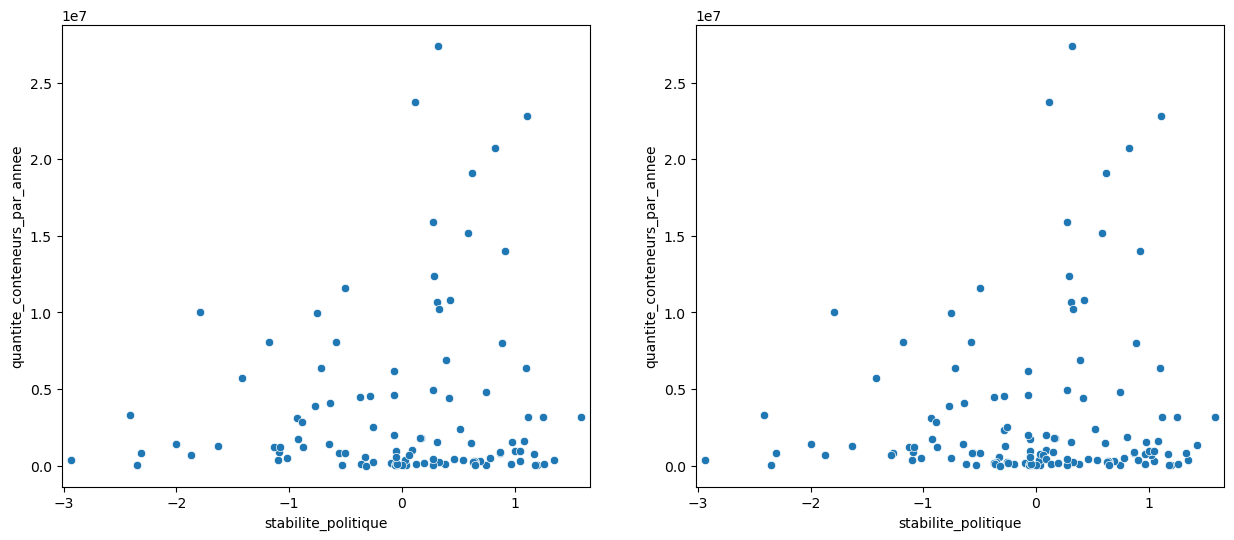

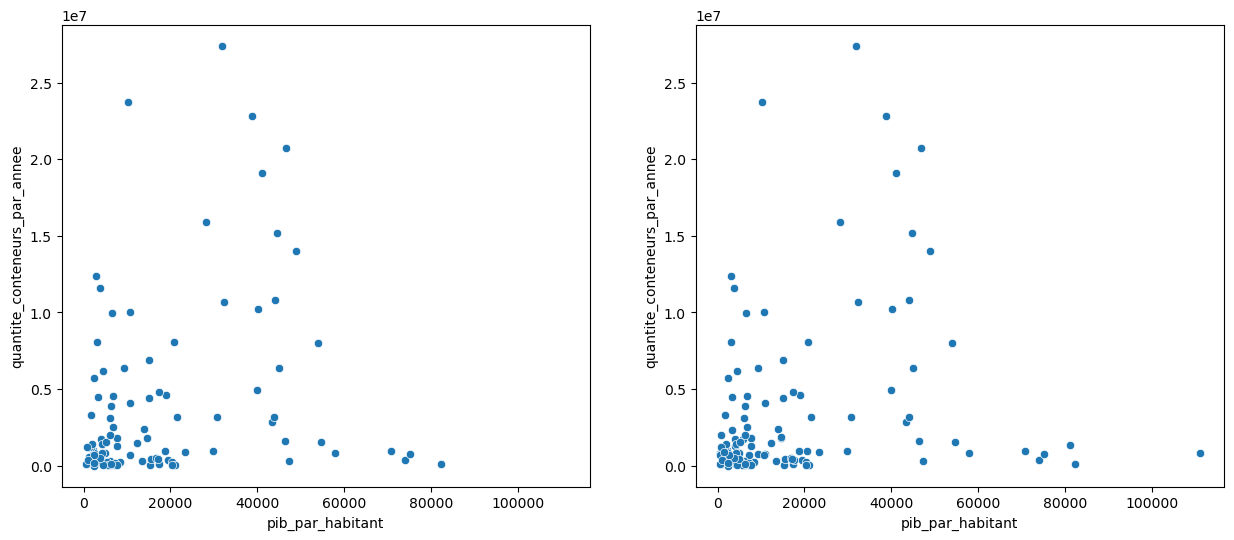

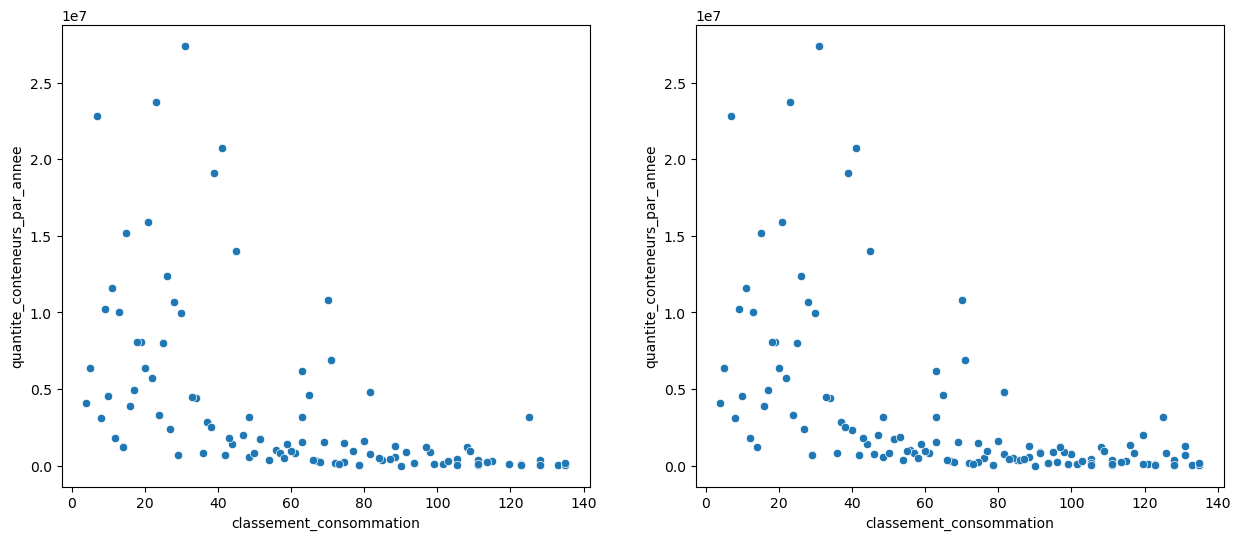

In [369]:
for var in df.drop(columns='pays').columns :
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.xlim(-0.05*df2[var].max()+df2[var].min(), df2[var].max()+0.05*df2[var].max())
    sns.scatterplot(data=df, y='quantite_conteneurs_par_annee', x=var)
    plt.subplot(1,2,2)
    sns.scatterplot(data=df2, y='quantite_conteneurs_par_annee', x=var)
    plt.xlim(-0.05*df2[var].max()+df2[var].min(), df2[var].max()+0.05*df2[var].max())
    plt.show()

Le résultat semble cohérent.

Le résultat semble cohérent, on verra si on garde la variable en fonction de l'avancement de l'analyse.

### Détermination des outliers grâce à un indicateur : Score de Mahalanobis

Le Score de Mahalanobis mesure la distance entre un individu et le centre de gravité de l'ensemble de données en prenant en compte la covariance des variables. Plus le score est élevé plus l'individu est gobalement éloigné du reste des données et est un outlier.

In [370]:
# j'utilise ces données car elles sont sans valeurs manquantes et centrées réduites
df_knn

# Calculer la moyenne de chaque variable
mean = np.mean(df_knn, axis=0)

# Calculer la matrice de covariance
cov = np.cov(df_knn.T)

# Calculer l'inverse de la matrice de covariance
inv_cov = np.linalg.inv(cov)

# Calculer le score de Mahalanobis pour chaque point
mahalanobis_scores = np.array([mahalanobis(x, mean, inv_cov) for x in df_knn])

df_mahalanobis_scores = pd.DataFrame(mahalanobis_scores, index=df['pays'], columns=['mahalanobis_scores'])
df_mahalanobis_scores.sort_values('mahalanobis_scores', ascending=False)

mahalanobis_scores
pays                                                                  
Pérou                                                             9.13
Japon                                                             8.67
Îles Salomon                                                      8.55
Fédération de Russie                                              8.20
Indonésie                                                         8.12
Chine - RAS de Hong-Kong                                          7.91
Pays-Bas                                                          7.53
Mexique                                                           7.53
Nigéria                                                           7.23
Malaisie                                                          6.92
République de Corée                                               6.78
Pologne                                                           6.55
Luxembourg                                                        6.42
Pakistan                                                          6.18
Allemagne                                                         5.99
Émirats arabes unis                                               5.84
Saint-Kitts-et-Nevis                                              5.57
Chine - RAS de Macao                                              5.51
Ukraine                                                           5.24
Thaïlande                                                         5.21
Tchad                                                             5.21
Viet Nam                                                          5.15
Afrique du Sud                                                    5.12
Arabie saoudite                                                   5.08
Belgique                                                          5.08
Iran (République islamique d')                                    4.88
Myanmar                                                           4.87
Grèce                                                             4.78
Islande                                                           4.78
France                                                            4.75
Turquie                                                           4.64
Argentine                                                         4.63
Iraq                                                              4.59
Yémen                                                             4.52
Australie                                                         4.49
Royaume-Uni de Grande-Bretagne et d'Irlande du ...                4.44
Trinité-et-Tobago                                                 4.42
Antigua-et-Barbuda                                                4.41
Gabon                                                             4.34
Congo                                                             4.33
Samoa                                                             4.23
Israël                                                            4.21
Fidji                                                             4.16
Canada                                                            4.16
Oman                                                              4.13
Barbade                                                           4.11
Suisse                                                            4.03
Dominique                                                         3.98
Koweït                                                            3.96
Italie                                                            3.90
Irlande                                                           3.83
Norvège                                                           3.81
Uruguay                                                           3.78
Namibie                                                           3.77
Maurice                                                           3.76
Liban

#### Valeurs manquantes taux droit de douane

In [371]:
df[df['taux_droit_douane'].isna()]

pays  exportation_volaille  importation_volaille  production  \
53  Iraq                  0.00            470,000.00   96,000.00   

    volaille_consommée  taux_dependance  taux_autosuffisance  \
53          561,000.00             0.83                 0.17   

    proportion_volaille_nourriture  proportion_animaux_nourriture  \
53                            0.04                           0.06   

      population  accroissement_population_moyen_par_annee  \
53 37,552,781.00                                786,106.05   

    taux_accroissement_population_moyen  lpi                pib  \
53                                 0.02 2.22 187,217,660,050.68   

    taux_droit_douane  quantite_conteneurs_par_annee  taux_population_urbaine  \
53                NaN                     823,944.70                     0.72   

    stabilite_politique  pib_par_habitant  classement_consommation  
53                -2.31          4,985.45                    36.00

Le pays a un taux de dépendance élevé et est gros consommateur de volaille, son marché intérieur doit être important. 

Cependant, sa stabilité politique est très faible...

On conserve la ligne tout de même pour l'instant et on imputera les valeurs manquantes avec le KNN neighboors.

In [372]:
(100*df.isna().sum()/df.shape[0]).sort_values(ascending=False)

quantite_conteneurs_par_annee              17.97
lpi                                         7.81
taux_droit_douane                           0.78
pays                                        0.00
exportation_volaille                        0.00
pib_par_habitant                            0.00
stabilite_politique                         0.00
taux_population_urbaine                     0.00
pib                                         0.00
taux_accroissement_population_moyen         0.00
accroissement_population_moyen_par_annee    0.00
population                                  0.00
proportion_animaux_nourriture               0.00
proportion_volaille_nourriture              0.00
taux_autosuffisance                         0.00
taux_dependance                             0.00
volaille_consommée                          0.00
production                                  0.00
importation_volaille                        0.00
classement_consommation                     0.00
dtype: float64

#### Valeurs manquantes lpi

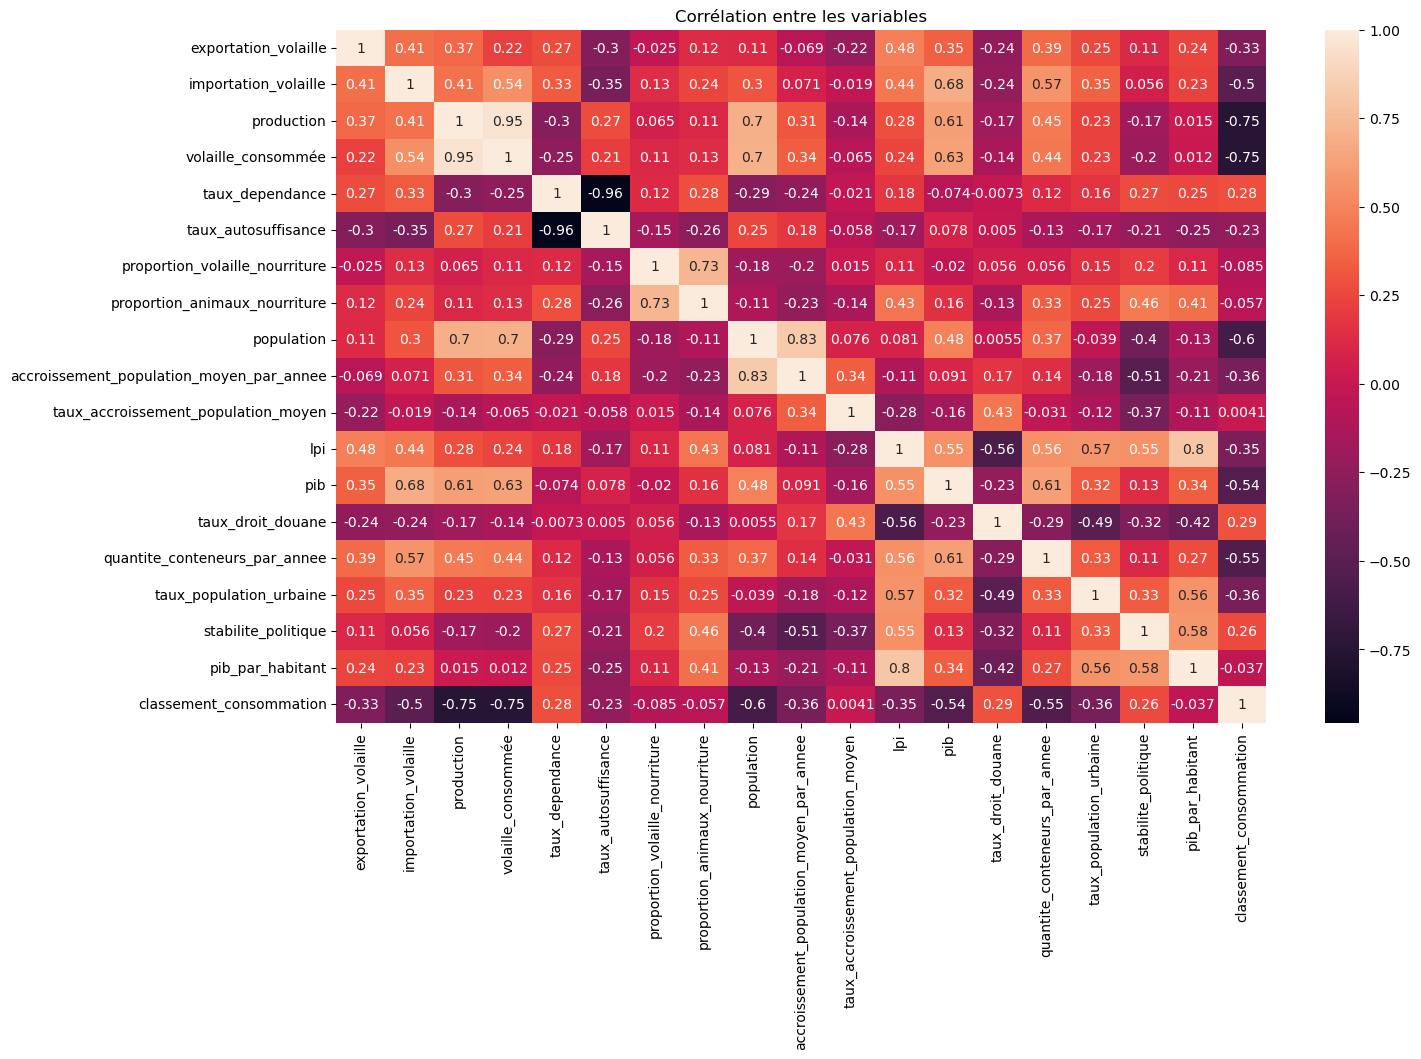

In [373]:
plt.figure(figsize=(15,9))

plt.title("Corrélation entre les variables")

sns.heatmap(df.corr(), annot=True)

plt.show()

On voit que le lpi est corrélé à 79% au pib par habitant, on vérifie graphiquement les 2 variables sont corrélées pour les valeurs de lpi générées par le KNN.

In [374]:
# ajout des valeurs dans df
df['lpi_knn'] = df2['lpi']

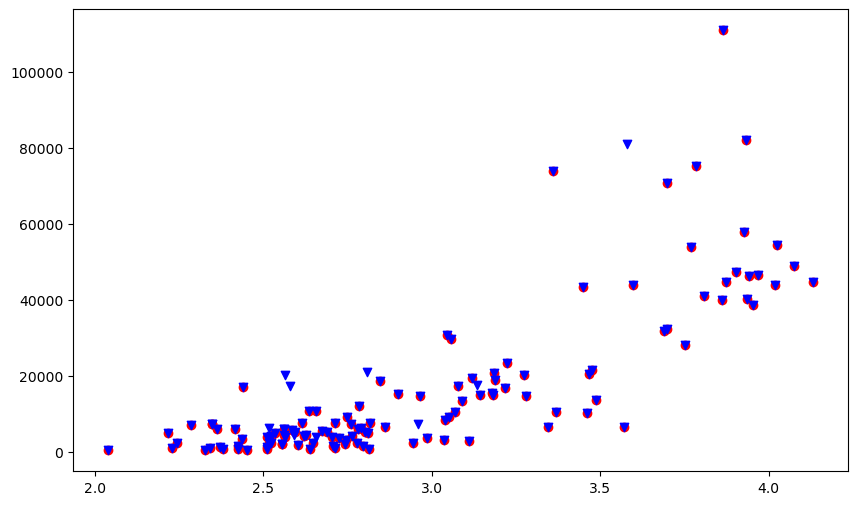

In [375]:
plt.figure(figsize=(10,6))

plt.scatter(df['lpi'], df['pib_par_habitant'], c='red')

plt.scatter(df['lpi_knn'], df['pib_par_habitant'], marker='v', c='blue')

<AxesSubplot:xlabel='lpi_knn', ylabel='pib_par_habitant'>

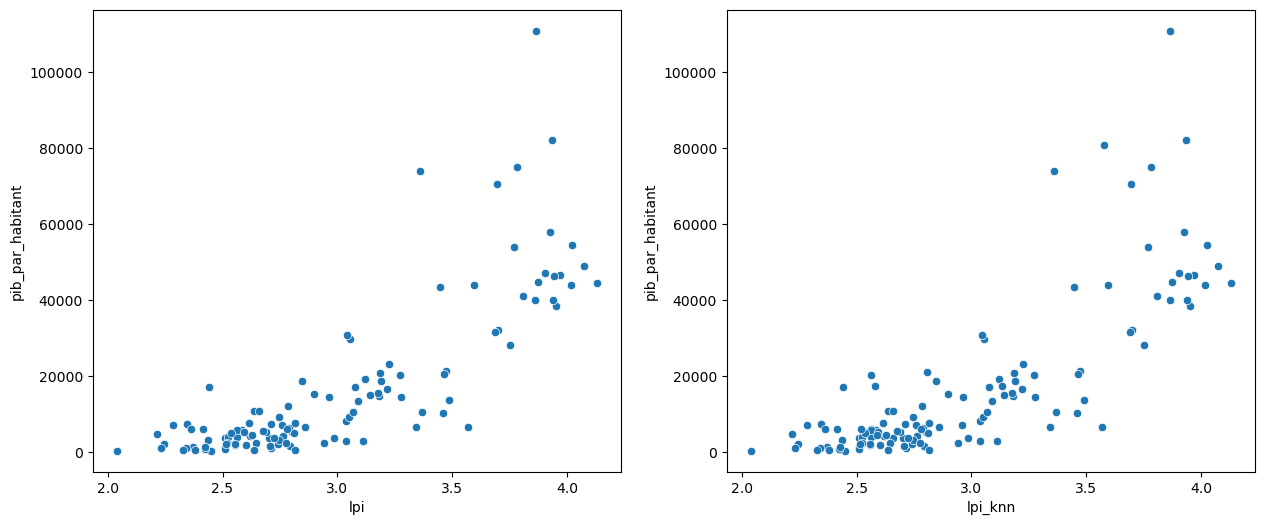

In [376]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='lpi', y='pib_par_habitant')
plt.subplot(1,2,2)
sns.scatterplot(data=df, x='lpi_knn', y='pib_par_habitant')

In [377]:
# on valide le changement
df['lpi'] = df['lpi_knn']

df.drop(columns='lpi_knn', inplace=True)

#### Valeurs manquantes quantité de conteneurs et cout production volaille, imputation par KNN

In [378]:
(100*df.isna().sum()/df.shape[0]).sort_values(ascending=False)

quantite_conteneurs_par_annee              17.97
taux_droit_douane                           0.78
pays                                        0.00
exportation_volaille                        0.00
pib_par_habitant                            0.00
stabilite_politique                         0.00
taux_population_urbaine                     0.00
pib                                         0.00
lpi                                         0.00
taux_accroissement_population_moyen         0.00
accroissement_population_moyen_par_annee    0.00
population                                  0.00
proportion_animaux_nourriture               0.00
proportion_volaille_nourriture              0.00
taux_autosuffisance                         0.00
taux_dependance                             0.00
volaille_consommée                          0.00
production                                  0.00
importation_volaille                        0.00
classement_consommation                     0.00
dtype: float64

In [379]:
df['taux_droit_douane'] = df2['taux_droit_douane']
df['quantite_conteneurs_par_annee'] = df2['quantite_conteneurs_par_annee']

In [380]:
(100*df.isna().sum()/df.shape[0]).sort_values(ascending=False)

pays                                       0.00
exportation_volaille                       0.00
pib_par_habitant                           0.00
stabilite_politique                        0.00
taux_population_urbaine                    0.00
quantite_conteneurs_par_annee              0.00
taux_droit_douane                          0.00
pib                                        0.00
lpi                                        0.00
taux_accroissement_population_moyen        0.00
accroissement_population_moyen_par_annee   0.00
population                                 0.00
proportion_animaux_nourriture              0.00
proportion_volaille_nourriture             0.00
taux_autosuffisance                        0.00
taux_dependance                            0.00
volaille_consommée                         0.00
production                                 0.00
importation_volaille                       0.00
classement_consommation                    0.00
dtype: float64

### Echantillon avec imputation KNN

In [381]:
# proportion de valeurs nulles
(100*df.isna().sum()/df.shape[0]).sort_values(ascending=False)

pays                                       0.00
exportation_volaille                       0.00
pib_par_habitant                           0.00
stabilite_politique                        0.00
taux_population_urbaine                    0.00
quantite_conteneurs_par_annee              0.00
taux_droit_douane                          0.00
pib                                        0.00
lpi                                        0.00
taux_accroissement_population_moyen        0.00
accroissement_population_moyen_par_annee   0.00
population                                 0.00
proportion_animaux_nourriture              0.00
proportion_volaille_nourriture             0.00
taux_autosuffisance                        0.00
taux_dependance                            0.00
volaille_consommée                         0.00
production                                 0.00
importation_volaille                       0.00
classement_consommation                    0.00
dtype: float64

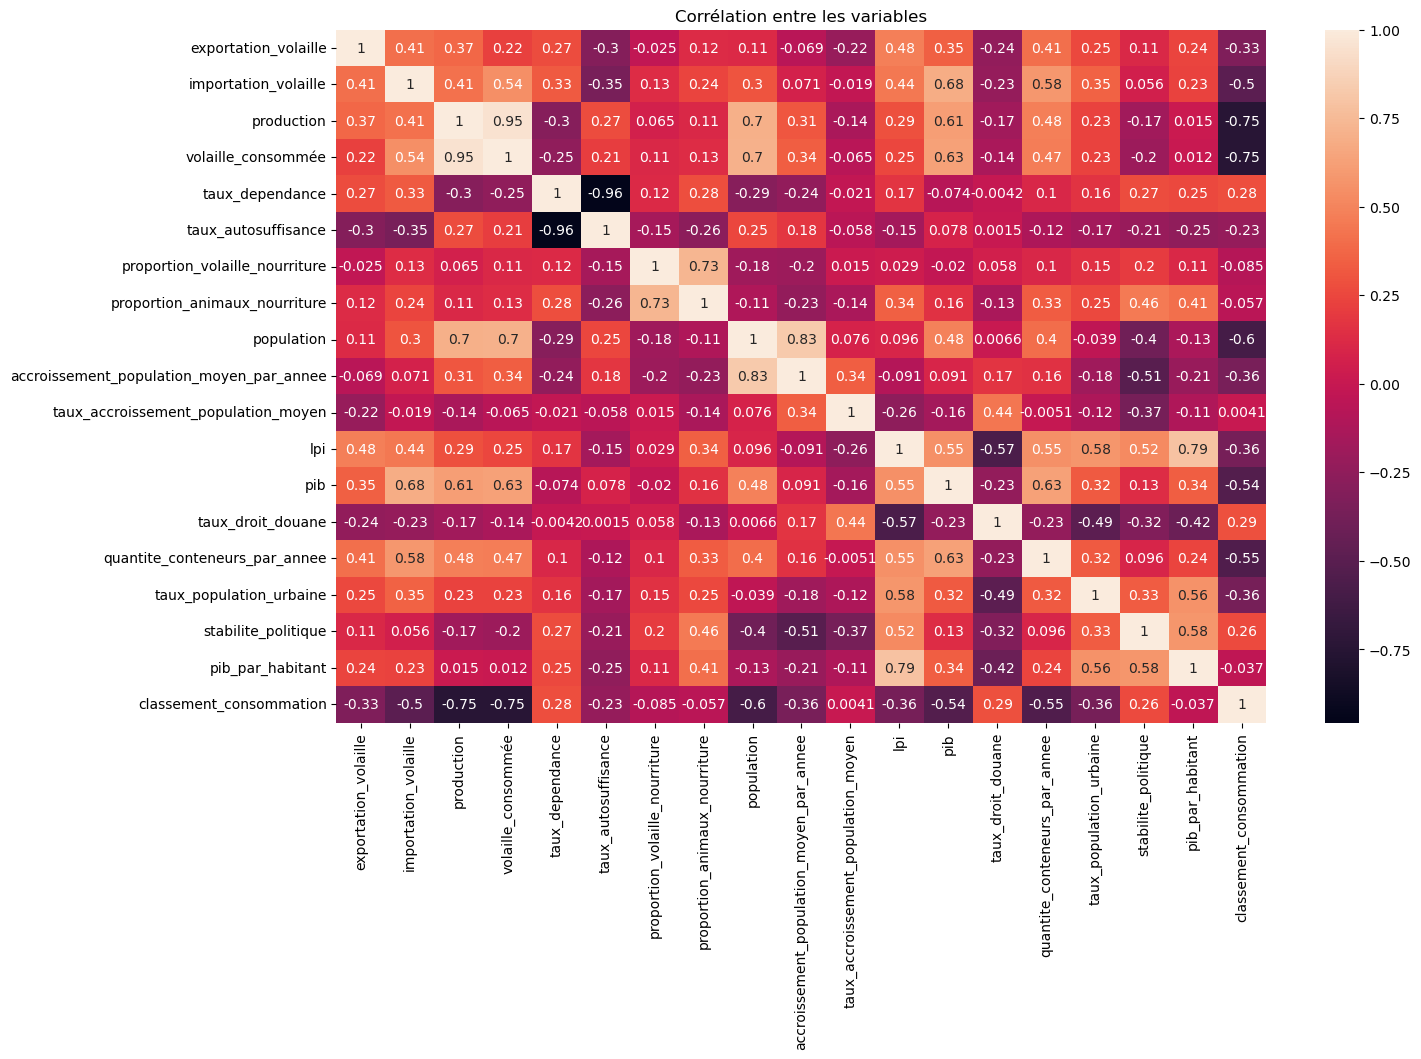

In [382]:
plt.figure(figsize=(15,9))

plt.title("Corrélation entre les variables")

sns.heatmap(df.corr(), annot=True)

plt.show()

<Figure size 1500x900 with 0 Axes>

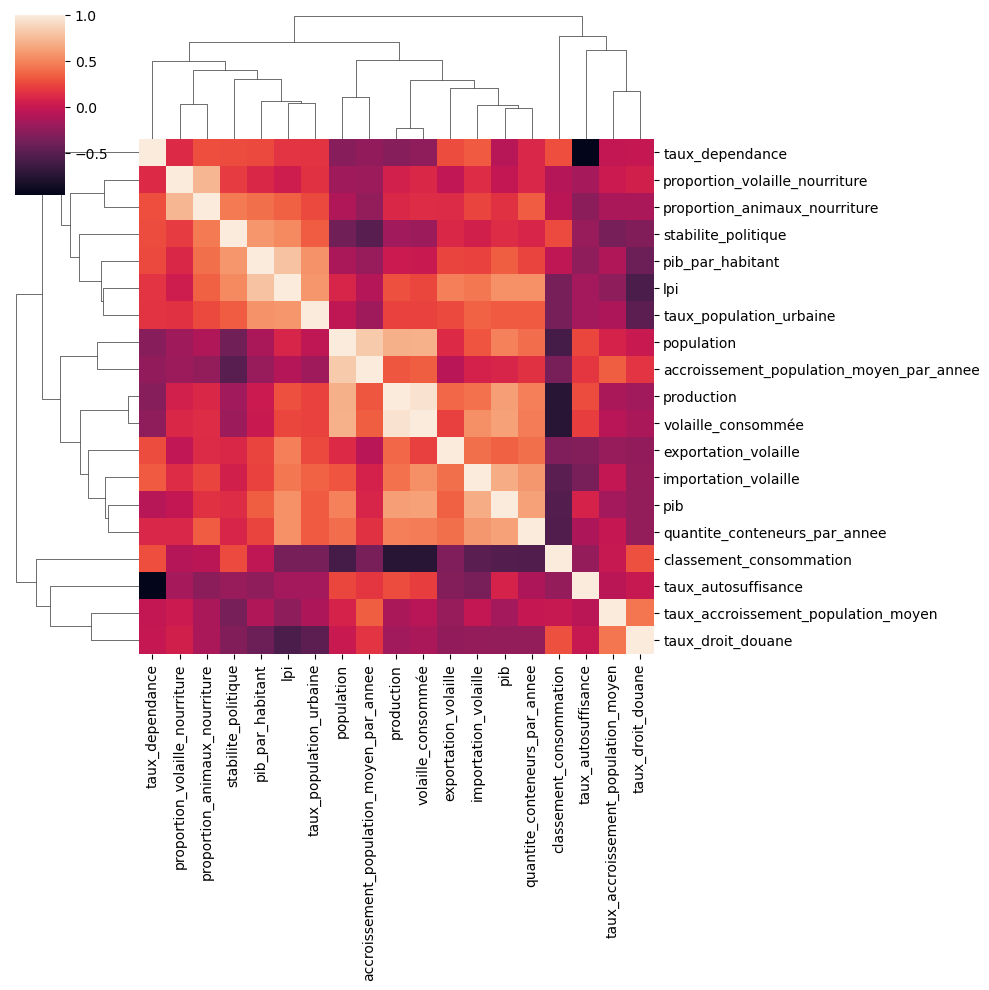

In [383]:
plt.figure(figsize=(15,9))

sns.clustermap(df.corr())

plt.show()

In [384]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   pays                                      128 non-null    object 
 1   exportation_volaille                      128 non-null    float64
 2   importation_volaille                      128 non-null    float64
 3   production                                128 non-null    float64
 4   volaille_consommée                        128 non-null    float64
 5   taux_dependance                           128 non-null    float64
 6   taux_autosuffisance                       128 non-null    float64
 7   proportion_volaille_nourriture            128 non-null    float64
 8   proportion_animaux_nourriture             128 non-null    float64
 9   population                                128 non-null    float64
 10  accroissement_population_moyen_par_ann

In [386]:
# suppression 'classement_consommation'
df.drop(columns='classement_consommation', inplace=True)

## Export des fichiers pour l'analyse

In [385]:
df.to_csv(folder_export+'pays_knn.csv', index=False)